In [1]:
import sys
import warnings
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pprint
import json
import copy
import math
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from lightgbm import LGBMRegressor
from xgboost.sklearn import XGBRegressor
from interpret.glassbox import ExplainableBoostingRegressor
from interpret import show
from catboost import CatBoostRegressor
from scipy.stats import chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor
from smogn import smoter

warnings.filterwarnings("ignore")

pd.options.display.float_format = '{:.5f}'.format

randomState = 100

In [4]:
print("Python version :", sys.version)
print("Numpy version :", np.__version__)
print("Pandas version :", pd.__version__)
print("Scipy version :", scipy.__version__)
print("Geopandas version :", gpd.__version__)

Python version : 3.11.3 | packaged by Anaconda, Inc. | (main, May 15 2023, 15:41:31) [MSC v.1916 64 bit (AMD64)]
Numpy version : 1.26.2
Pandas version : 2.1.3
Scipy version : 1.11.3
Geopandas version : 0.14.1


## 데이터 확인 및 전처리

### 전처리

In [2]:
# 학습 데이터 불러오기

df_train = pd.read_csv("./data/train.csv")

df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           39609 non-null  object
 1   사고일시         39609 non-null  object
 2   요일           39609 non-null  object
 3   기상상태         39609 non-null  object
 4   시군구          39609 non-null  object
 5   도로형태         39609 non-null  object
 6   노면상태         39609 non-null  object
 7   사고유형         39609 non-null  object
 8   사고유형 - 세부분류  39609 non-null  object
 9   법규위반         39609 non-null  object
 10  가해운전자 차종     39609 non-null  object
 11  가해운전자 성별     39609 non-null  object
 12  가해운전자 연령     39609 non-null  object
 13  가해운전자 상해정도   39609 non-null  object
 14  피해운전자 차종     38618 non-null  object
 15  피해운전자 성별     38618 non-null  object
 16  피해운전자 연령     38618 non-null  object
 17  피해운전자 상해정도   38618 non-null  object
 18  사망자수         39609 non-null  int64 
 19  중상자수         39609 non-nu

ID           사고일시   요일 기상상태            시군구      도로형태 노면상태  \
0  ACCIDENT_00000  2019-01-01 00  화요일   맑음   대구광역시 중구 대신동  단일로 - 기타   건조   
1  ACCIDENT_00001  2019-01-01 00  화요일   흐림  대구광역시 달서구 감삼동  단일로 - 기타   건조   
2  ACCIDENT_00002  2019-01-01 01  화요일   맑음  대구광역시 수성구 두산동  단일로 - 기타   건조   
3  ACCIDENT_00003  2019-01-01 02  화요일   맑음   대구광역시 북구 복현동  단일로 - 기타   건조   
4  ACCIDENT_00004  2019-01-01 04  화요일   맑음   대구광역시 동구 신암동  단일로 - 기타   건조   

   사고유형 사고유형 - 세부분류     법규위반  ... 가해운전자 상해정도 피해운전자 차종 피해운전자 성별 피해운전자 연령  \
0  차대사람  길가장자리구역통행중  안전운전불이행  ...       상해없음      보행자        여      70세   
1  차대사람       보도통행중       기타  ...       상해없음      보행자        남      61세   
2  차대사람       차도통행중  안전운전불이행  ...       상해없음      보행자        남      38세   
3   차대차          추돌  안전운전불이행  ...       상해없음       승용        남      36세   
4   차대차          추돌  안전운전불이행  ...       상해없음       승용        남      52세   

  피해운전자 상해정도 사망자수 중상자수 경상자수  부상자수  ECLO  
0         중상    0    1    0     0     5  
1         경상    0    0    1     0     3  
2         경상    0    0    1     0     3  
3         중상    0    1    0     0     5  
4         경상    0    0    1     0     3  

[5 rows x 23 columns]

In [3]:
# 컬럼별 데이터 라벨 확인

df_train.nunique()

ID             39609
사고일시           18057
요일                 7
기상상태               6
시군구              199
도로형태              11
노면상태               6
사고유형               3
사고유형 - 세부분류       14
법규위반              11
가해운전자 차종          12
가해운전자 성별           3
가해운전자 연령          89
가해운전자 상해정도         6
피해운전자 차종          13
피해운전자 성별           3
피해운전자 연령          97
피해운전자 상해정도         6
사망자수               3
중상자수               7
경상자수              18
부상자수               9
ECLO              46
dtype: int64

In [3]:
# 테스트 데이터 데이터 확인

df_test = pd.read_csv("./data/test.csv")

df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10963 entries, 0 to 10962
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      10963 non-null  object
 1   사고일시    10963 non-null  object
 2   요일      10963 non-null  object
 3   기상상태    10963 non-null  object
 4   시군구     10963 non-null  object
 5   도로형태    10963 non-null  object
 6   노면상태    10963 non-null  object
 7   사고유형    10963 non-null  object
dtypes: object(8)
memory usage: 685.3+ KB


In [5]:
# 테스트 데이터 라벨 확인

df_test.nunique()

ID      10963
사고일시     5548
요일          7
기상상태        5
시군구       192
도로형태       11
노면상태        6
사고유형        3
dtype: int64

In [6]:
# train-test 중 겹치는 컬럼의 데이터 라벨 확인

col_test = df_test.columns[1:]

for c in col_test : 
    print(c+"의 train unique")
    print(sorted(df_train[c].unique().tolist()))
    print("-----------------------")
    print(c+"의 test unique")
    print(sorted(df_test[c].unique().tolist()))
    print("********************")


# 시군구의 경우 test에 존재하는 값이 train에 전부 존재하는지 확인

사고일시의 train unique
['2019-01-01 00', '2019-01-01 01', '2019-01-01 02', '2019-01-01 04', '2019-01-01 05', '2019-01-01 06', '2019-01-01 10', '2019-01-01 11', '2019-01-01 14', '2019-01-01 18', '2019-01-01 19', '2019-01-01 20', '2019-01-01 22', '2019-01-02 01', '2019-01-02 02', '2019-01-02 07', '2019-01-02 08', '2019-01-02 10', '2019-01-02 11', '2019-01-02 13', '2019-01-02 14', '2019-01-02 15', '2019-01-02 16', '2019-01-02 17', '2019-01-02 18', '2019-01-02 19', '2019-01-02 20', '2019-01-02 22', '2019-01-02 23', '2019-01-03 00', '2019-01-03 02', '2019-01-03 03', '2019-01-03 05', '2019-01-03 07', '2019-01-03 08', '2019-01-03 10', '2019-01-03 11', '2019-01-03 12', '2019-01-03 13', '2019-01-03 14', '2019-01-03 15', '2019-01-03 17', '2019-01-03 18', '2019-01-03 19', '2019-01-03 20', '2019-01-03 21', '2019-01-03 22', '2019-01-03 23', '2019-01-04 00', '2019-01-04 01', '2019-01-04 04', '2019-01-04 05', '2019-01-04 06', '2019-01-04 07', '2019-01-04 08', '2019-01-04 10', '2019-01-04 11', '2019-01-04

In [7]:
uni_city = df_test["시군구"].unique().tolist()

len_city_test = len(uni_city)

len_city_train = len(df_train[df_train["시군구"].isin(uni_city)]["시군구"].unique())

if len_city_test == len_city_train : 
    print("test data의 시군구 값은 train data에 전부 속합니다.")

test data의 시군구 값은 train data에 전부 속합니다.


In [4]:
# train의 데이터의 일부와 test 데이터를 합쳐 모델 학습용 데이터로 만듦

len_train = df_train.shape[0]
len_test = df_test.shape[0]

df_model = pd.concat((df_train[df_test.columns], df_test), axis=0)

print(len_train+len_test)
df_model.info()

50572
<class 'pandas.core.frame.DataFrame'>
Index: 50572 entries, 0 to 10962
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      50572 non-null  object
 1   사고일시    50572 non-null  object
 2   요일      50572 non-null  object
 3   기상상태    50572 non-null  object
 4   시군구     50572 non-null  object
 5   도로형태    50572 non-null  object
 6   노면상태    50572 non-null  object
 7   사고유형    50572 non-null  object
dtypes: object(8)
memory usage: 3.5+ MB


In [5]:
# 불필요한 컬럼 정리

df_train.drop(labels=["ID"], axis=1, inplace=True)
df_model.drop(labels=["ID"], axis=1, inplace=True)

In [6]:
# 사고 일시 object -> datetime

df_train["사고일시"] = pd.to_datetime(df_train["사고일시"], format="%Y-%m-%d %H")
df_model["사고일시"] = pd.to_datetime(df_model["사고일시"], format="%Y-%m-%d %H")

print(df_train["사고일시"].dtypes)
print(df_model["사고일시"].dtypes)

datetime64[ns]
datetime64[ns]


In [11]:
# 컬럼별 결측치 갯수 확인

df_train.isnull().sum()

사고일시             0
요일               0
기상상태             0
시군구              0
도로형태             0
노면상태             0
사고유형             0
사고유형 - 세부분류      0
법규위반             0
가해운전자 차종         0
가해운전자 성별         0
가해운전자 연령         0
가해운전자 상해정도       0
피해운전자 차종       991
피해운전자 성별       991
피해운전자 연령       991
피해운전자 상해정도     991
사망자수             0
중상자수             0
경상자수             0
부상자수             0
ECLO             0
dtype: int64

결측치의 대부분이 피해 운전자이므로, 결측치가 존재하는 데이터의 사고 유형 등을 확인

In [12]:
df_train_null = df_train[df_train["피해운전자 차종"].isnull()]

print("null인 데이터의 사고 종류 :",df_train_null["사고유형"].unique())
print("null인 데이터의 상해 정도 종류 :",df_train_null["가해운전자 상해정도"].unique())

# 차량 단독으로 일어난 사고이므로 피해자가 없음, 차량 단독이지만 상해 종류는 다양

null인 데이터의 사고 종류 : ['차량단독']
null인 데이터의 상해 정도 종류 : ['중상' '경상' '상해없음' '부상신고' '사망' '기타불명']


In [13]:
# '차량 단독'이 전체 데이터 중 어느 정도 비율을 차지하는지 확인

df_train["사고유형"].value_counts()

사고유형
차대차     31785
차대사람     6833
차량단독      991
Name: count, dtype: int64

차량 단독의 전체 개수가 null 값인 사고 유형의 갯수와 일치하므로, 차량 단독 데이터를 제거할 수 없고 결측치 처리 필요

In [7]:
# 피해 운전자 관련 데이터의 label 확인

pihae = ['피해운전자 차종','피해운전자 성별','피해운전자 연령','피해운전자 상해정도']

for i in range(4) : 
    print(df_train[pihae[i]].unique())
    print("--------------------------")


# null 값을 '기타불명', '미분류' 등으로 대체

['보행자' '승용' '자전거' '승합' nan '이륜' '화물' '개인형이동수단(PM)' '사륜오토바이(ATV)' '특수'
 '원동기' '기타불명' '건설기계' '농기계']
--------------------------
['여' '남' nan '기타불명']
--------------------------
['70세' '61세' '38세' '36세' '52세' '35세' '76세' '53세' '62세' '42세' '60세' '69세'
 '31세' '23세' nan '57세' '17세' '54세' '55세' '64세' '41세' '44세' '58세' '45세'
 '30세' '59세' '34세' '68세' '32세' '21세' '56세' '18세' '37세' '39세' '27세' '65세'
 '43세' '12세' '75세' '4세' '71세' '40세' '48세' '14세' '19세' '66세' '63세' '50세'
 '20세' '67세' '26세' '22세' '47세' '16세' '28세' '46세' '51세' '29세' '33세' '24세'
 '79세' '80세' '74세' '78세' '72세' '49세' '73세' '5세' '13세' '77세' '9세' '86세'
 '15세' '84세' '25세' '82세' '10세' '8세' '85세' '7세' '11세' '88세' '미분류' '87세'
 '83세' '90세 이상' '3세' '81세' '6세' '89세' '2세' '1세' '91세' '90세' '93세' '94세'
 '92세' '98세 이상']
--------------------------
['중상' '경상' '상해없음' nan '부상신고' '사망' '기타불명']
--------------------------


In [8]:
# 결측치 채움

fill = ["기타불명", "기타불명", "미분류", "기타불명"]

for i in range(4) : 
    df_train[pihae[i]].fillna(fill[i], inplace=True)

df_train.isnull().sum()

사고일시           0
요일             0
기상상태           0
시군구            0
도로형태           0
노면상태           0
사고유형           0
사고유형 - 세부분류    0
법규위반           0
가해운전자 차종       0
가해운전자 성별       0
가해운전자 연령       0
가해운전자 상해정도     0
피해운전자 차종       0
피해운전자 성별       0
피해운전자 연령       0
피해운전자 상해정도     0
사망자수           0
중상자수           0
경상자수           0
부상자수           0
ECLO           0
dtype: int64

In [9]:
# 가해 연령 / 피해 연령 범주화

df_train["가해연령_수정"] = df_train["가해운전자 연령"].str.extract(r"([0-9]+)세")
df_train["피해연령_수정"] = df_train["피해운전자 연령"].str.extract(r"([0-9]+)세")

df_train[["가해연령_수정","피해연령_수정"]] = df_train[["가해연령_수정","피해연령_수정"]].fillna('9999')  # 미분류의 경우 숫자 분리가 안 돼 NaN을 반환하므로, 임의의 숫자를 채움

df_train[["가해연령_수정","피해연령_수정"]] = df_train[["가해연령_수정","피해연령_수정"]].astype(int)

df_train["가해연령대"] = pd.cut(x=df_train["가해연령_수정"], bins=[0,10,20,30,40,50,60,70,80,90,100,150,10000], 
                           labels=["영유아", "10대", "20대", "30대", "40대", "50대", "60대", "70대", "80대", "90대", "100세 이상", "미분류"],   # 연령대를 범주화
                           include_lowest=True)

df_train["피해연령대"] = pd.cut(x=df_train["피해연령_수정"], bins=[0,10,20,30,40,50,60,70,80,90,100,150,10000], 
                           labels=["영유아", "10대", "20대", "30대", "40대", "50대", "60대", "70대", "80대", "90대", "100세 이상", "미분류"],
                           include_lowest=True)

df_train[df_train["가해연령_수정"]==9999]

사고일시   요일 기상상태            시군구         도로형태 노면상태  사고유형  \
11    2019-01-01 14:00:00  화요일   맑음   대구광역시 동구 신기동   교차로 - 교차로안   건조   차대차   
38    2019-01-02 15:00:00  수요일   맑음   대구광역시 서구 이현동     단일로 - 기타   건조   차대차   
83    2019-01-03 20:00:00  목요일   맑음   대구광역시 북구 태전동     단일로 - 기타   건조   차대차   
145   2019-01-05 17:00:00  토요일   맑음   대구광역시 북구 산격동     단일로 - 기타   건조  차대사람   
186   2019-01-07 02:00:00  월요일   맑음  대구광역시 달서구 진천동     단일로 - 기타   건조   차대차   
...                   ...  ...  ...            ...          ...  ...   ...   
39486 2021-12-28 13:00:00  화요일   맑음  대구광역시 달서구 진천동     단일로 - 기타   건조  차대사람   
39518 2021-12-29 16:00:00  수요일   맑음  대구광역시 수성구 범어동     단일로 - 기타   건조  차대사람   
39540 2021-12-30 11:00:00  목요일   맑음  대구광역시 수성구 범어동     단일로 - 기타   건조   차대차   
39578 2021-12-31 12:00:00  금요일   맑음  대구광역시 달성군 구지면     단일로 - 기타   건조   차대차   
39602 2021-12-31 18:00:00  금요일   흐림  대구광역시 달서구 이곡동  교차로 - 교차로부근   건조  차대사람   

      사고유형 - 세부분류     법규위반 가해운전자 차종  ... 피해운전자 상해정도 사망자수 중상자수 경상자수 부상자수 ECLO  \
11             기타  안전운전불이행     기타불명  ...         경상    0    0    1    0    3   
38           측면충돌  안전거리미확보     기타불명  ...       부상신고    0    0    0    1    1   
83           측면충돌  안전운전불이행     기타불명  ...         중상    0    1    0    0    5   
145            기타  안전운전불이행     기타불명  ...         경상    0    0    1    0    3   
186            기타  안전운전불이행     기타불명  ...       부상신고    0    0    0    1    1   
...           ...      ...      ...  ...        ...  ...  ...  ...  ...  ...   
39486          기타  안전운전불이행     기타불명  ...         경상    0    0    1    0    3   
39518          기타  안전운전불이행     기타불명  ...         경상    0    0    1    0    3   
39540          기타  안전운전불이행     기타불명  ...       상해없음    0    0    1    0    3   
39578          기타  안전거리미확보     기타불명  ...         경상    0    0    1    0    3   
39602          기타  안전운전불이행       이륜  ...         경상    0    0    1    0    3   

      가해연령_수정  피해연령_수정  가해연령대  피해연령대  
11       9999       69    미분류    60대  
38       9999       32    미분류    30대  
83       9999       66    미분류    60대  
145      9999       36    미분류    30대  
186      9999       56    미분류    50대  
...       ...      ...    ...    ...  
39486    9999       64    미분류    60대  
39518    9999       13    미분류    10대  
39540    9999       35    미분류    30대  
39578    9999       30    미분류    20대  
39602    9999       32    미분류    30대  

[994 rows x 26 columns]

### 외부 데이터 불러오기

In [10]:
# cctv 데이터

cctv = pd.read_csv("./data/external_open/대구 CCTV 정보.csv", encoding='cp949')

cctv.info()
cctv.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065 entries, 0 to 1064
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   무인교통단속카메라관리번호  1065 non-null   object 
 1   시도명            1065 non-null   object 
 2   시군구명           1065 non-null   object 
 3   도로종류           1065 non-null   object 
 4   도로노선번호         288 non-null    object 
 5   도로노선명          1065 non-null   object 
 6   도로노선방향         1065 non-null   int64  
 7   소재지도로명주소       905 non-null    object 
 8   소재지지번주소        1065 non-null   object 
 9   위도             1065 non-null   float64
 10  경도             1065 non-null   float64
 11  설치장소           1065 non-null   object 
 12  단속구분           1065 non-null   int64  
 13  제한속도           1065 non-null   int64  
 14  단속구간위치구분       53 non-null     float64
 15  과속단속구간길이       26 non-null     float64
 16  보호구역구분         893 non-null    float64
 17  설치연도           1065 non-null   int64  
dtypes: float

무인교통단속카메라관리번호    시도명 시군구명 도로종류 도로노선번호 도로노선명  도로노선방향          소재지도로명주소  \
0          주차12  대구광역시   남구   시도    NaN   대명로       3  대구광역시 남구 대명로 162   
1          주차13  대구광역시   남구   시도    NaN   봉덕로       3  대구광역시 남구 봉덕로 135   
2          주차14  대구광역시   남구   시도    NaN   대봉로       3  대구광역시 남구 봉덕로 134   
3          주차15  대구광역시   남구   시도    NaN   큰골길       3  대구광역시 남구 큰골길 200   
4          주차16  대구광역시   남구   시도    NaN   큰골길       3  대구광역시 남구 큰골길 243   

                소재지지번주소       위도        경도           설치장소  단속구분  제한속도  \
0   대구광역시 남구 대명동 903-13 35.83886 128.57542  안지랑네거리1 버스정류장     4     0   
1    대구광역시 남구 봉덕동 853-8 35.84465 128.60462         효성백년가약     4     0   
2   대구광역시 남구 봉덕동 866-46 35.84418 128.60481       강변코오롱하늘채     4     0   
3  대구광역시 남구 대명동 2680-17 35.83480 128.58528         보성청록타운     4     0   
4     대구광역시 남구 봉덕동 1616 35.83273 128.58832          환경차고지     4     0   

   단속구간위치구분  과속단속구간길이   보호구역구분  설치연도  
0       NaN       NaN 99.00000  2010  
1       NaN       NaN 99.00000  2013  
2       NaN       NaN 99.00000  2013  
3       NaN       NaN 99.00000  2014  
4       NaN       NaN 99.00000  2014

In [18]:
cctv[["단속구분", "제한속도"]].value_counts().sort_index(ascending=False).to_frame()

count
단속구분 제한속도       
99   100      16
     80       25
     60        2
     50        4
     40        2
     30        2
4    0       232
2    80        3
     70       13
     60      126
     50      218
     40       67
     30      148
1    110       1
     100       3
     80        4
     70        9
     60       59
     50       52
     40       11
     30       68

보통 제한 속도를 보면서 운전을 하는 것이 아니라 cctv가 있을 때 속도를 줄이므로,  
단속 구분과 제한 속도는 의미가 없고 행정 구역별 갯수가 유의미할 것으로 판단

---

In [11]:
cctv2019 = cctv[cctv["설치연도"]<=2019]
cctv2020 = cctv[cctv["설치연도"]<=2020]
cctv2021 = cctv[cctv["설치연도"]<=2021]

print(cctv2019.shape)
print(cctv2020.shape)
print(cctv2020.shape)

(581, 18)
(750, 18)
(750, 18)


In [77]:
cctv2019["설치장소"].value_counts()

설치장소
대구포항고속도로1.1K대구방향출구)       2
안지랑네거리1 버스정류장             1
신천초등학교입구(청구네거리→신천네거리)     1
율하교동편네거리(각산네거리→반야월삼거리)    1
산장맨션삼거리(두리봉터널→담티고가교)      1
                         ..
동산네거리 (새동산약국)             1
경대병원건너 (두산약국 앞)           1
현대백화점건너                   1
봉산문화회관입구 (미래에셋증권 앞)       1
거매리마을(군위IC방면)             1
Name: count, Length: 580, dtype: int64

In [78]:
cctv2019[cctv2019["설치장소"]=='대구포항고속도로1.1K대구방향출구)']

무인교통단속카메라관리번호    시도명 시군구명  도로종류 도로노선번호     도로노선명  도로노선방향  \
381         F7245  대구광역시   동구  고속국도     20  대구포항고속도로       1   
382         F7246  대구광역시   동구  고속국도     20  대구포항고속도로       1   

             소재지도로명주소               소재지지번주소       위도        경도  \
381               NaN  대구광역시 동구 평광동 산 147-1 35.93722 128.68776   
382  대구광역시 동구 둔산로 530   대구광역시 동구 도동 산 185-1 35.91940 128.66694   

                    설치장소  단속구분  제한속도  단속구간위치구분  과속단속구간길이   보호구역구분  설치연도  
381  대구포항고속도로1.1K대구방향출구)    99   100   2.00000   9.48100 99.00000  2013  
382  대구포항고속도로1.1K대구방향출구)    99   100   2.00000   9.48100 99.00000  2013

In [12]:
for i in range(2019, 2022) : 

    globals()['cctv'+str(i)]["주소_수정"] = globals()['cctv'+str(i)]["소재지지번주소"].map(lambda x : " ".join(x.split()[:3]))

    globals()['gb_cctv'+str(i)] = globals()['cctv'+str(i)].groupby("주소_수정")["주소_수정"].count().sort_values(ascending=False)

    globals()['gb_cctv'+str(i)].index.rename("",inplace=True)

    globals()['gb_cctv'+str(i)] = globals()['gb_cctv'+str(i)].to_frame()

    globals()['gb_cctv'+str(i)].reset_index(level=0,inplace=True)

    globals()['gb_cctv'+str(i)].columns = ["주소_수정", "주소별 cctv 수"]

    globals()['gb_cctv'+str(i)]["연도"] = i

In [13]:
gb_cctv = pd.concat([gb_cctv2019, gb_cctv2020, gb_cctv2021], axis=0)

gb_cctv

주소_수정  주소별 cctv 수    연도
0      대구광역시 남구 대명동          38  2019
1     대구광역시 달성군 화원읍          27  2019
2     대구광역시 달성군 다사읍          26  2019
3     대구광역시 달서구 용산동          18  2019
4     대구광역시 달서구 이곡동          17  2019
..              ...         ...   ...
169    대구광역시 북구 동변동           1  2021
170  대구광역시 북구 노원동2가           1  2021
171  대구광역시 북구 노원동1가           1  2021
172  대구광역시 북구 고성동3가           1  2021
173  대구광역시 중구 태평로3가           1  2021

[474 rows x 3 columns]

In [14]:
gb_cctv["연도"] = pd.to_datetime(gb_cctv["연도"], format="%Y")

gb_cctv.info()

<class 'pandas.core.frame.DataFrame'>
Index: 474 entries, 0 to 173
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   주소_수정       474 non-null    object        
 1   주소별 cctv 수  474 non-null    int64         
 2   연도          474 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 14.8+ KB


---

In [15]:
# # 보안등 데이터

# light = pd.read_csv("./data/external_open/대구 보안등 정보.csv", encoding='cp949')

# light.info()
# # light.head()

In [16]:
# wrong_address = light[light["주소_수정"].str.contains(r"대구광역시\s[ㄱ-힣]+구\s[ㄱ-힣]+[0-9]+[^가^동\.·]")]

# # light.loc[wrong_address.index, "주소_수정"] = 
# light.loc[wrong_address.index, "주소_수정"]

보안등 데이터의 주소의 전처리 시간이 오래 걸리므로,  
  
일단 보류

In [20]:
# # 어린이 보호 구역 데이터

# child = pd.read_csv("./data/external_open/대구 어린이 보호 구역 정보.csv", encoding='cp949')

# child.info()
# # child.head()

In [21]:
# # cctv 설치여부 Y -> 1, N -> 0으로 변경

# child["CCTV설치여부"].replace({"Y":1, "N":0}, inplace=True)

# child["CCTV설치여부"].unique()

In [22]:
# data_sch = child["대상시설명"].value_counts()

# data_sch

In [23]:
# child[child["대상시설명"]=="화원초등"]

# 동일한 데이터가 2개

In [24]:
# date_date_child = child[["대상시설명","데이터기준일자"]].value_counts()

# date_date_child

# 이름은 같지만 데이터기준일자가 다른 데이터가 존재

In [25]:
# print("대상시설명과 데이터기준일자에 따른 데이터 총합 =", date_date_child.sum())

In [26]:
# child_dr = child.drop_duplicates(subset=["대상시설명","데이터기준일자"], keep="first")   # 동일한 데이터를 삭제

# child_dr[["대상시설명","데이터기준일자"]].value_counts()

In [27]:
# child_dr[child_dr["대상시설명"]=="꿈나무어린이집"]

이름이 같고 주소가 다른 어린이집이 존재

In [28]:
# print("중복을 제거한 대상시설명과 데이터기준일자에 따른 데이터 총합 =", child_dr[["대상시설명","데이터기준일자"]].value_counts().sum())

어린이 보호 구역에 cctv 여부는 중요할 것으로 판단(cctv가 존재할 때 속도를 줄일 것이기에).

In [13]:
# # 주차장 데이터

# parking = pd.read_csv("./data/external_open/대구 주차장 정보.csv", encoding='cp949')

# parking.info()
# # parking.head()

---

In [30]:
# 주소별로 지역별 전체 cctv 갯수 파악

# gb_cctv = cctv.groupby("주소_수정")["주소_수정"].count().sort_values(ascending=False)

# gb_cctv.index.rename("",inplace=True)

# gb_cctv = gb_cctv.to_frame()

# gb_cctv.reset_index(level=0,inplace=True)

# gb_cctv.columns = ["주소_수정", "주소별 cctv 수"]

# gb_cctv

In [31]:
# # 주소별 어린이 보호구역 개수 파악

# gb_child_dr = child_dr.groupby("주소_수정")[["주소_수정", "CCTV설치여부"]].agg({"주소_수정":["count"], "CCTV설치여부":["sum"]}).sort_index(axis=0, level=0)

# gb_child_dr.columns = ["주소별 어린이 보호구역 수", "주소별 어린이 보호구역 cctv 수"]

# gb_child_dr.reset_index(inplace=True)

# gb_child_dr

In [17]:
def make_cctv(left, right) : 

    df_l = copy.deepcopy(left)
    df_r = copy.deepcopy(right)

    cnt = 0

    for i in range(df_l.shape[0]) :
        # print(cnt)        
        value_df = df_r[(df_r["연도"] <= df_l.loc[i, "사고일시"]) & (df_r["주소_수정"] == df_l.loc[i, "시군구"])]

        len = value_df.shape[0]

        if len != 0 : 
        
            df_l.loc[i, "주소별 cctv 수"] = value_df.iloc[len-1, 1]
        cnt += 1
        
    df_l.fillna(0, axis=1, inplace=True)

    return df_l

In [18]:
df_train_join = make_cctv(df_train, gb_cctv)

df_train_join

사고일시   요일 기상상태              시군구             도로형태 노면상태  \
0      2019-01-01 00:00:00  화요일   맑음     대구광역시 중구 대신동         단일로 - 기타   건조   
1      2019-01-01 00:00:00  화요일   흐림    대구광역시 달서구 감삼동         단일로 - 기타   건조   
2      2019-01-01 01:00:00  화요일   맑음    대구광역시 수성구 두산동         단일로 - 기타   건조   
3      2019-01-01 02:00:00  화요일   맑음     대구광역시 북구 복현동         단일로 - 기타   건조   
4      2019-01-01 04:00:00  화요일   맑음     대구광역시 동구 신암동         단일로 - 기타   건조   
...                    ...  ...  ...              ...              ...  ...   
39604  2021-12-31 19:00:00  금요일   맑음  대구광역시 수성구 수성동3가       교차로 - 교차로안   건조   
39605  2021-12-31 19:00:00  금요일   맑음    대구광역시 달서구 상인동         단일로 - 기타   건조   
39606  2021-12-31 21:00:00  금요일   맑음    대구광역시 달서구 월성동       교차로 - 교차로안   건조   
39607  2021-12-31 22:00:00  금요일   맑음     대구광역시 달서구 장동          기타 - 기타   건조   
39608  2021-12-31 23:00:00  금요일   맑음     대구광역시 서구 비산동  단일로 - 지하차도(도로)내   건조   

       사고유형 사고유형 - 세부분류       법규위반 가해운전자 차종  ... 사망자수 중상자수 경상자수 부상자수 ECLO  \
0      차대사람  길가장자리구역통행중    안전운전불이행       승용  ...    0    1    0    0    5   
1      차대사람       보도통행중         기타       승용  ...    0    0    1    0    3   
2      차대사람       차도통행중    안전운전불이행       승용  ...    0    0    1    0    3   
3       차대차          추돌    안전운전불이행       승용  ...    0    1    0    0    5   
4       차대차          추돌    안전운전불이행       승용  ...    0    0    1    0    3   
...     ...         ...        ...      ...  ...  ...  ...  ...  ...  ...   
39604   차대차        측면충돌       신호위반       승용  ...    0    0    1    0    3   
39605   차대차        측면충돌    안전거리미확보       승용  ...    0    0    1    0    3   
39606   차대차        측면충돌  교차로운행방법위반       승용  ...    0    2    0    0   10   
39607   차대차          추돌    안전운전불이행       승용  ...    0    0    1    0    3   
39608   차대차        측면충돌    안전운전불이행       승용  ...    0    0    2    0    6   

      가해연령_수정 피해연령_수정 가해연령대 피해연령대 주소별 cctv 수  
0          51      70   50대   60대    3.00000  
1          39      61   30대   60대   10.00000  
2          70      38   60대   30대    2.00000  
3          49      36   40대   30대    6.00000  
4          30      52   20대   50대    9.00000  
...       ...     ...   ...   ...        ...  
39604      52      28   50대   20대    1.00000  
39605      60      52   50대   50대   30.00000  
39606      60      73   50대   70대   22.00000  
39607      40      57   30대   50대    1.00000  
39608      27      33   20대   30대   15.00000  

[39609 rows x 27 columns]

In [19]:
# index 초기화
df_model.reset_index(drop=True, inplace=True)

df_model.tail()

사고일시   요일 기상상태            시군구         도로형태 노면상태 사고유형
50567 2022-12-31 18:00:00  토요일   맑음   대구광역시 남구 대명동     단일로 - 터널   건조  차대차
50568 2022-12-31 18:00:00  토요일   맑음  대구광역시 수성구 시지동     단일로 - 기타   건조  차대차
50569 2022-12-31 20:00:00  토요일   맑음  대구광역시 수성구 연호동     단일로 - 기타   건조  차대차
50570 2022-12-31 20:00:00  토요일   맑음  대구광역시 수성구 범물동  교차로 - 교차로부근   건조  차대차
50571 2022-12-31 21:00:00  토요일   맑음   대구광역시 동구 효목동  교차로 - 교차로부근   건조  차대차

In [20]:
df_model_join = make_cctv(df_model, gb_cctv)

df_model_join

사고일시   요일 기상상태            시군구         도로형태 노면상태  사고유형  \
0      2019-01-01 00:00:00  화요일   맑음   대구광역시 중구 대신동     단일로 - 기타   건조  차대사람   
1      2019-01-01 00:00:00  화요일   흐림  대구광역시 달서구 감삼동     단일로 - 기타   건조  차대사람   
2      2019-01-01 01:00:00  화요일   맑음  대구광역시 수성구 두산동     단일로 - 기타   건조  차대사람   
3      2019-01-01 02:00:00  화요일   맑음   대구광역시 북구 복현동     단일로 - 기타   건조   차대차   
4      2019-01-01 04:00:00  화요일   맑음   대구광역시 동구 신암동     단일로 - 기타   건조   차대차   
...                    ...  ...  ...            ...          ...  ...   ...   
50567  2022-12-31 18:00:00  토요일   맑음   대구광역시 남구 대명동     단일로 - 터널   건조   차대차   
50568  2022-12-31 18:00:00  토요일   맑음  대구광역시 수성구 시지동     단일로 - 기타   건조   차대차   
50569  2022-12-31 20:00:00  토요일   맑음  대구광역시 수성구 연호동     단일로 - 기타   건조   차대차   
50570  2022-12-31 20:00:00  토요일   맑음  대구광역시 수성구 범물동  교차로 - 교차로부근   건조   차대차   
50571  2022-12-31 21:00:00  토요일   맑음   대구광역시 동구 효목동  교차로 - 교차로부근   건조   차대차   

      주소별 cctv 수  
0        3.00000  
1       10.00000  
2        2.00000  
3        6.00000  
4        9.00000  
...          ...  
50567   62.00000  
50568    4.00000  
50569          0  
50570    7.00000  
50571    4.00000  

[50572 rows x 8 columns]

## EDA

### 기본 시각화

In [21]:
# int 타입으로 변경

df_train_join[['사망자수','중상자수','경상자수','부상자수','ECLO','주소별 cctv 수']] = df_train_join[['사망자수','중상자수','경상자수','부상자수','ECLO','주소별 cctv 수']].astype(int)

df_train_join.dtypes

사고일시           object
요일             object
기상상태           object
시군구            object
도로형태           object
노면상태           object
사고유형           object
사고유형 - 세부분류    object
법규위반           object
가해운전자 차종       object
가해운전자 성별       object
가해운전자 연령       object
가해운전자 상해정도     object
피해운전자 차종       object
피해운전자 성별       object
피해운전자 연령       object
피해운전자 상해정도     object
사망자수            int32
중상자수            int32
경상자수            int32
부상자수            int32
ECLO            int32
가해연령_수정        object
피해연령_수정        object
가해연령대          object
피해연령대          object
주소별 cctv 수      int32
dtype: object

In [22]:
df_train_join["사고일시"] = pd.to_datetime(df_train_join["사고일시"], format="%Y-%m-%d %H:%M:%S")
df_model_join["사고일시"] = pd.to_datetime(df_model_join["사고일시"], format="%Y-%m-%d %H:%M:%S")

In [23]:
# drop

df_train_join.drop(["가해연령_수정","피해연령_수정"], axis=1, inplace=True)

In [77]:
# 숫자 타입의 통계치

df_train_join.describe()

사망자수        중상자수        경상자수        부상자수        ECLO  주소별 cctv 수
count 39609.00000 39609.00000 39609.00000 39609.00000 39609.00000 39609.00000
mean      0.00778     0.26236     1.07009     0.12687     4.72670    10.05663
std       0.09011     0.50085     0.99203     0.39467     3.20721    11.30286
min       0.00000     0.00000     0.00000     0.00000     1.00000     0.00000
25%       0.00000     0.00000     0.00000     0.00000     3.00000     3.00000
50%       0.00000     0.00000     1.00000     0.00000     3.00000     7.00000
75%       0.00000     0.00000     1.00000     0.00000     6.00000    12.00000
max       2.00000     6.00000    22.00000    10.00000    74.00000    62.00000

In [82]:
df_model_join.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50572 entries, 0 to 50571
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   사고일시        50572 non-null  object
 1   요일          50572 non-null  object
 2   기상상태        50572 non-null  object
 3   시군구         50572 non-null  object
 4   도로형태        50572 non-null  object
 5   노면상태        50572 non-null  object
 6   사고유형        50572 non-null  object
 7   주소별 cctv 수  50572 non-null  object
dtypes: object(8)
memory usage: 3.1+ MB


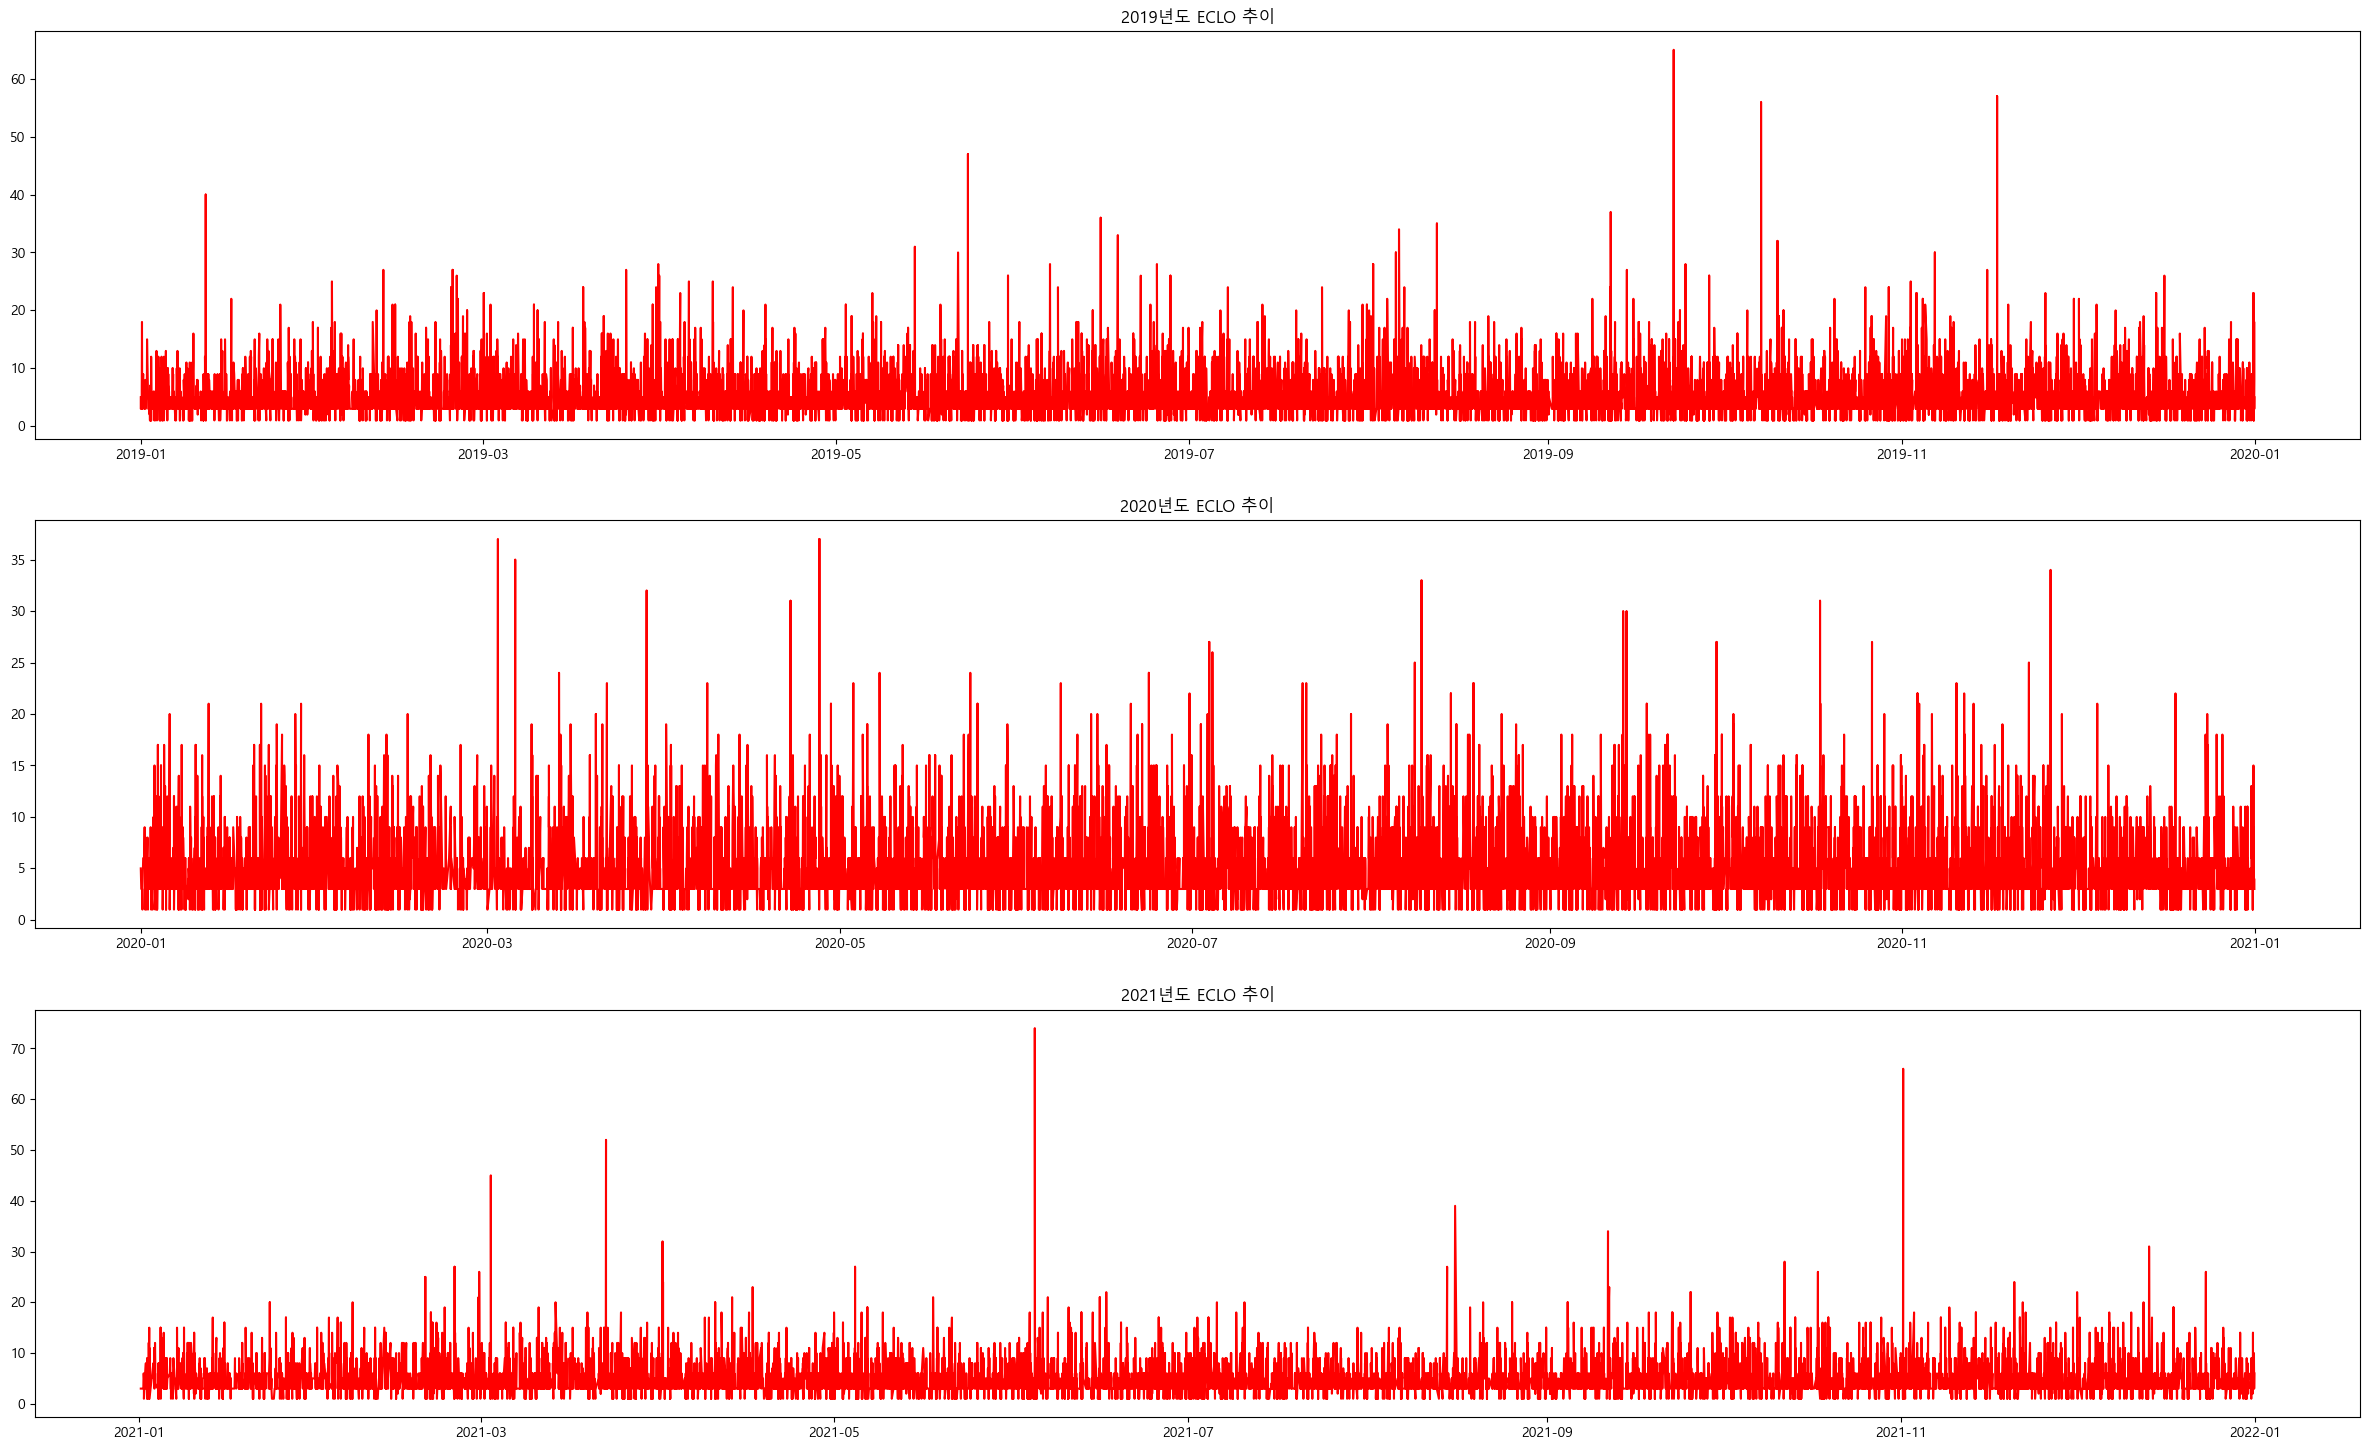

In [87]:
fig, axes = plt.subplots(figsize=(30,18), nrows=3, ncols=1)

plt.rcParams["font.family"] = "Malgun Gothic"

for i in range(2019, 2022) : 
    ax = axes[(i-2019)]
    year_eclo = df_train_join[df_train_join["사고일시"].dt.year==i]
    ax.plot(year_eclo["사고일시"], year_eclo["ECLO"], color="red")
    ax.set_title(str(i)+"년도 ECLO 추이")

plt.show()

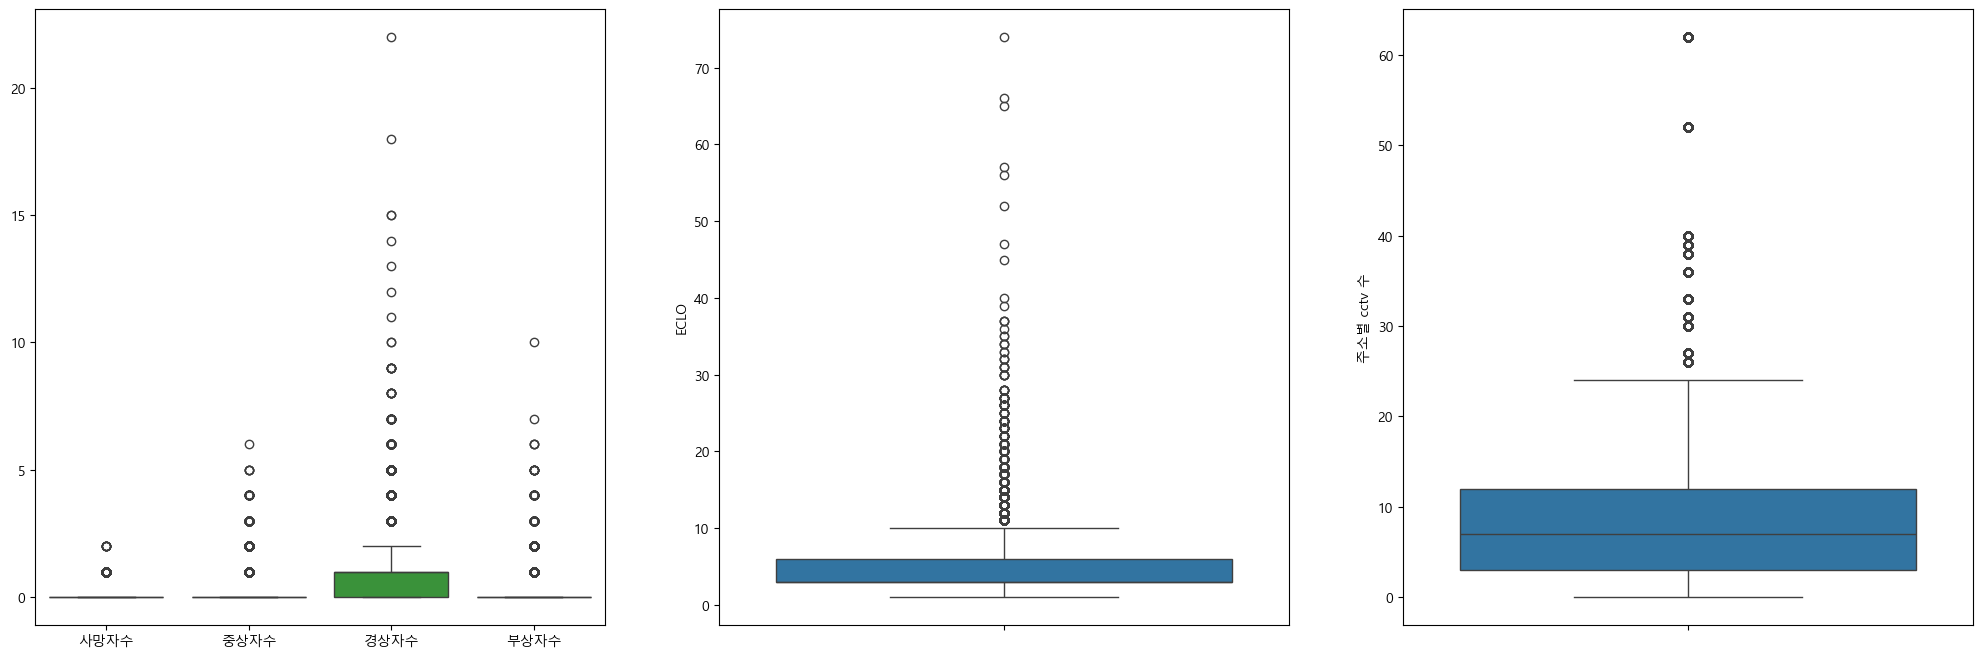

In [88]:
# 숫자 컬럼의 box-plot

fig, axes = plt.subplots(figsize=(25,8), nrows=1, ncols=3)
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

add_infra = df_train_join.groupby("시군구")[["주소별 cctv 수"]].mean()

sns.boxplot(df_train_join.select_dtypes("number").iloc[:,0:4], ax=axes[0])
sns.boxplot(df_train_join.select_dtypes("number").iloc[:,4], ax=axes[1])
# sns.boxplot(add_infra[["주소별 cctv 수", "주소별 어린이 보호구역 수",'주소별 어린이 보호구역 cctv 수']], ax=axes[2])
sns.boxplot(df_train_join.select_dtypes("number").iloc[:,5], ax=axes[2])

plt.show()

"사망" 이란 교통사고 발생시로부터 30일이내에 사망한 경우. (99년까지는 72시간 이내)  
"중상" 이란 교통사고로 인하여 3주 이상의 치료를 요하는 부상을 입은 경우.  
"경상" 이란 교통사고로 인하여 5일 이상 3주 미만의 치료를 요하는 부상을 입은 경우.  
"부상신고" 란 교통사고로 인하여 5일 미만의 치료를 요하는 부상을 입은 경우.  

'측면 충돌'은 차가 옆에서 박은 것  
'추돌'은 뒤에서 박은 것(안전거리 미확보)  
'정면 추돌'은 앞에서 박은 것

---

사고에 따른 피해자 수를 살펴보면,  
  
사고에 따라 부상의 경우가 다르기 때문에 대부분의 값이 0인 경우를 알 수 있음(그렇기 때문에 피해자 수가 Q3 + 1.5iqr을 벗어나는 값이 많아 보임).  
  
그러나 차량의 수용 인원이나 주위의 유동 인구, 사고의 규모에 따라 피해자의 수가 달라짐을 확인할 수 있음.  
  
경상자의 경우 20명이 넘는 피해자가 있는 경우도 있는데, 아마 추돌 사고나 버스 등에 대형 차량에 의한 사고로 보임.  
  
**ECLO = 사망자수 * 10 + 중상자수 * 5 + 경상자수 * 3 + 부상자수 * 1**  
  
ECLO 식은 위와 같은데,  
  
데이터 분포의 75%까지 6의 값인 것을 유추해보면  
  
중상자 1.2명, 경상자 2명, 부상자 6명 등으로 생각할 수 있음.  
  
부상과 경상까지 생각한다면 75% 정도가 큰 사고가 아님을 알 수 있지만,  
  
중상과 경상만으로도 ECLO 값이 6을 초과할 수 있기 때문에  
  
Q3을 임의로 ECLO의 기준으로 삼음

---

교통 사고 예방을 위한 인프라의 수를 살펴봤을 때,  
  
대부분은 좌로 치우친 그래프를 확인할 수 있는데 이는 각 지역의 인구수나 소득 수준에 비례할 것이라고 생각한다.  
  
인구 수에 비례한다고 했을 때 인구 밀도가 높지 않은 지역 혹은, 차량의 유입이 없는 지역은 cctv가 없을 가능성이 크다.

---

object 타입의 데이터 분포를 시각화 하기 전에 사고 일시를 월과 시간대로 나눠  
  
계절과 시간대를 구분하려고 한다.

In [24]:
def season_time(dataframe) : 
    """
    사고 발생 시각을 범주화
    """

    dataframe["사고일시"] = pd.to_datetime(dataframe["사고일시"], format="%Y-%m-%d %H:%M:%S")

    dataframe["사고 연도"] = dataframe["사고일시"].dt.strftime("%Y").astype(int)
    dataframe["사고 월"] = dataframe["사고일시"].dt.strftime("%m").astype(int)
    dataframe["사고 시각"] = dataframe["사고일시"].dt.strftime("%H").astype(int)

    dataframe["사고 계절"] = 0
    dataframe["사고 시간대"] = 0

    for r in range(dataframe.shape[0]) : 

        # 각 사고 월을 계절로 치환
        if (dataframe.loc[r,"사고 월"] >= 3) & (dataframe.loc[r,"사고 월"] < 6) : 
            dataframe.loc[r,"사고 계절"] = "봄"
        elif (dataframe.loc[r,"사고 월"] >= 6) & (dataframe.loc[r,"사고 월"] < 9) : 
            dataframe.loc[r,"사고 계절"] = "여름"
        elif (dataframe.loc[r,"사고 월"] >= 9) & (dataframe.loc[r,"사고 월"] < 12) : 
            dataframe.loc[r,"사고 계절"] = "가을"
        else : 
            dataframe.loc[r,"사고 계절"] = "겨울"

        
        # 각 사고 시각을 시간대로 치환
        if (dataframe.loc[r,"사고 시각"] >= 0) & (dataframe.loc[r,"사고 시각"] < 6) : 
            dataframe.loc[r,"사고 시간대"] = "새벽"
        elif (dataframe.loc[r,"사고 시각"] >= 6) & (dataframe.loc[r,"사고 시각"] < 12) : 
            dataframe.loc[r,"사고 시간대"] = "아침"
        elif (dataframe.loc[r,"사고 시각"] >= 12) & (dataframe.loc[r,"사고 시각"] < 18) : 
            dataframe.loc[r,"사고 시간대"] = "점심"
        else : 
            dataframe.loc[r,"사고 시간대"] = "저녁"

    return dataframe

In [25]:
df_train_join = season_time(df_train_join)

df_train_join.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 30 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   사고일시         39609 non-null  datetime64[ns]
 1   요일           39609 non-null  object        
 2   기상상태         39609 non-null  object        
 3   시군구          39609 non-null  object        
 4   도로형태         39609 non-null  object        
 5   노면상태         39609 non-null  object        
 6   사고유형         39609 non-null  object        
 7   사고유형 - 세부분류  39609 non-null  object        
 8   법규위반         39609 non-null  object        
 9   가해운전자 차종     39609 non-null  object        
 10  가해운전자 성별     39609 non-null  object        
 11  가해운전자 연령     39609 non-null  object        
 12  가해운전자 상해정도   39609 non-null  object        
 13  피해운전자 차종     39609 non-null  object        
 14  피해운전자 성별     39609 non-null  object        
 15  피해운전자 연령     39609 non-null  object        
 16  피해운전

In [26]:
df_model_join = season_time(df_model_join)

df_model_join

사고일시   요일 기상상태            시군구         도로형태 노면상태  사고유형  \
0     2019-01-01 00:00:00  화요일   맑음   대구광역시 중구 대신동     단일로 - 기타   건조  차대사람   
1     2019-01-01 00:00:00  화요일   흐림  대구광역시 달서구 감삼동     단일로 - 기타   건조  차대사람   
2     2019-01-01 01:00:00  화요일   맑음  대구광역시 수성구 두산동     단일로 - 기타   건조  차대사람   
3     2019-01-01 02:00:00  화요일   맑음   대구광역시 북구 복현동     단일로 - 기타   건조   차대차   
4     2019-01-01 04:00:00  화요일   맑음   대구광역시 동구 신암동     단일로 - 기타   건조   차대차   
...                   ...  ...  ...            ...          ...  ...   ...   
50567 2022-12-31 18:00:00  토요일   맑음   대구광역시 남구 대명동     단일로 - 터널   건조   차대차   
50568 2022-12-31 18:00:00  토요일   맑음  대구광역시 수성구 시지동     단일로 - 기타   건조   차대차   
50569 2022-12-31 20:00:00  토요일   맑음  대구광역시 수성구 연호동     단일로 - 기타   건조   차대차   
50570 2022-12-31 20:00:00  토요일   맑음  대구광역시 수성구 범물동  교차로 - 교차로부근   건조   차대차   
50571 2022-12-31 21:00:00  토요일   맑음   대구광역시 동구 효목동  교차로 - 교차로부근   건조   차대차   

      주소별 cctv 수  사고 연도  사고 월  사고 시각 사고 계절 사고 시간대  
0        3.00000   2019     1      0    겨울     새벽  
1       10.00000   2019     1      0    겨울     새벽  
2        2.00000   2019     1      1    겨울     새벽  
3        6.00000   2019     1      2    겨울     새벽  
4        9.00000   2019     1      4    겨울     새벽  
...          ...    ...   ...    ...   ...    ...  
50567   62.00000   2022    12     18    겨울     저녁  
50568    4.00000   2022    12     18    겨울     저녁  
50569          0   2022    12     20    겨울     저녁  
50570    7.00000   2022    12     20    겨울     저녁  
50571    4.00000   2022    12     21    겨울     저녁  

[50572 rows x 13 columns]

In [27]:
# 사고 월과 시각을 object 타입으로 변경

df_train_join[["사고 월", "사고 시각"]] = df_train_join[["사고 월", "사고 시각"]].astype(object)
df_model_join[["사고 월", "사고 시각"]] = df_model_join[["사고 월", "사고 시각"]].astype(object)

In [93]:
object_select = df_train_join.select_dtypes("object").drop(["가해운전자 연령", "피해운전자 연령", "시군구"], axis=1)  # object 타입의 컬럼만 추출

object_select

요일 기상상태             도로형태 노면상태  사고유형 사고유형 - 세부분류       법규위반 가해운전자 차종  \
0      화요일   맑음         단일로 - 기타   건조  차대사람  길가장자리구역통행중    안전운전불이행       승용   
1      화요일   흐림         단일로 - 기타   건조  차대사람       보도통행중         기타       승용   
2      화요일   맑음         단일로 - 기타   건조  차대사람       차도통행중    안전운전불이행       승용   
3      화요일   맑음         단일로 - 기타   건조   차대차          추돌    안전운전불이행       승용   
4      화요일   맑음         단일로 - 기타   건조   차대차          추돌    안전운전불이행       승용   
...    ...  ...              ...  ...   ...         ...        ...      ...   
39604  금요일   맑음       교차로 - 교차로안   건조   차대차        측면충돌       신호위반       승용   
39605  금요일   맑음         단일로 - 기타   건조   차대차        측면충돌    안전거리미확보       승용   
39606  금요일   맑음       교차로 - 교차로안   건조   차대차        측면충돌  교차로운행방법위반       승용   
39607  금요일   맑음          기타 - 기타   건조   차대차          추돌    안전운전불이행       승용   
39608  금요일   맑음  단일로 - 지하차도(도로)내   건조   차대차        측면충돌    안전운전불이행       승용   

      가해운전자 성별 가해운전자 상해정도 피해운전자 차종 피해운전자 성별 피해운전자 상해정도 가해연령대 피해연령대 사고 월 사고 시각  \
0            여       상해없음      보행자        여         중상   50대   60대    1     0   
1            남       상해없음      보행자        남         경상   30대   60대    1     0   
2            남       상해없음      보행자        남         경상   60대   30대    1     1   
3            남       상해없음       승용        남         중상   40대   30대    1     2   
4            남       상해없음       승용        남         경상   20대   50대    1     4   
...        ...        ...      ...      ...        ...   ...   ...  ...   ...   
39604        여       상해없음       이륜        남         경상   50대   20대   12    19   
39605        여       상해없음       승용        남         경상   50대   50대   12    19   
39606        남         중상       승용        남         중상   50대   70대   12    21   
39607        남       상해없음       승용        여         경상   30대   50대   12    22   
39608        남       상해없음       승용        남         경상   20대   30대   12    23   

      사고 계절 사고 시간대  
0        겨울     새벽  
1        겨울     새벽  
2        겨울     새벽  
3        겨울     새벽  
4        겨울     새벽  
...     ...    ...  
39604    겨울     저녁  
39605    겨울     저녁  
39606    겨울     저녁  
39607    겨울     저녁  
39608    겨울     저녁  

[39609 rows x 19 columns]

object 타입의 히스토그램을 살펴보면

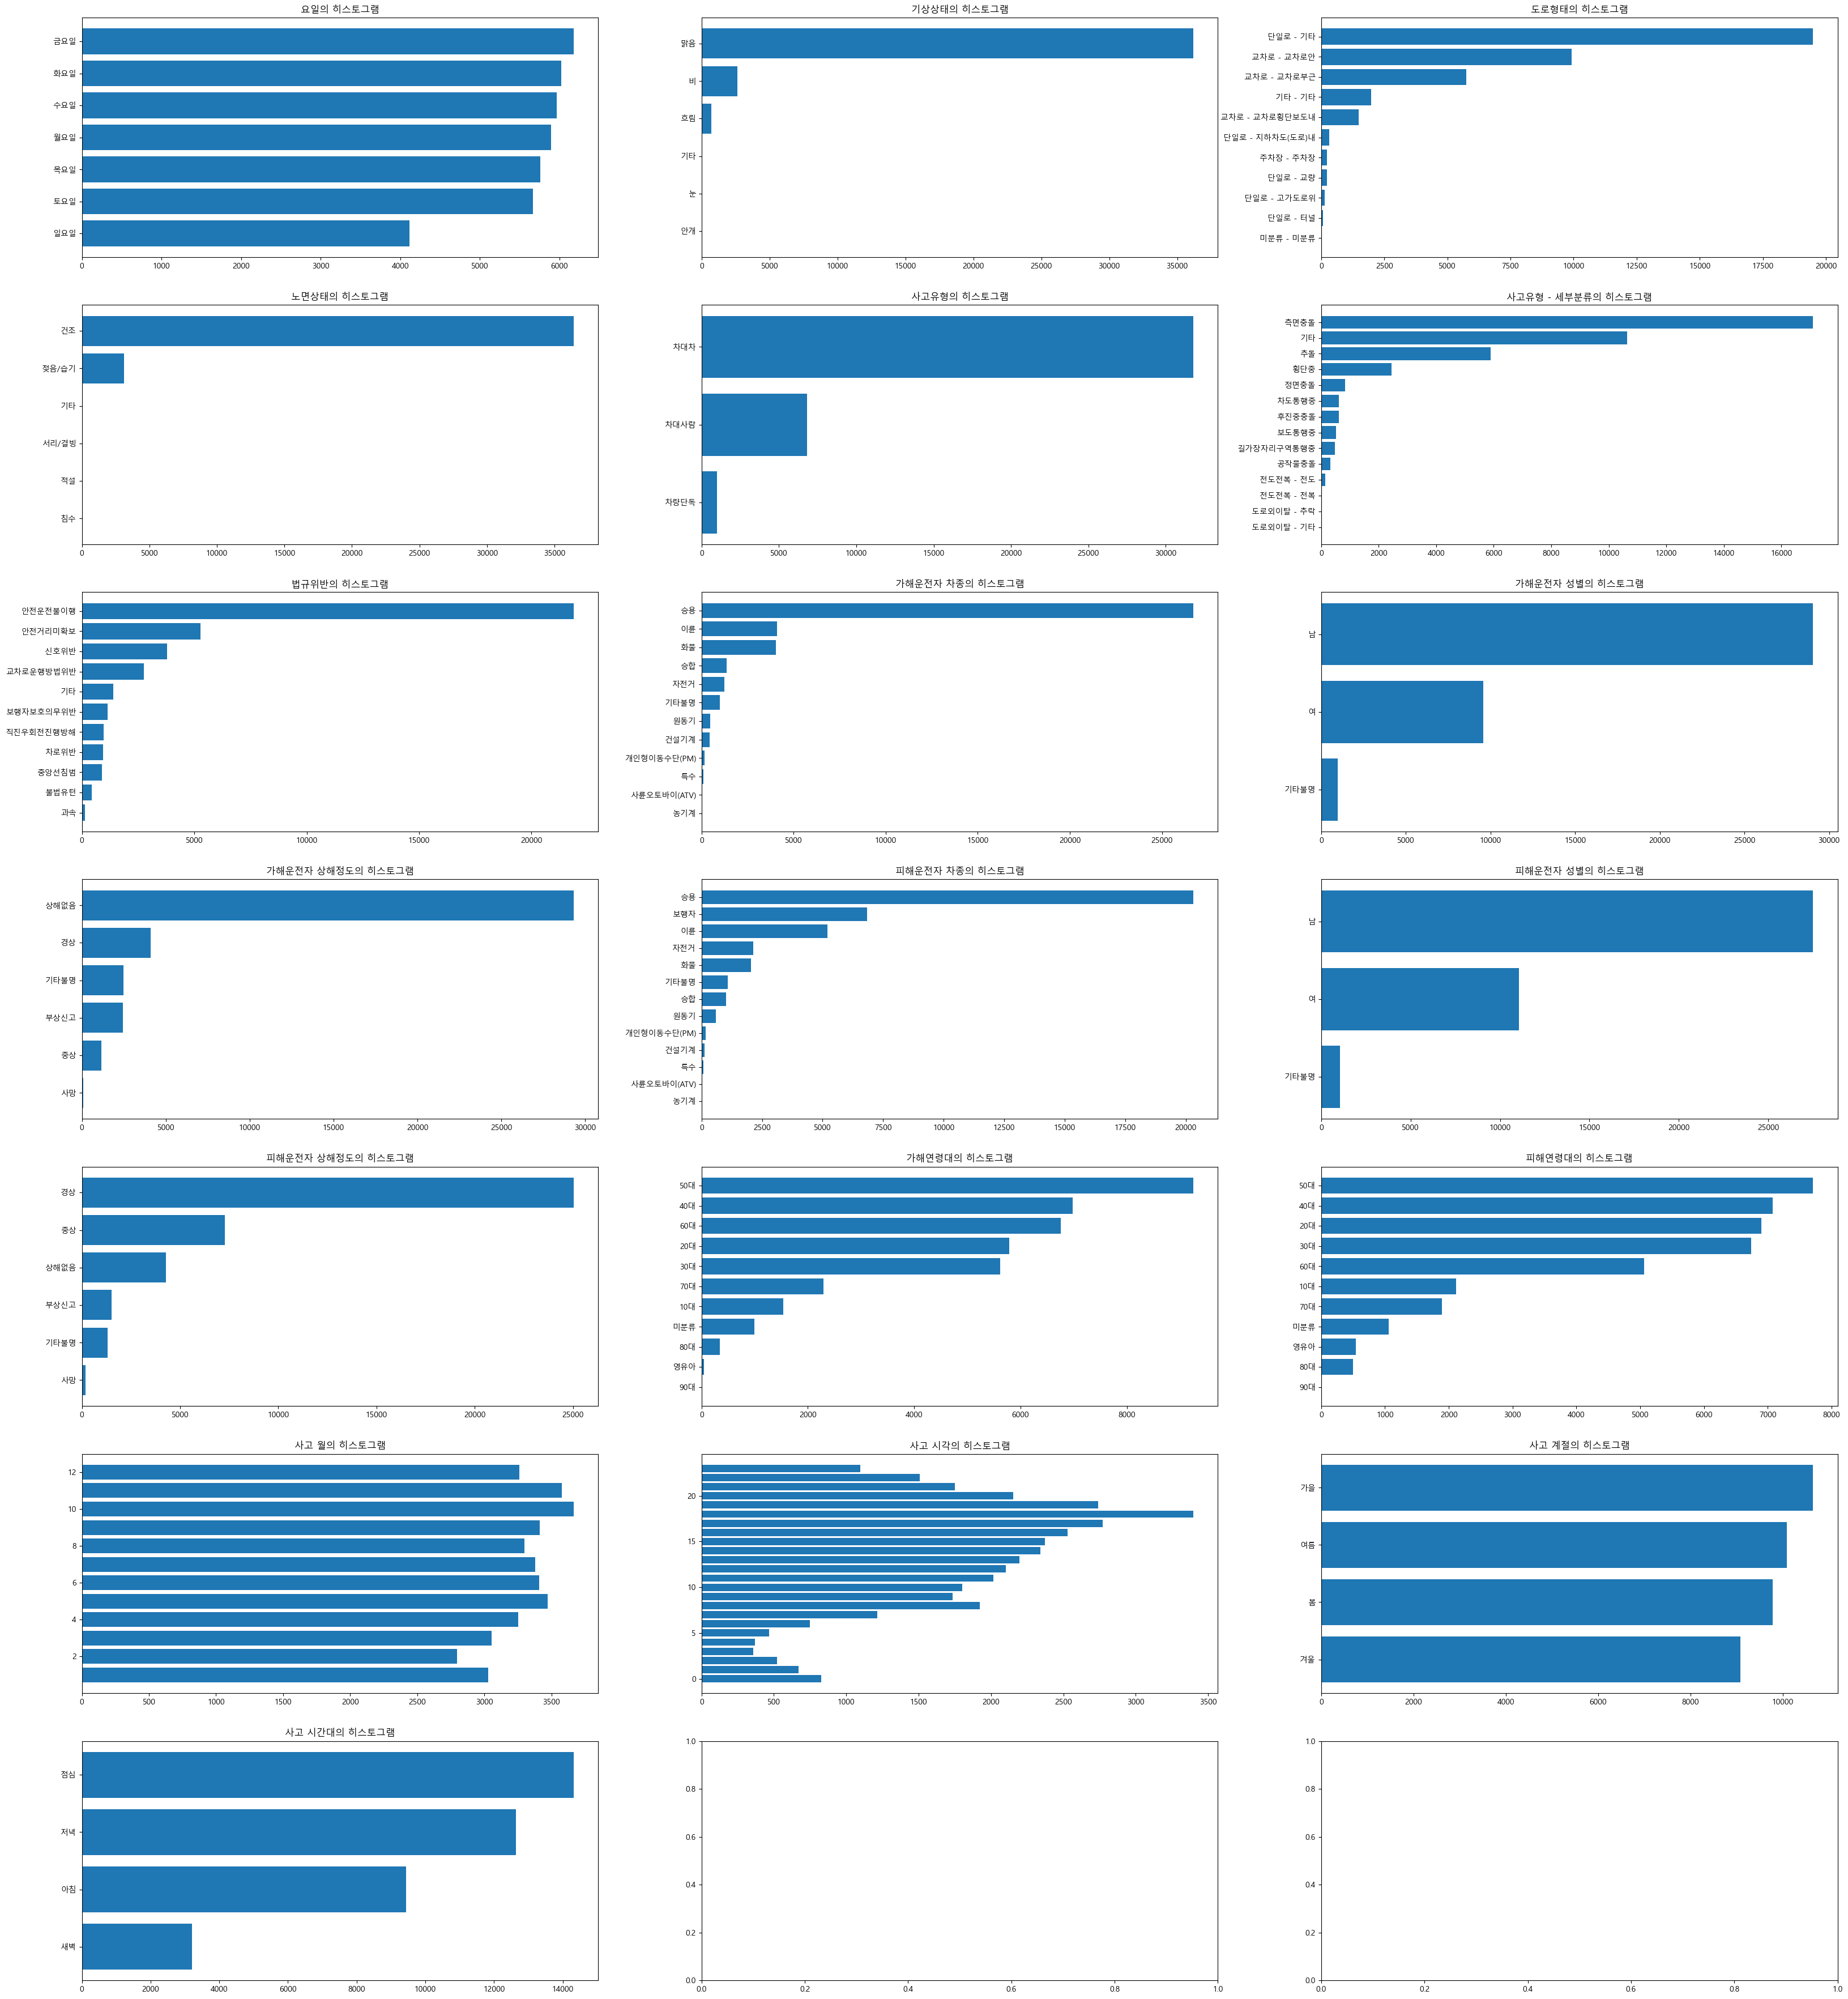

In [94]:
fig, axes = plt.subplots(figsize=(40,45), nrows=7, ncols=3)
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

col_ob_sel = object_select.columns

for L in range(len(col_ob_sel)) : 
    ax = axes[L//3][L%3]
    obj = object_select.iloc[:,L].value_counts(ascending=True)
    # ax.hist(object_select.iloc[:,L], color="lightgreen", align="left")
    ax.barh(obj.index, obj)
    ax.set_title(col_ob_sel[L]+"의 히스토그램")

plt.show()

하나하나 살펴보면  
  
- 요일 : 일요일을 제외하면, 요일에 따른 사고는 큰 차이가 없어 보임
- 기상 상태 : 날씨가 안 좋을 때보다 날씨가 좋을 때 사고가 많이 일어남 >> 날씨가 안 좋아서 더욱 조심 or 날씨가 맑을 때 교통량이 많음
- 노면 상태 : 건조할 때 사고가 많음 >> 이는 기상 상태와 연관성을 보이므로 둘 중 하나의 변수 제거 고려
- 사고 유형 : '차대차'가 가장 많음
- 가해 운전자 차종 : 업무용 차보다 승용차가 압도적으로 많음 ↔ 화물이나 이륜도 어느 정도 비율을 차지
- 피해 운전자 차종 : 승용차가 많음 >> 사고가 차대차가 많기 때문
- 가해 운전자 / 피해 운전자 성별 : 남자가 많음 >> 해당 도시에 운전 면허를 가진 사람이 남자가 많을 가능성 ↔ 여성이 운전을 조금 더 조심하게 할 가능성
- 가해 운전자 / 피해 운전자 상해 정도 : 가해 운전자는 상해가 없을 수 있으나 피해 운전자는 경상을 입은 경우가 많음
- 사고 계절 : 계절별 큰 차이는 없으나, 가을이 가장 많고 겨울이 적은 것을 봤을 때 교통량의 차이로 보임
- 사고 시간대 : 새벽이 제일 적고 점심이 제일 많은 것으로 보아 교통량의 차이로 보임. 특히 17~19시가 많은 것을 보아 퇴근 시간대 사고 많이 나는 것으로 보임

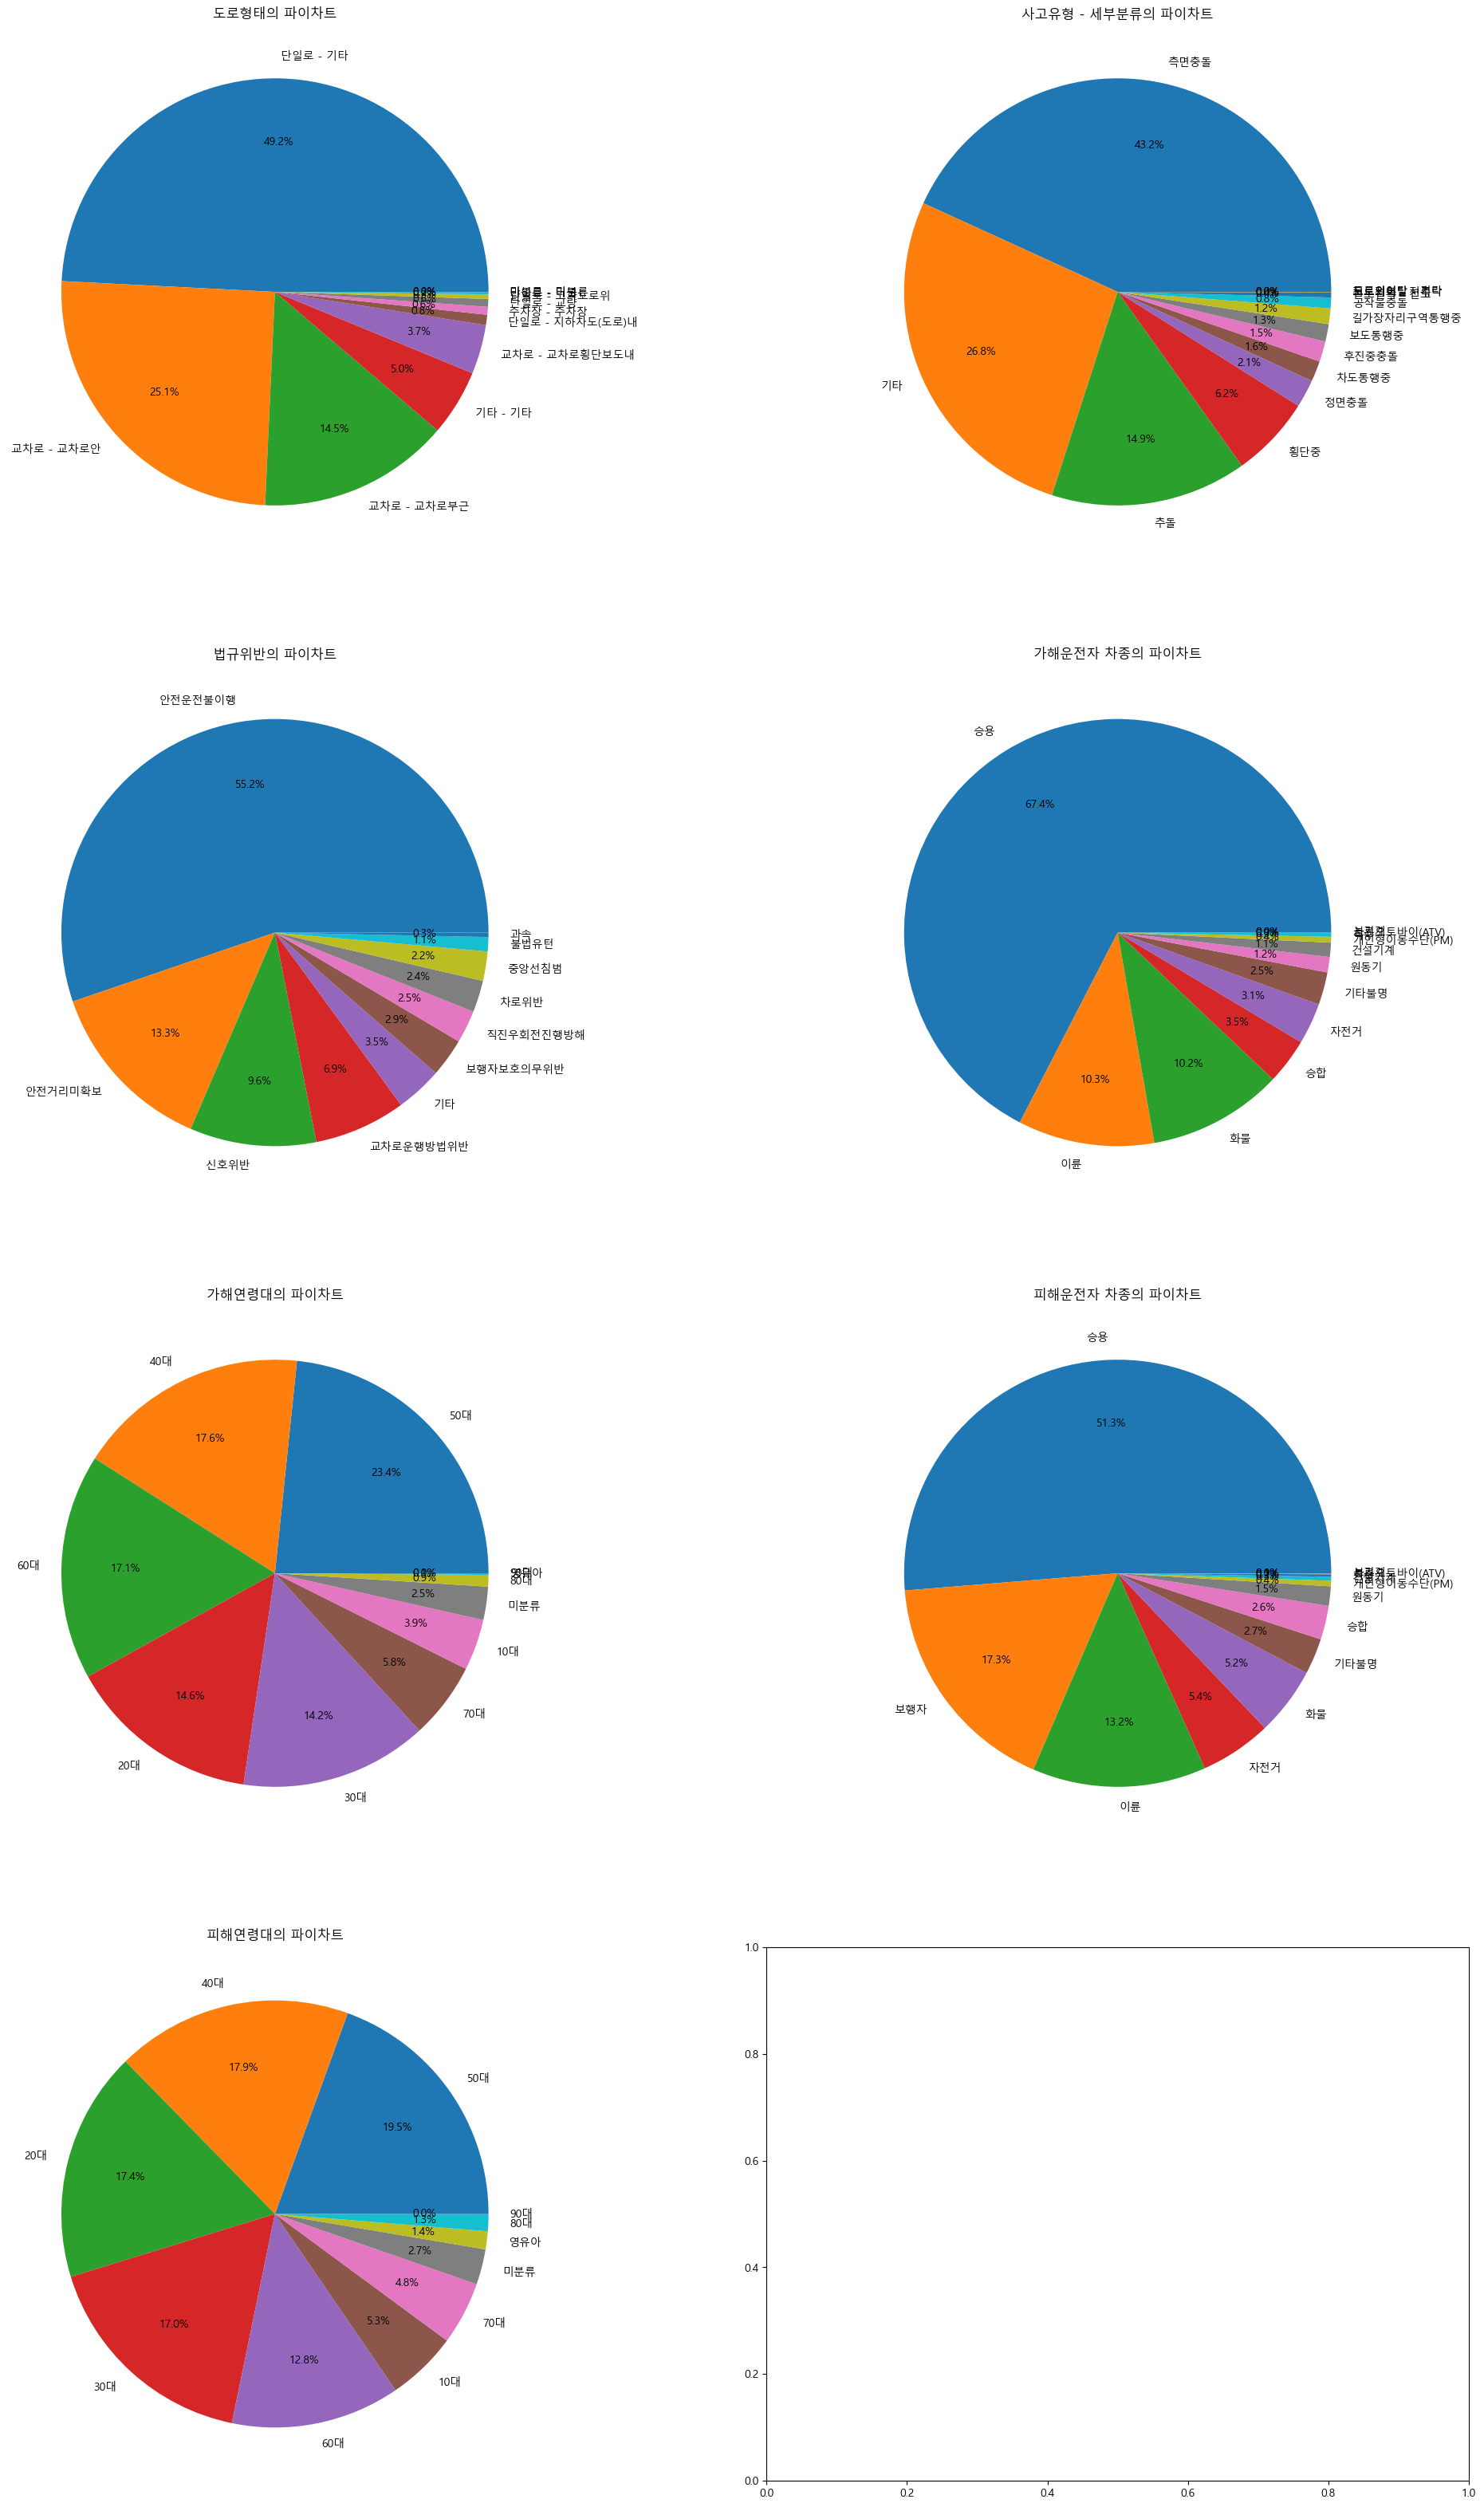

In [95]:
fig, axes = plt.subplots(figsize=(25,40), nrows=4, ncols=2)
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

col_ob_sel = object_select.columns

List_pie = ['도로형태', '사고유형 - 세부분류', '법규위반', '가해운전자 차종', '가해연령대', '피해운전자 차종', '피해연령대']

for L in range(len(List_pie)) : 
    ax = axes[L//2][L%2]

    val_cnt = df_train_join[List_pie[L]].value_counts()

    ax.pie(val_cnt, labels=val_cnt.index, pctdistance=0.7, autopct="%.1f%%")
    ax.set_title(List_pie[L]+"의 파이차트")
    # ax.legend(loc="upper right")

plt.show()

- 도로형태 : 단일로가 제일 많고, 그 다음 교차로 안이 두 번째로 사고가 많음
- 사고유형 - 세부분류 : 측면 충돌이 제일 많고, 기타가 2위, 추돌이 3위 >> 단일로나 교차로에서 측면 충돌이나 추돌이 일어날 가능성이 큼
- 법규위반 : 안전운전 불이행이 가장 많고, 안전거리 미확보가 그 다음  
(안전운전불이행 : 휴대전화, 담배, 라디오 조작, 졸음운전, 전방 주시 태만 사고, 제동장치 조작 불량 사고, 핸들 과대조작 사고 등)
- 가해 연령대 : 50대가 제일 많고 그 뒤로 40대, 60대 >> 차가 있을 확률이 높은 연령대가 사고를 많이 냄
- 피해 연령대 : 50대가 제일 많고 그 뒤로 40대, 20대

종합적으로  
  
1. 언제 : 여름이나 겨울, 퇴근 시간대
2. 어디서 : 단일로나 교차로
3. 누가 : 40~60대 남성
4. 무엇을 : 측면 충돌 혹은 추돌
5. 어떻게 : 안전 운전 불이행 혹은 안전 거리 미확보
6. 왜 : ??

같은 이유로 사고가 날 수 있음

### 카이제곱 검정

가해 운전자의 개인 정보를 알기는 어려우나,  
  
사고가 많이 나는 조건을 안다면,  
  
해당 지역에 사고가 날지 안 날지 예측할 수 있음

---

범주형 데이터들이 ECLO와 독립적인지 아닌지를 판단할 필요가 있음  
  
ECLO 기준은 임의로 설정함 

In [28]:
Q1 = df_train["ECLO"].quantile(0.25)
Q2 = df_train["ECLO"].quantile(0.5)
Q3 = df_train["ECLO"].quantile(0.75)

iqr = Q3 - Q1
Q_min = Q1 - (1.5 * iqr)
Q_max = Q3 + (1.5 * iqr)

print("1분위수 =", Q1)
print("중앙값 =", Q2)
print("3분위수 =", Q3)
print("iqr 계산을 통한 최소값 =", Q_min)
print("iqr 계산을 통한 최대값 =", Q_max)

1분위수 = 3.0
중앙값 = 3.0
3분위수 = 6.0
iqr 계산을 통한 최소값 = -1.5
iqr 계산을 통한 최대값 = 10.5


최소치는 음수이므로 고려하지 않고, 1분위수와 중앙값이 동일하므로  
  
1. ~ 중앙값
2. 중앙값 ~ 3분위
3. 3분위 ~ iqr 계산을 통한 최대값(10.5 >> 10으로 계산)
4. iqr 계산을 통한 최대값 ~  
  
총 4가지 범주로 나눠 생각함

In [277]:
def chi_obj(dataframe, col : str) : 

    chi_list = []
    
    q2 = 3
    q3 = 6
    qmax = 10

    uni = dataframe[col].unique()

    for u in uni : 

        obj_list = []

        for i in range(4) : 
            if i==0 : 
                cnt = dataframe[(dataframe["ECLO"] <= 3) & (dataframe[col] == u)][col].shape[0]
                obj_list.append(cnt)
            elif i==1 : 
                cnt = dataframe[(dataframe["ECLO"] > 3) & (dataframe["ECLO"] <= 6) & (dataframe[col] == u)][col].shape[0]
                obj_list.append(cnt)
            elif i==2 : 
                cnt = dataframe[(dataframe["ECLO"] > 6) & (dataframe["ECLO"] <= 10) & (dataframe[col] == u)][col].shape[0]
                obj_list.append(cnt)
            else : 
                cnt = dataframe[(dataframe["ECLO"] > 10) & (dataframe[col] == u)][col].shape[0]
                obj_list.append(cnt)

        chi_list.append(obj_list)

    chi = np.array(chi_list)   # 성별에 따른 사고를 낸 사람과 내지 않은 사람을 구분

    print(chi)

    result = chi2_contingency(chi)
    
    print("p-value :",result[1])

    if result[1] <= 0.05 : 
        print("유의수준 5%에서 p-value가 0.05보다 작으므로 귀무가설 기각, 대립가설 채택, "+col+"은 ECLO와 독립적이라고 말할 수 없습니다.")
    else : 
        print("유의수준 5%에서 p-value가 0.05보다 작지않으므로 귀무가설 채택, "+col+"은 ECLO와 독립적입니다.")

In [98]:
# 범주형 컬럼

object_select.columns

Index(['요일', '기상상태', '도로형태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반', '가해운전자 차종',
       '가해운전자 성별', '가해운전자 상해정도', '피해운전자 차종', '피해운전자 성별', '피해운전자 상해정도', '가해연령대',
       '피해연령대', '사고 월', '사고 시각', '사고 계절', '사고 시간대'],
      dtype='object')

In [99]:
chi_obj(dataframe=df_train_join, col="요일")

[[3315 1916  505  287]
 [3274 1906  511  278]
 [3225 1783  502  249]
 [3438 1917  534  290]
 [2954 1769  578  369]
 [1988 1333  445  348]
 [3209 1904  479  303]]
p-value : 9.056269961826512e-31
유의수준 5%에서 p-value가 0.05보다 작으므로 귀무가설 기각, 대립가설 채택, 요일은 ECLO와 독립적이라고 말할 수 없습니다.


In [100]:
chi_obj(dataframe=df_train_join, col="기상상태")

[[19598 11436  3258  1889]
 [  384   242    55    48]
 [   25    21     6     4]
 [ 1388   824   233   182]
 [    3     4     0     1]
 [    5     1     2     0]]
p-value : 0.0260667935690098
유의수준 5%에서 p-value가 0.05보다 작으므로 귀무가설 기각, 대립가설 채택, 기상상태은 ECLO와 독립적이라고 말할 수 없습니다.


In [101]:
chi_obj(dataframe=df_train_join, col="도로형태")

[[10912  5949  1611  1013]
 [ 4844  3300  1146   641]
 [ 1239   597   115    35]
 [   28    13    10    13]
 [  175    96    27    11]
 [  115    76    28    13]
 [  788   594    68    24]
 [  165    57    11     3]
 [ 3065  1806   518   357]
 [   67    37    20    14]
 [    5     3     0     0]]
p-value : 3.5279063360438857e-82
유의수준 5%에서 p-value가 0.05보다 작으므로 귀무가설 기각, 대립가설 채택, 도로형태은 ECLO와 독립적이라고 말할 수 없습니다.


In [102]:
chi_obj(dataframe=df_train_join, col="노면상태")

[[19723 11506  3286  1905]
 [ 1630   990   264   216]
 [   13     9     2     1]
 [   33    22     1     2]
 [    1     1     1     0]
 [    3     0     0     0]]
p-value : 0.020681910643964
유의수준 5%에서 p-value가 0.05보다 작으므로 귀무가설 기각, 대립가설 채택, 노면상태은 ECLO와 독립적이라고 말할 수 없습니다.


In [103]:
chi_obj(dataframe=df_train_join, col="사고유형")

[[ 4120  2459   227    27]
 [16684  9774  3256  2071]
 [  599   295    71    26]]
p-value : 1.7779282583197334e-176
유의수준 5%에서 p-value가 0.05보다 작으므로 귀무가설 기각, 대립가설 채택, 사고유형은 ECLO와 독립적이라고 말할 수 없습니다.


In [104]:
chi_obj(dataframe=df_train_join, col="사고 월")

[[1627 1002  248  153]
 [1513  864  253  166]
 [1591  984  302  175]
 [1717 1036  317  181]
 [1878 1126  300  170]
 [1885 1034  295  193]
 [1837 1044  316  184]
 [1791 1027  312  170]
 [1890 1032  303  188]
 [1963 1204  301  198]
 [1875 1149  350  203]
 [1836 1026  257  143]]
p-value : 0.02077184994107009
유의수준 5%에서 p-value가 0.05보다 작으므로 귀무가설 기각, 대립가설 채택, 사고 월은 ECLO와 독립적이라고 말할 수 없습니다.


In [105]:
chi_obj(dataframe=df_train_join, col="사고 계절")

[[4976 2892  758  462]
 [5186 3146  919  526]
 [5513 3105  923  547]
 [5728 3385  954  589]]
p-value : 0.08473435791907419
유의수준 5%에서 p-value가 0.05보다 작지않으므로 귀무가설 채택, 사고 계절은 ECLO와 독립적입니다.


In [106]:
chi_obj(dataframe=df_train_join, col="사고 시각")

[[ 413  244  113   58]
 [ 321  205   82   61]
 [ 233  167   76   44]
 [ 168  137   32   30]
 [ 219  153   64   31]
 [ 370  281   69   30]
 [ 984  598  140   81]
 [1114  640  167   95]
 [1312  722  202  106]
 [1909 1056  268  165]
 [1487  882  236  134]
 [1191  656  198  109]
 [ 787  467  147  105]
 [ 636  419   99   59]
 [1067  599  163   95]
 [1226  648  215  109]
 [1287  738  215  134]
 [1401  787  204  137]
 [1552  857  227  136]
 [ 538  367  129   62]
 [ 165  112   41   38]
 [1149  669  174  112]
 [ 907  565  175  102]
 [ 967  559  118   91]]
p-value : 9.311187535697249e-24
유의수준 5%에서 p-value가 0.05보다 작으므로 귀무가설 기각, 대립가설 채택, 사고 시각은 ECLO와 독립적이라고 말할 수 없습니다.


In [107]:
chi_obj(dataframe=df_train_join, col="사고 시간대")

[[1519 1018  408  262]
 [5138 3096  756  451]
 [7927 4421 1237  734]
 [6819 3993 1153  677]]
p-value : 9.06553275291412e-29
유의수준 5%에서 p-value가 0.05보다 작으므로 귀무가설 기각, 대립가설 채택, 사고 시간대은 ECLO와 독립적이라고 말할 수 없습니다.


사고가 난 뒤 알 수 있는 정보(가해 운전자와 피해 운전자의 정보)는 미래에 대한 정보이므로 학습에 사용할 수 없습니다.  
  
그 이외의 범주형 데이터를 살펴봤을 때,  
  
사고 계절을 제외하고는  
  
전부 ECLO와 독립적이지 않다고 가정할 수 있는데  
  
특이한 점은 사고가 발생한 계절로 크게 범주화했을 때는 ECLO와 독립적이지만,  
  
월 단위로 봤을 때는 유의하다는 것입니다.  
  
대구라는 지역의 날씨나 행사 혹은 여러 요인이 영향을 미칠 수 있다고 볼 수 있습니다.  
  
사고 계절은 변수에서 제거하겠습니다.

In [29]:
# 사고 계절 제거

df_train_join.drop("사고 계절", axis=1, inplace=True)

df_model_join.drop("사고 계절", axis=1, inplace=True)

### 상관성 검정

날씨와 노면 상태, cctv 수, 어린이 보호구역의 수, 어린이 보호구역의 cctv 수, 보안등 수에 따른 ECLO의 상관 계수를 확인.  
  
먼저 날씨는 맑을 때를 1, 흐릴 때를 2, 비 / 안개 /눈을 3으로 설정(날씨가 가혹할수록 가중).  
  
'기타'의 날씨를 가늠할 수 없으므로, 적당한 순위인 '흐림'가 동등하게 설정('기타'=2).
  
노면은 건조를 1, 젖음/습기를 2, 서리/결빙을 3, 침수와 적설을 4로 설정.  
  
서리/결빙을 젖음/습기보다 높게 설정한 이유는  
  
대구/경북 지역은 온도가 높아 추위 관련 재해에 취약하다고 판단했기 때문.  
  
노면 상태의 '기타'도 날씨와 같은 이유로 2로 설정

In [30]:
# 기상상태(날씨) 라벨링

df_train_join["기상상태_label"] = df_train_join["기상상태"].replace(["맑음", "흐림", '기타', '비', '안개', '눈'], [1,2,2,3,3,3])
df_model_join["기상상태_label"] = df_model_join["기상상태"].replace(["맑음", "흐림", '기타', '비', '안개', '눈'], [1,2,2,3,3,3])

df_train_join["기상상태_label"].value_counts()

기상상태_label
1    36181
3     2643
2      785
Name: count, dtype: int64

In [31]:
# 노면 상태 라벨링

df_train_join["노면상태_label"] = df_train_join["노면상태"].replace(['건조', '기타', '젖음/습기', '서리/결빙', '침수', '적설'],[1,2,2,3,3,3])
df_model_join["노면상태_label"] = df_model_join["노면상태"].replace(['건조', '기타', '젖음/습기', '서리/결빙', '침수', '적설'],[1,2,2,3,3,3,])

df_model_join["노면상태_label"].value_counts()

노면상태_label
1    46814
2     3717
3       41
Name: count, dtype: int64

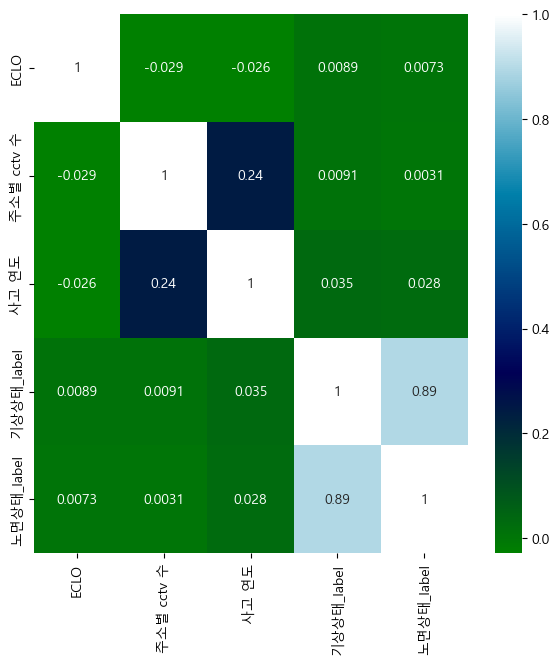

In [111]:
# 숫자 타입의 컬럼만 추출후 상관 관계 분석
# 순위 척도가 포함돼 있으므로 스피어만 상관 계수 사용

number_select = df_train_join.select_dtypes("number").drop(['사망자수','중상자수','경상자수','부상자수'], axis=1)

number_select_corr = number_select.corr("spearman")

plt.figure(figsize=(7,7))
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["font.family"] = "Malgun Gothic"

sns.heatmap(number_select_corr, annot=True, cmap='ocean')

plt.show()

기상상태_label - 노면상태_label(0.89) : 기상 상태가 안 좋으면 노면 상태도 안 좋을 것이기 때문에, 둘 사이의 강한 양의 상관 관계 → 둘 중 하나 제거 고려

ECLO는 어떠한 변수와도 상관성을 가지지 않는데, 사고가 특정 조건보다는 복합적인 요소로 인해 일어나기 때문으로 생각함

### 공간데이터 열기

#### 법정 행정 코드 api

In [344]:
import requests

key = "repbMvjCXw96iTs6wjKM3Htm1H480VcdawruKmikMmOYZF8aVD/rJDkfGoyLeTuS5Y1KEOzUrwwPIu87UQ9LbQ=="

url = 'http://apis.data.go.kr/1741000/StanReginCd/getStanReginCdList'
params ={'serviceKey' : key, 'pageNo' : '1', 'numOfRows' : '1000', 'type' : 'json', 'locatadd_nm' : '대구광역시' }

response = requests.get(url, params=params)
print(response.text)

{"StanReginCd":[{"head":[{"totalCount":409},{"numOfRows":"1000","pageNo":"1","type":"JSON"},{"RESULT":{"resultCode":"INFO-0","resultMsg":"NOMAL SERVICE"}}]},{"row":[{"region_cd":"2717010900","sido_cd":"27","sgg_cd":"170","umd_cd":"109","ri_cd":"00","locatjumin_cd":"2717010900","locatjijuk_cd":"2717010900","locatadd_nm":"대구광역시 서구 원대동3가","locat_order":9,"locat_rm":"","locathigh_cd":"2717000000","locallow_nm":"원대동3가","adpt_de":""},{"region_cd":"2720000000","sido_cd":"27","sgg_cd":"200","umd_cd":"000","ri_cd":"00","locatjumin_cd":"2720000000","locatjijuk_cd":"2720000000","locatadd_nm":"대구광역시 남구","locat_order":4,"locat_rm":"","locathigh_cd":"2700000000","locallow_nm":"남구","adpt_de":""},{"region_cd":"2717010700","sido_cd":"27","sgg_cd":"170","umd_cd":"107","ri_cd":"00","locatjumin_cd":"2717010700","locatjijuk_cd":"2717010700","locatadd_nm":"대구광역시 서구 원대동1가","locat_order":7,"locat_rm":"","locathigh_cd":"2717000000","locallow_nm":"원대동1가","adpt_de":""},{"region_cd":"2717010800","sido_cd":"27","s

In [357]:
contents = response.text

In [356]:
json_ob = json.loads(contents)

pprint.pprint(json_ob)

{'StanReginCd': [{'head': [{'totalCount': 409},
                           {'numOfRows': '1000', 'pageNo': '1', 'type': 'JSON'},
                           {'RESULT': {'resultCode': 'INFO-0',
                                       'resultMsg': 'NOMAL SERVICE'}}]},
                 {'row': [{'adpt_de': '',
                           'locallow_nm': '원대동3가',
                           'locat_order': 9,
                           'locat_rm': '',
                           'locatadd_nm': '대구광역시 서구 원대동3가',
                           'locathigh_cd': '2717000000',
                           'locatjijuk_cd': '2717010900',
                           'locatjumin_cd': '2717010900',
                           'region_cd': '2717010900',
                           'ri_cd': '00',
                           'sgg_cd': '170',
                           'sido_cd': '27',
                           'umd_cd': '109'},
                          {'adpt_de': '',
                           'locallow_nm': '남구',
  

In [364]:
json_data = json_ob["StanReginCd"][1]["row"]

In [376]:
region_cd = []
sido_cd = []
sgg_cd = []
umd_cd = []
ri_cd = []
locatjumin_cd = []
locatjijuk_cd = []
locatadd_nm = []
locat_order = []
locat_rm = []
locathigh_cd = []
locallow_nm = []
adpt_de = []

List_att = ['region_cd','sido_cd','sgg_cd','umd_cd',
            'ri_cd','locatjumin_cd','locatjijuk_cd',
            'locatadd_nm','locat_order','locat_rm',
            'locathigh_cd','locallow_nm','adpt_de']

In [377]:
cnt = 1
for d in json_data : 
    for l in List_att : 
        globals()[l].append(d[l])
    print(str(cnt)+"번째 저장 성공")
    cnt+=1

1번째 저장 성공
2번째 저장 성공
3번째 저장 성공
4번째 저장 성공
5번째 저장 성공
6번째 저장 성공
7번째 저장 성공
8번째 저장 성공
9번째 저장 성공
10번째 저장 성공
11번째 저장 성공
12번째 저장 성공
13번째 저장 성공
14번째 저장 성공
15번째 저장 성공
16번째 저장 성공
17번째 저장 성공
18번째 저장 성공
19번째 저장 성공
20번째 저장 성공
21번째 저장 성공
22번째 저장 성공
23번째 저장 성공
24번째 저장 성공
25번째 저장 성공
26번째 저장 성공
27번째 저장 성공
28번째 저장 성공
29번째 저장 성공
30번째 저장 성공
31번째 저장 성공
32번째 저장 성공
33번째 저장 성공
34번째 저장 성공
35번째 저장 성공
36번째 저장 성공
37번째 저장 성공
38번째 저장 성공
39번째 저장 성공
40번째 저장 성공
41번째 저장 성공
42번째 저장 성공
43번째 저장 성공
44번째 저장 성공
45번째 저장 성공
46번째 저장 성공
47번째 저장 성공
48번째 저장 성공
49번째 저장 성공
50번째 저장 성공
51번째 저장 성공
52번째 저장 성공
53번째 저장 성공
54번째 저장 성공
55번째 저장 성공
56번째 저장 성공
57번째 저장 성공
58번째 저장 성공
59번째 저장 성공
60번째 저장 성공
61번째 저장 성공
62번째 저장 성공
63번째 저장 성공
64번째 저장 성공
65번째 저장 성공
66번째 저장 성공
67번째 저장 성공
68번째 저장 성공
69번째 저장 성공
70번째 저장 성공
71번째 저장 성공
72번째 저장 성공
73번째 저장 성공
74번째 저장 성공
75번째 저장 성공
76번째 저장 성공
77번째 저장 성공
78번째 저장 성공
79번째 저장 성공
80번째 저장 성공
81번째 저장 성공
82번째 저장 성공
83번째 저장 성공
84번째 저장 성공
85번째 저장 성공
86번째 저장 성공
87번째 저장 성공
88번째 저장 성공
89번째 저장 성공
90번째 저장 성공
91번째 저장 성공
92번째 저장 

In [378]:
df_list = []

for i in List_att : 
    df_list.append(globals()[i])

df_list

[['2717010900',
  '2720000000',
  '2717010700',
  '2717010800',
  '2717010400',
  '2717010500',
  '2717010600',
  '2717010200',
  '2717010300',
  '2717000000',
  '2717010100',
  '2714014300',
  '2714014400',
  '2714014500',
  '2714014000',
  '2714014100',
  '2714014200',
  '2714013700',
  '2714013800',
  '2714013900',
  '2714013400',
  '2714013500',
  '2714013600',
  '2714013300',
  '2700000000',
  '2711000000',
  '2711010100',
  '2711010200',
  '2711010300',
  '2711010400',
  '2711010500',
  '2711010600',
  '2711010700',
  '2711010800',
  '2711010900',
  '2711011000',
  '2711011100',
  '2711011200',
  '2711011300',
  '2711011400',
  '2711011500',
  '2711011600',
  '2711011700',
  '2711011800',
  '2711011900',
  '2711012000',
  '2711012100',
  '2711012200',
  '2711012300',
  '2711012400',
  '2711012500',
  '2711012600',
  '2711012700',
  '2711012800',
  '2711012900',
  '2711013000',
  '2711013100',
  '2711013200',
  '2711013300',
  '2711013400',
  '2711013500',
  '2711013600',
  '27110

In [379]:
df_beop = pd.DataFrame(df_list).T

df_beop

0   1    2    3   4           5           6                  7   \
0    2717010900  27  170  109  00  2717010900  2717010900     대구광역시 서구 원대동3가   
1    2720000000  27  200  000  00  2720000000  2720000000           대구광역시 남구   
2    2717010700  27  170  107  00  2717010700  2717010700     대구광역시 서구 원대동1가   
3    2717010800  27  170  108  00  2717010800  2717010800     대구광역시 서구 원대동2가   
4    2717010400  27  170  104  00  2717010400  2717010400       대구광역시 서구 상리동   
..          ...  ..  ...  ...  ..         ...         ...                ...   
404  2772025025  27  720  250  25  2772025025  2772025025  대구광역시 군위군 군위읍 수서리   
405  2772025026  27  720  250  26  2772025026  2772025026  대구광역시 군위군 군위읍 사직리   
406  2772025024  27  720  250  24  2772025024  2772025024  대구광역시 군위군 군위읍 무성리   
407  2772025022  27  720  250  22  2772025022  2772025022  대구광역시 군위군 군위읍 서부리   
408  2772025023  27  720  250  23  2772025023  2772025023  대구광역시 군위군 군위읍 금구리   

    8  9           10     11        12  
0    9     2717000000  원대동3가            
1    4     2700000000     남구            
2    7     2717000000  원대동1가            
3    8     2717000000  원대동2가            
4    4     2717000000    상리동            
..  .. ..         ...    ...       ...  
404  5     2772025000    수서리  20230701  
405  6     2772025000    사직리  20230701  
406  4     2772025000    무성리  20230701  
407  2     2772025000    서부리  20230701  
408  3     2772025000    금구리  20230701  

[409 rows x 13 columns]

In [381]:
List_att_kor = ['지역코드','시도코드','시군구코드','읍면동코드','리코드','지역코드_주민',
                '지역코드_지적','지역주소명','서열','비고','상위지역코드','최하위지역명','생성일']


df_beop.columns = List_att_kor

df_beop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409 entries, 0 to 408
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   지역코드     409 non-null    object
 1   시도코드     409 non-null    object
 2   시군구코드    409 non-null    object
 3   읍면동코드    409 non-null    object
 4   리코드      409 non-null    object
 5   지역코드_주민  409 non-null    object
 6   지역코드_지적  409 non-null    object
 7   지역주소명    409 non-null    object
 8   서열       409 non-null    object
 9   비고       409 non-null    object
 10  상위지역코드   409 non-null    object
 11  최하위지역명   409 non-null    object
 12  생성일      409 non-null    object
dtypes: object(13)
memory usage: 41.7+ KB


In [383]:
# csv로 저장
df_beop.to_csv("./data/행정안전부_행정표준코드_법정동코드_대구.csv", encoding='cp949')

#### 데이터 open

<Axes: >

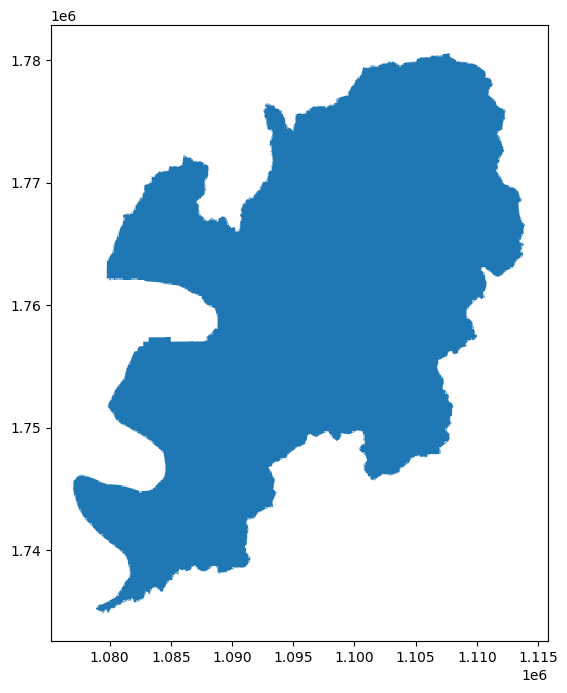

In [32]:
daegu100 = gpd.read_file("./data/external_open/대구 빅데이터 마트 데이터/0. Base/대구광역시_100.gpkg")

daegu100.plot(figsize=(8,8))

시군구 A1 코드
1. 중구 : 27110
2. 동구 : 27140
3. 서구 : 27170
4. 남구 : 27200
5. 북구 : 27230
6. 수성구 : 27260
7. 달서구 : 27290
8. 달성군 : 27710
9. 군위군 : 47720

In [73]:
def combine_sig_emd(path_origin_sig : str, path_origin_emd : str, year : int) : 

    """
    연도별 시군구 / 읍면동을 하나로 합치는 함수입니다.
    """
    sig = gpd.read_file("./data/"+path_origin_sig, encoding="cp949").to_crs(crs=4326)
    emd = gpd.read_file("./data/"+path_origin_emd, encoding="cp949").to_crs(crs=4326)

    List_sig = ['27110','27140','27170','27200','27230','27260','27290','27710','47720']

    sig2 = sig[sig["A1"].isin(List_sig)]   # 대구광역시 A1 리스트에 포함돼 있는 데이터만 추출

    sig2.rename({"A1":"A1-2"}, axis=1, inplace=True)

    sig2["A2"] = sig2["A2"].map(lambda x : x.replace("대구광역시 ", ""))



    emd["A1-2"] = emd["A1"].str[:5]   # 읍면동 데이터에서, List_sig와 비교할 수 있도록 앞 5자리 숫자 추출
    # emd.drop_duplicates(subset=["A0","A2"], keep="last", inplace=True)     # 중복된 법정동 중 최근 데이터를 남김



    emd2 = emd.merge(sig2[["A1-2",'A2']], on="A1-2")


    # emd2["연도"] = year
    emd2.rename({"A3":"일시"}, axis=1, inplace=True)

    emd2["일시"] = pd.to_datetime(emd2["일시"], format="%Y-%m-%d")

    emd2["주소"] = "대구광역시 "+emd2["A2_y"]+" "+emd2["A2_x"]

    emd2 = emd2[["주소", "일시", "geometry"]]


    emd2 = pd.DataFrame(emd2)


    return emd2

In [74]:
emd_2016_t = combine_sig_emd(path_origin_sig="AL_00_D001_20161105/AL_00_D001_20161105(SIG).shp", path_origin_emd="AL_00_D001_20161105/AL_00_D001_20161105(EMD).shp", year=2019)

emd_2016_t

주소         일시  \
0    대구광역시 수성구 삼덕동 1899-12-30   
1    대구광역시 수성구 가천동 1899-12-30   
2    대구광역시 수성구 신매동 1899-12-30   
3    대구광역시 수성구 고모동 1899-12-30   
4    대구광역시 수성구 만촌동 1899-12-30   
..             ...        ...   
207  대구광역시 군위군 산성면 1899-12-30   
208  대구광역시 군위군 군위읍 1899-12-30   
209  대구광역시 군위군 소보면 1899-12-30   
210  대구광역시 군위군 의흥면 1899-12-30   
211  대구광역시 군위군 우보면 1899-12-30   

                                              geometry  
0    POLYGON ((128.68118 35.84008, 128.68105 35.839...  
1    POLYGON ((128.67075 35.85296, 128.67166 35.852...  
2    MULTIPOLYGON (((128.71128 35.83221, 128.71091 ...  
3    POLYGON ((128.67138 35.87421, 128.67163 35.874...  
4    MULTIPOLYGON (((128.64709 35.87871, 128.64724 ...  
..                                                 ...  
207  POLYGON ((128.69673 36.08109, 128.69673 36.081...  
208  POLYGON ((128.53277 36.29585, 128.53300 36.295...  
209  POLYGON ((128.44865 36.32720, 128.45007 36.326...  
210  POLYGON ((128.67137 36.18051, 128.67139 36.180...  
211  POLYGON ((128.60696 36.16506, 128.60697 36.166...  

[212 rows x 3 columns]

In [76]:
emd_2017_t = combine_sig_emd(path_origin_sig="AL_00_D001_20171202/AL_00_D001_20171202(SIG).shp", path_origin_emd="AL_00_D001_20171202/AL_00_D001_20171202(EMD).shp", year=2019)

emd_2017_t

주소         일시  \
0     대구광역시 남구 이천동 2017-03-18   
1     대구광역시 남구 봉덕동 2017-03-07   
2     대구광역시 남구 대명동 2017-03-07   
3     대구광역시 남구 이천동 2017-03-07   
4     대구광역시 동구 불로동 2017-03-07   
..             ...        ...   
209  대구광역시 군위군 산성면 2017-03-07   
210  대구광역시 군위군 군위읍 2017-03-07   
211  대구광역시 군위군 소보면 2017-03-07   
212  대구광역시 군위군 의흥면 2017-03-07   
213  대구광역시 군위군 우보면 2017-03-07   

                                              geometry  
0    POLYGON ((128.59777 35.85582, 128.59791 35.855...  
1    POLYGON ((128.59887 35.85031, 128.59900 35.850...  
2    MULTIPOLYGON (((128.55551 35.83440, 128.55551 ...  
3    POLYGON ((128.59386 35.85478, 128.59386 35.854...  
4    POLYGON ((128.62680 35.90414, 128.62684 35.904...  
..                                                 ...  
209  POLYGON ((128.69962 36.08109, 128.69962 36.081...  
210  POLYGON ((128.53566 36.29585, 128.53589 36.295...  
211  POLYGON ((128.45154 36.32720, 128.45296 36.326...  
212  POLYGON ((128.67426 36.18051, 128.67428 36.180...  
213  POLYGON ((128.60985 36.16506, 128.60986 36.166...  

[214 rows x 3 columns]

In [77]:
emd_2018_t = combine_sig_emd(path_origin_sig="AL_00_D001_20181214/AL_00_D001_20181214(SIG).shp", path_origin_emd="AL_00_D001_20181214/AL_00_D001_20181214(EMD).shp", year=2019)

emd_2018_t

주소         일시  \
0    대구광역시 중구 태평로3가 2018-02-08   
1      대구광역시 중구 수창동 2018-02-08   
2    대구광역시 중구 동인동2가 2017-03-07   
3      대구광역시 중구 남일동 2017-03-07   
4      대구광역시 중구 달성동 2017-03-07   
..              ...        ...   
213   대구광역시 군위군 산성면 2017-03-07   
214   대구광역시 군위군 군위읍 2017-03-07   
215   대구광역시 군위군 소보면 2017-03-07   
216   대구광역시 군위군 의흥면 2017-03-07   
217   대구광역시 군위군 우보면 2017-03-07   

                                              geometry  
0    POLYGON ((128.58070 35.87889, 128.58164 35.878...  
1    POLYGON ((128.58235 35.87616, 128.58235 35.876...  
2    POLYGON ((128.60628 35.86684, 128.60616 35.866...  
3    POLYGON ((128.59237 35.86940, 128.59243 35.869...  
4    POLYGON ((128.58184 35.87336, 128.58171 35.873...  
..                                                 ...  
213  POLYGON ((128.69962 36.08109, 128.69962 36.081...  
214  POLYGON ((128.53566 36.29585, 128.53589 36.295...  
215  POLYGON ((128.45154 36.32720, 128.45296 36.326...  
216  POLYGON ((128.67426 36.18051, 128.67428 36.180...  
217  POLYGON ((128.60985 36.16506, 128.60986 36.166...  

[218 rows x 3 columns]

In [78]:
emd_2019_t = combine_sig_emd(path_origin_sig="AL_00_D001_20191207/AL_00_D001_20191207(SIG).shp", path_origin_emd="AL_00_D001_20191207/AL_00_D001_20191207(EMD).shp", year=2019)

emd_2019_t

주소         일시  \
0    대구광역시 수성구 만촌동 2019-02-21   
1    대구광역시 수성구 삼덕동 2019-02-21   
2    대구광역시 수성구 고모동 2019-02-21   
3    대구광역시 수성구 가천동 2019-02-21   
4    대구광역시 수성구 노변동 2019-02-21   
..             ...        ...   
209  대구광역시 군위군 효령면 2019-02-21   
210  대구광역시 군위군 산성면 2019-02-21   
211  대구광역시 군위군 군위읍 2019-02-21   
212  대구광역시 군위군 소보면 2019-02-21   
213  대구광역시 군위군 의흥면 2019-02-21   

                                              geometry  
0    POLYGON ((128.66157 35.85577, 128.66126 35.855...  
1    POLYGON ((128.68378 35.84094, 128.68427 35.840...  
2    POLYGON ((128.67364 35.85296, 128.67319 35.853...  
3    POLYGON ((128.68200 35.86077, 128.68268 35.861...  
4    POLYGON ((128.68919 35.83069, 128.68977 35.830...  
..                                                 ...  
209  POLYGON ((128.54441 36.16600, 128.54473 36.166...  
210  POLYGON ((128.69962 36.08109, 128.69962 36.081...  
211  POLYGON ((128.53566 36.29585, 128.53589 36.295...  
212  POLYGON ((128.45154 36.32720, 128.45296 36.326...  
213  POLYGON ((128.67426 36.18051, 128.67428 36.180...  

[214 rows x 3 columns]

In [79]:
emd_2020_t = combine_sig_emd(path_origin_sig="AL_00_D001_20201205/AL_00_D001_20201205(SIG).shp", path_origin_emd="AL_00_D001_20201205/AL_00_D001_20201205(EMD).shp", year=2020)

emd_2020_t

주소         일시  \
0    대구광역시 수성구 만촌동 2019-02-21   
1    대구광역시 수성구 삼덕동 2019-02-21   
2    대구광역시 수성구 고모동 2019-02-21   
3    대구광역시 수성구 가천동 2019-02-21   
4    대구광역시 수성구 노변동 2019-02-21   
..             ...        ...   
209  대구광역시 군위군 효령면 2019-02-21   
210  대구광역시 군위군 산성면 2019-02-21   
211  대구광역시 군위군 군위읍 2019-02-21   
212  대구광역시 군위군 소보면 2019-02-21   
213  대구광역시 군위군 의흥면 2019-02-21   

                                              geometry  
0    POLYGON ((128.66157 35.85577, 128.66126 35.855...  
1    POLYGON ((128.68378 35.84094, 128.68427 35.840...  
2    POLYGON ((128.67364 35.85296, 128.67319 35.853...  
3    POLYGON ((128.68200 35.86077, 128.68268 35.861...  
4    POLYGON ((128.68919 35.83069, 128.68977 35.830...  
..                                                 ...  
209  POLYGON ((128.54441 36.16600, 128.54473 36.166...  
210  POLYGON ((128.69962 36.08109, 128.69962 36.081...  
211  POLYGON ((128.53566 36.29585, 128.53589 36.295...  
212  POLYGON ((128.45154 36.32720, 128.45296 36.326...  
213  POLYGON ((128.67426 36.18051, 128.67428 36.180...  

[214 rows x 3 columns]

In [80]:
emd_2021_t = combine_sig_emd(path_origin_sig="AL_00_D001_20211204/AL_00_D001_20211204(SIG).shp", path_origin_emd="AL_00_D001_20211204/AL_00_D001_20211204(EMD).shp", year=2021)

emd_2021_t

주소         일시  \
0    대구광역시 군위군 삼국유사면 2021-06-24   
1      대구광역시 군위군 부계면 2021-06-24   
2      대구광역시 군위군 효령면 2021-06-24   
3      대구광역시 군위군 산성면 2021-06-24   
4      대구광역시 군위군 군위읍 2021-06-24   
..               ...        ...   
185     대구광역시 서구 평리동 2021-09-14   
186     대구광역시 서구 이현동 2021-09-14   
187     대구광역시 서구 비산동 2021-09-14   
188     대구광역시 서구 중리동 2021-09-14   
189     대구광역시 서구 상리동 2021-09-14   

                                              geometry  
0    POLYGON ((128.73937 36.12208, 128.74010 36.122...  
1    POLYGON ((128.69962 36.08109, 128.69959 36.080...  
2    POLYGON ((128.54441 36.16600, 128.54473 36.166...  
3    POLYGON ((128.69962 36.08109, 128.69962 36.081...  
4    POLYGON ((128.53566 36.29585, 128.53589 36.295...  
..                                                 ...  
185  POLYGON ((128.54261 35.88289, 128.54268 35.882...  
186  POLYGON ((128.54236 35.88146, 128.54236 35.881...  
187  POLYGON ((128.55219 35.89424, 128.55207 35.894...  
188  POLYGON ((128.55250 35.86818, 128.55261 35.867...  
189  POLYGON ((128.52780 35.88654, 128.52845 35.886...  

[190 rows x 3 columns]

In [81]:
emd_all = pd.concat([emd_2016_t,emd_2017_t,emd_2018_t, emd_2019_t, emd_2020_t, emd_2021_t], axis=0)

emd_all = gpd.GeoDataFrame(emd_all)

emd_all.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1262 entries, 0 to 189
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   주소        1262 non-null   object        
 1   일시        1262 non-null   datetime64[ns]
 2   geometry  1262 non-null   geometry      
dtypes: datetime64[ns](1), geometry(1), object(1)
memory usage: 39.4+ KB


In [153]:
emd_all.reset_index(drop=True, inplace=True)

emd_all

주소         일시  \
0     대구광역시 수성구 삼덕동 1899-12-30   
1     대구광역시 수성구 가천동 1899-12-30   
2     대구광역시 수성구 신매동 1899-12-30   
3     대구광역시 수성구 고모동 1899-12-30   
4     대구광역시 수성구 만촌동 1899-12-30   
...             ...        ...   
1257   대구광역시 서구 평리동 2021-09-14   
1258   대구광역시 서구 이현동 2021-09-14   
1259   대구광역시 서구 비산동 2021-09-14   
1260   대구광역시 서구 중리동 2021-09-14   
1261   대구광역시 서구 상리동 2021-09-14   

                                               geometry  
0     POLYGON ((128.68118 35.84008, 128.68105 35.839...  
1     POLYGON ((128.67075 35.85296, 128.67166 35.852...  
2     MULTIPOLYGON (((128.71128 35.83221, 128.71091 ...  
3     POLYGON ((128.67138 35.87421, 128.67163 35.874...  
4     MULTIPOLYGON (((128.64709 35.87871, 128.64724 ...  
...                                                 ...  
1257  POLYGON ((128.54261 35.88289, 128.54268 35.882...  
1258  POLYGON ((128.54236 35.88146, 128.54236 35.881...  
1259  POLYGON ((128.55219 35.89424, 128.55207 35.894...  
1260  POLYGON ((128.55250 35.86818, 128.55261 35.867...  
1261  POLYGON ((128.52780 35.88654, 128.52845 35.886...  

[1262 rows x 3 columns]

In [154]:
def make_geo(left, right) : 

    df_l = copy.deepcopy(left)
    df_r = copy.deepcopy(right)

    cnt = 0

    for i in range(df_l.shape[0]) :
        # print(cnt)        
        value_df = df_r[(df_r["일시"] <= df_l.loc[i, "사고일시"]) & (df_r["주소"] == df_l.loc[i, "시군구"])]

        len = value_df.shape[0]

        if len != 0 : 
        
            df_l.loc[i, "geometry"] = value_df.iloc[len-1, 2]

        cnt += 1
        
    # df_l.fillna(0, axis=1, inplace=True)

    return df_l

In [155]:
df_train_coor = make_geo(df_train_join, emd_all)

df_train_coor

사고일시   요일 기상상태              시군구             도로형태 노면상태  \
0     2019-01-01 00:00:00  화요일   맑음     대구광역시 중구 대신동         단일로 - 기타   건조   
1     2019-01-01 00:00:00  화요일   흐림    대구광역시 달서구 감삼동         단일로 - 기타   건조   
2     2019-01-01 01:00:00  화요일   맑음    대구광역시 수성구 두산동         단일로 - 기타   건조   
3     2019-01-01 02:00:00  화요일   맑음     대구광역시 북구 복현동         단일로 - 기타   건조   
4     2019-01-01 04:00:00  화요일   맑음     대구광역시 동구 신암동         단일로 - 기타   건조   
...                   ...  ...  ...              ...              ...  ...   
39604 2021-12-31 19:00:00  금요일   맑음  대구광역시 수성구 수성동3가       교차로 - 교차로안   건조   
39605 2021-12-31 19:00:00  금요일   맑음    대구광역시 달서구 상인동         단일로 - 기타   건조   
39606 2021-12-31 21:00:00  금요일   맑음    대구광역시 달서구 월성동       교차로 - 교차로안   건조   
39607 2021-12-31 22:00:00  금요일   맑음     대구광역시 달서구 장동          기타 - 기타   건조   
39608 2021-12-31 23:00:00  금요일   맑음     대구광역시 서구 비산동  단일로 - 지하차도(도로)내   건조   

       사고유형 사고유형 - 세부분류       법규위반 가해운전자 차종  ... 가해연령대 피해연령대 주소별 cctv 수 사고 연도  \
0      차대사람  길가장자리구역통행중    안전운전불이행       승용  ...   50대   60대          3  2019   
1      차대사람       보도통행중         기타       승용  ...   30대   60대         10  2019   
2      차대사람       차도통행중    안전운전불이행       승용  ...   60대   30대          2  2019   
3       차대차          추돌    안전운전불이행       승용  ...   40대   30대          6  2019   
4       차대차          추돌    안전운전불이행       승용  ...   20대   50대          9  2019   
...     ...         ...        ...      ...  ...   ...   ...        ...   ...   
39604   차대차        측면충돌       신호위반       승용  ...   50대   20대          1  2021   
39605   차대차        측면충돌    안전거리미확보       승용  ...   50대   50대         30  2021   
39606   차대차        측면충돌  교차로운행방법위반       승용  ...   50대   70대         22  2021   
39607   차대차          추돌    안전운전불이행       승용  ...   30대   50대          1  2021   
39608   차대차        측면충돌    안전운전불이행       승용  ...   20대   30대         15  2021   

      사고 월 사고 시각 사고 시간대  기상상태_label  노면상태_label  \
0        1     0     새벽           1           1   
1        1     0     새벽           2           1   
2        1     1     새벽           1           1   
3        1     2     새벽           1           1   
4        1     4     새벽           1           1   
...    ...   ...    ...         ...         ...   
39604   12    19     저녁           1           1   
39605   12    19     저녁           1           1   
39606   12    21     저녁           1           1   
39607   12    22     저녁           1           1   
39608   12    23     저녁           1           1   

                                                geometry  
0      POLYGON ((128.57417358036727 35.86253250154345...  
1      POLYGON ((128.53074665786355 35.84932438268343...  
2      POLYGON ((128.6168592701587 35.84049327413662,...  
3      POLYGON ((128.61550775942445 35.88970890145571...  
4      POLYGON ((128.6066319073306 35.876853743213715...  
...                                                  ...  
39604  POLYGON ((128.62145789348918 35.8595418044442,...  
39605  POLYGON ((128.5868223087951 35.80515291961984,...  
39606  POLYGON ((128.52907019210323 35.83712057946822...  
39607  POLYGON ((128.5154188257219 35.84628998104751,...  
39608  POLYGON ((128.552191673192 35.89424324576835, ...  

[39609 rows x 32 columns]

In [157]:
df_model_coor = make_geo(df_model_join, emd_all)

df_model_coor

사고일시   요일 기상상태            시군구         도로형태 노면상태  사고유형  \
0     2019-01-01 00:00:00  화요일   맑음   대구광역시 중구 대신동     단일로 - 기타   건조  차대사람   
1     2019-01-01 00:00:00  화요일   흐림  대구광역시 달서구 감삼동     단일로 - 기타   건조  차대사람   
2     2019-01-01 01:00:00  화요일   맑음  대구광역시 수성구 두산동     단일로 - 기타   건조  차대사람   
3     2019-01-01 02:00:00  화요일   맑음   대구광역시 북구 복현동     단일로 - 기타   건조   차대차   
4     2019-01-01 04:00:00  화요일   맑음   대구광역시 동구 신암동     단일로 - 기타   건조   차대차   
...                   ...  ...  ...            ...          ...  ...   ...   
50567 2022-12-31 18:00:00  토요일   맑음   대구광역시 남구 대명동     단일로 - 터널   건조   차대차   
50568 2022-12-31 18:00:00  토요일   맑음  대구광역시 수성구 시지동     단일로 - 기타   건조   차대차   
50569 2022-12-31 20:00:00  토요일   맑음  대구광역시 수성구 연호동     단일로 - 기타   건조   차대차   
50570 2022-12-31 20:00:00  토요일   맑음  대구광역시 수성구 범물동  교차로 - 교차로부근   건조   차대차   
50571 2022-12-31 21:00:00  토요일   맑음   대구광역시 동구 효목동  교차로 - 교차로부근   건조   차대차   

      주소별 cctv 수  사고 연도 사고 월 사고 시각 사고 시간대  기상상태_label  노면상태_label  \
0        3.00000   2019    1     0     새벽           1           1   
1       10.00000   2019    1     0     새벽           2           1   
2        2.00000   2019    1     1     새벽           1           1   
3        6.00000   2019    1     2     새벽           1           1   
4        9.00000   2019    1     4     새벽           1           1   
...          ...    ...  ...   ...    ...         ...         ...   
50567   62.00000   2022   12    18     저녁           1           1   
50568    4.00000   2022   12    18     저녁           1           1   
50569          0   2022   12    20     저녁           1           1   
50570    7.00000   2022   12    20     저녁           1           1   
50571    4.00000   2022   12    21     저녁           1           1   

                                                geometry  
0      POLYGON ((128.57417358036727 35.86253250154345...  
1      POLYGON ((128.53074665786355 35.84932438268343...  
2      POLYGON ((128.6168592701587 35.84049327413662,...  
3      POLYGON ((128.61550775942445 35.88970890145571...  
4      POLYGON ((128.6066319073306 35.876853743213715...  
...                                                  ...  
50567  POLYGON ((128.58212151858635 35.85666247851598...  
50568  POLYGON ((128.68377735974826 35.84093579581579...  
50569  POLYGON ((128.65992478181488 35.83278966246514...  
50570  POLYGON ((128.6539407707426 35.825837931492714...  
50571  POLYGON ((128.6593982392049 35.87688288709844,...  

[50572 rows x 15 columns]

In [159]:
df_train_gpd = gpd.GeoDataFrame(df_train_coor)
df_model_gpd = gpd.GeoDataFrame(df_model_coor)

df_train_gpd.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   사고일시         39609 non-null  datetime64[ns]
 1   요일           39609 non-null  object        
 2   기상상태         39609 non-null  object        
 3   시군구          39609 non-null  object        
 4   도로형태         39609 non-null  object        
 5   노면상태         39609 non-null  object        
 6   사고유형         39609 non-null  object        
 7   사고유형 - 세부분류  39609 non-null  object        
 8   법규위반         39609 non-null  object        
 9   가해운전자 차종     39609 non-null  object        
 10  가해운전자 성별     39609 non-null  object        
 11  가해운전자 연령     39609 non-null  object        
 12  가해운전자 상해정도   39609 non-null  object        
 13  피해운전자 차종     39609 non-null  object        
 14  피해운전자 성별     39609 non-null  object        
 15  피해운전자 연령     39609 non-null  object        
 

차도 위 밀도를 위치별로 확인해 봄

In [189]:
traffic100 = gpd.read_file("./data/external_open/대구 빅데이터 마트 데이터/5. 통행/3. 도로정보 및 교통량(합계, 시간대별)/교통데이터_시간대별/교통데이터_시간대별_100.gpkg", engine="pyogrio",encoding='cp949')

In [90]:
traffic100.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 89316 entries, 0 to 89315
Columns: 146 entries, id to geometry
dtypes: float64(144), geometry(1), int64(1)
memory usage: 99.5 MB


In [111]:
traffic100.drop_duplicates("geometry", keep="last")

id  시간_평균속도_mean_0  시간_평균속도_mean_1  시간_평균속도_mean_2  시간_평균속도_mean_3  \
0         349         0.00000         0.00000         0.00000         0.00000   
1         350         0.00000         0.00000         0.00000         0.00000   
2         351         0.00000         0.00000         0.00000         0.00000   
3         352         0.00000         0.00000         0.00000         0.00000   
4         353         0.00000         0.00000         0.00000         0.00000   
...       ...             ...             ...             ...             ...   
89311  168686         0.00000         0.00000         0.00000         0.00000   
89312  168687         0.00000         0.00000         0.00000         0.00000   
89313  168688         0.00000         0.00000         0.00000         0.00000   
89314  168701        86.06562        83.81311        83.36732        83.71441   
89315  169143         0.00000         0.00000         0.00000         0.00000   

       시간_평균속도_mean_4  시간_평균속도_mean_5  시간_평균속도_mean_6  시간_평균속도_mean_7  \
0             0.00000         0.00000         0.00000         0.00000   
1             0.00000         0.00000         0.00000         0.00000   
2             0.00000         0.00000         0.00000         0.00000   
3             0.00000         0.00000         0.00000         0.00000   
4             0.00000         0.00000         0.00000         0.00000   
...               ...             ...             ...             ...   
89311         0.00000         0.00000         0.00000         0.00000   
89312         0.00000         0.00000         0.00000         0.00000   
89313         0.00000         0.00000         0.00000         0.00000   
89314        83.52941        86.36550        89.90837        91.27903   
89315         0.00000         0.00000         0.00000         0.00000   

       시간_평균속도_mean_8  ...  시간_밀도_mean_15  시간_밀도_mean_16  시간_밀도_mean_17  \
0             0.00000  ...        0.00000        0.00000        0.00000   
1             0.00000  ...        0.00000        0.00000        0.00000   
2             0.00000  ...        0.00000        0.00000        0.00000   
3             0.00000  ...        0.00000        0.00000        0.00000   
4             0.00000  ...        0.00000        0.00000        0.00000   
...               ...  ...            ...            ...            ...   
89311         0.00000  ...        0.00000        0.00000        0.00000   
89312         0.00000  ...        0.00000        0.00000        0.00000   
89313         0.00000  ...        0.00000        0.00000        0.00000   
89314        92.48409  ...       26.11379       25.44197       25.50487   
89315         0.00000  ...        0.00000        0.00000        0.00000   

       시간_밀도_mean_18  시간_밀도_mean_19  시간_밀도_mean_20  시간_밀도_mean_21  \
0            0.00000        0.00000        0.00000        0.00000   
1            0.00000        0.00000        0.00000        0.00000   
2            0.00000        0.00000        0.00000        0.00000   
3            0.00000        0.00000        0.00000        0.00000   
4            0.00000        0.00000        0.00000        0.00000   
...              ...            ...            ...            ...   
89311        0.00000        0.00000        0.00000        0.00000   
89312        0.00000        0.00000        0.00000        0.00000   
89313        0.00000        0.00000        0.00000        0.00000   
89314       23.00979       18.73499       13.91352       12.28538   
89315        0.00000        0.00000        0.00000        0.00000   

       시간_밀도_mean_22  시간_밀도_mean_23  \
0            0.00000        0.00000   
1            0.00000        0.00000   
2            0.00000        0.00000   
3            0.00000        0.00000   
4            0.00000        0.00000   
...              ...            ...   
89311        0.00000        0.00000   
89312        0.00000        0.00000   
89313        0.00000        0.00000   
89314        9.75185        7.13494   
89

In [102]:
traffic100.isnull().sum()

id                0
시간_평균속도_mean_0    0
시간_평균속도_mean_1    0
시간_평균속도_mean_2    0
시간_평균속도_mean_3    0
                 ..
시간_밀도_mean_20     0
시간_밀도_mean_21     0
시간_밀도_mean_22     0
시간_밀도_mean_23     0
geometry          0
Length: 146, dtype: int64

밀도(승용차/km/차로)

: 어느시간에 단위구간 도로상에 있는 차량대수 (대/km/시간)

- 고속도로 통행시 앞뒤차량과의 거리를 나타내므로

고속도로구간의 서비스수준을 나타내는 주요 효과척도임

In [190]:
# traffic100_dr.fillna(0, inplace=True)   # 밀도가 None인 곳을 0으로 채움
traffic100.fillna(0, inplace=True)   # 밀도가 None인 곳을 0으로 채움

In [90]:
List_group = ["시간_밀도_mean_0","시간_밀도_mean_1","시간_밀도_mean_2","시간_밀도_mean_3","시간_밀도_mean_4","시간_밀도_mean_5",
                                "시간_밀도_mean_6","시간_밀도_mean_7","시간_밀도_mean_8","시간_밀도_mean_9","시간_밀도_mean_10","시간_밀도_mean_11",
                                "시간_밀도_mean_12","시간_밀도_mean_13","시간_밀도_mean_14","시간_밀도_mean_15","시간_밀도_mean_16","시간_밀도_mean_17",
                                "시간_밀도_mean_18","시간_밀도_mean_19","시간_밀도_mean_20","시간_밀도_mean_21","시간_밀도_mean_22","시간_밀도_mean_23"]

In [202]:
traffic100_ext = traffic100[List_group+["geometry"]].to_crs(crs=4326)

traffic100_ext.columns

Index(['시간_밀도_mean_0', '시간_밀도_mean_1', '시간_밀도_mean_2', '시간_밀도_mean_3',
       '시간_밀도_mean_4', '시간_밀도_mean_5', '시간_밀도_mean_6', '시간_밀도_mean_7',
       '시간_밀도_mean_8', '시간_밀도_mean_9', '시간_밀도_mean_10', '시간_밀도_mean_11',
       '시간_밀도_mean_12', '시간_밀도_mean_13', '시간_밀도_mean_14', '시간_밀도_mean_15',
       '시간_밀도_mean_16', '시간_밀도_mean_17', '시간_밀도_mean_18', '시간_밀도_mean_19',
       '시간_밀도_mean_20', '시간_밀도_mean_21', '시간_밀도_mean_22', '시간_밀도_mean_23',
       'geometry'],
      dtype='object')

In [263]:
def combine_address_other(emd, daegu_data, list_group : list) : 
    from tqdm import tqdm
    
    emd1 = copy.deepcopy(emd)
    
    len_emd = emd1.shape[0]

    idx_emd = emd1.index.to_list()

    none_list = []

    new = gpd.GeoDataFrame(columns=list_group)

    daegu = copy.deepcopy(daegu_data)

    for l in tqdm(range(len_emd)) : 

        first = emd1.iloc[l].to_frame().T

        first = gpd.GeoDataFrame(first)

        first_inner = gpd.sjoin(first, daegu, how="inner", predicate="intersects")

        if first_inner.shape[0] == 0 : 
            none_list.append(l)


        first_inner.fillna(0, axis=1, inplace=True)

        first_group = first_inner.groupby("주소")[list_group].sum()


        new = pd.concat([new, first_group], axis=0)

    new.reset_index(inplace=True)

    c = [i for i in idx_emd if i not in none_list]

    new["일시"] = emd1.loc[c,"일시"].reset_index(drop=True)

    new.rename({"index" : "주소"}, axis=1, inplace=True)

    return new

In [264]:
coor_tdpt = combine_address_other(emd=emd_all, daegu_data=traffic100_ext, list_group=List_group)

coor_tdpt.info()
coor_tdpt.head()

  0%|          | 0/1262 [00:00<?, ?it/s]

100%|██████████| 1262/1262 [01:58<00:00, 10.68it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1220 entries, 0 to 1219
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   주소             1220 non-null   object        
 1   시간_밀도_mean_0   1220 non-null   object        
 2   시간_밀도_mean_1   1220 non-null   object        
 3   시간_밀도_mean_2   1220 non-null   object        
 4   시간_밀도_mean_3   1220 non-null   object        
 5   시간_밀도_mean_4   1220 non-null   object        
 6   시간_밀도_mean_5   1220 non-null   object        
 7   시간_밀도_mean_6   1220 non-null   object        
 8   시간_밀도_mean_7   1220 non-null   object        
 9   시간_밀도_mean_8   1220 non-null   object        
 10  시간_밀도_mean_9   1220 non-null   object        
 11  시간_밀도_mean_10  1220 non-null   object        
 12  시간_밀도_mean_11  1220 non-null   object        
 13  시간_밀도_mean_12  1220 non-null   object        
 14  시간_밀도_mean_13  1220 non-null   object        
 15  시간_밀도_mean_14  1220 n

주소 시간_밀도_mean_0 시간_밀도_mean_1 시간_밀도_mean_2 시간_밀도_mean_3  \
0  대구광역시 수성구 삼덕동    262.64380    153.85093    100.40971     79.77067   
1  대구광역시 수성구 가천동    249.18723    177.01264    140.88288    147.17858   
2  대구광역시 수성구 신매동    406.70192    277.27295    214.05850    199.72007   
3  대구광역시 수성구 고모동     42.68561     31.05451     23.50268     21.16625   
4  대구광역시 수성구 만촌동   1411.62665   1019.68002    792.33513    704.77751   

  시간_밀도_mean_4 시간_밀도_mean_5 시간_밀도_mean_6 시간_밀도_mean_7 시간_밀도_mean_8  ...  \
0    108.12753    223.16490    609.05589   1041.83130   1361.36280  ...   
1    198.74134    345.22423    666.07669   1133.37021   1351.11921  ...   
2    256.81079    444.74326    886.76021   1653.95750   2112.41219  ...   
3     27.16385     44.43849     84.37174    146.40811    174.94943  ...   
4    835.40129   1421.06192   2849.21341   6244.98432   7825.93324  ...   

  시간_밀도_mean_15 시간_밀도_mean_16 시간_밀도_mean_17 시간_밀도_mean_18 시간_밀도_mean_19  \
0     906.61807    1008.49360    1378.58640    1593.05870    1193.80889   
1    1056.25512    1113.06176    1242.52583    1370.90371    1021.37982   
2    1670.83682    1765.04305    2080.58628    2348.35826    1730.50398   
3     142.48041     153.63553     163.05950     162.08015     137.43599   
4    6440.39976    6610.08436    7294.51434    8504.15540    6258.86133   

  시간_밀도_mean_20 시간_밀도_mean_21 시간_밀도_mean_22 시간_밀도_mean_23         일시  
0     826.04928     741.56650     606.86625     411.84492 1899-12-30  
1     736.93322     668.67605     518.39500     343.60636 1899-12-30  
2    1213.03873    1090.92646     822.48935     590.29427 1899-12-30  
3     111.07759     104.69113      84.14973      57.83371 1899-12-30  
4    4458.65074    4107.04881    3160.47424    2028.70424 1899-12-30  

[5 rows x 26 columns]

In [222]:
def combine_dense(left, right) : 

    left_copy = copy.deepcopy(left)

    left_copy["사고시간대 밀도 합"] = 0   # 밀도 컬럼 생성

    for i in range(left_copy.shape[0]) : 
        tm = int(left_copy.loc[i,"사고 시각"])   # 사고 시각을 정수 형태로 저장

        date = left_copy.loc[i, "사고일시"]   # 사고가 난 날짜를 저장

        adr = left_copy.loc[i,"시군구"]    # 사고가 난 주소를 저장
        value = right[(right["주소"]==adr) & (right["일시"]<=date)].iloc[:,[tm+1,-1]]   # 사고가 난 지역과 일시가 일치하는 데이터프레임 추출

        value.sort_values("일시", ascending=False, inplace=True)   # 내림차순 정렬

        value_latest = value.iloc[0,0]   # 그 중 가장 최근 데이터 저장

        if len(value) == 0 : 
            value = 0

        left_copy.at[i, "사고시간대 밀도 합"] = value_latest    # 데이터 대체

    return left_copy

In [223]:
df_train_gpd = combine_dense(left=df_train_gpd, right=coor_tdpt)
# combine_dense(left=df_train_gpd, right=coor_tdpt)
df_train_gpd.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 33 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   사고일시         39609 non-null  datetime64[ns]
 1   요일           39609 non-null  object        
 2   기상상태         39609 non-null  object        
 3   시군구          39609 non-null  object        
 4   도로형태         39609 non-null  object        
 5   노면상태         39609 non-null  object        
 6   사고유형         39609 non-null  object        
 7   사고유형 - 세부분류  39609 non-null  object        
 8   법규위반         39609 non-null  object        
 9   가해운전자 차종     39609 non-null  object        
 10  가해운전자 성별     39609 non-null  object        
 11  가해운전자 연령     39609 non-null  object        
 12  가해운전자 상해정도   39609 non-null  object        
 13  피해운전자 차종     39609 non-null  object        
 14  피해운전자 성별     39609 non-null  object        
 15  피해운전자 연령     39609 non-null  object        
 

In [224]:
df_model_gpd = combine_dense(left=df_model_gpd, right=coor_tdpt)

df_model_gpd.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 50572 entries, 0 to 50571
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   사고일시        50572 non-null  datetime64[ns]
 1   요일          50572 non-null  object        
 2   기상상태        50572 non-null  object        
 3   시군구         50572 non-null  object        
 4   도로형태        50572 non-null  object        
 5   노면상태        50572 non-null  object        
 6   사고유형        50572 non-null  object        
 7   주소별 cctv 수  50572 non-null  object        
 8   사고 연도       50572 non-null  int32         
 9   사고 월        50572 non-null  object        
 10  사고 시각       50572 non-null  object        
 11  사고 시간대      50572 non-null  object        
 12  기상상태_label  50572 non-null  int64         
 13  노면상태_label  50572 non-null  int64         
 14  geometry    50572 non-null  geometry      
 15  사고시간대 밀도 합  50572 non-null  float64       
dtypes: datetime64[

### 밀도와 ECLO의 관계

In [115]:
# df_train_gpd["point"] = df_train_gpd["geometry"].representative_point()

# df_train_gpd["x"] = df_train_gpd["point"].x
# df_train_gpd["y"] = df_train_gpd["point"].y

# df_train_gpd[["point", 'x', 'y']]

In [228]:
# 읍면동마다 사고 빈도를 확인

count_accident = df_train_gpd.groupby("geometry")["ECLO"].count()

count_accident = count_accident.reset_index()

count_accident = gpd.GeoDataFrame(count_accident)

count_accident.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  254 non-null    geometry
 1   ECLO      254 non-null    int64   
dtypes: geometry(1), int64(1)
memory usage: 4.1 KB


In [229]:
# 사고가 난 읍면동의 차량 밀도를 확인

dense_accident = df_train_gpd.groupby("geometry")["사고시간대 밀도 합"].mean()

dense_accident = dense_accident.reset_index()

dense_accident = gpd.GeoDataFrame(dense_accident)

dense_accident.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   geometry    254 non-null    geometry
 1   사고시간대 밀도 합  254 non-null    float64 
dtypes: float64(1), geometry(1)
memory usage: 4.1 KB


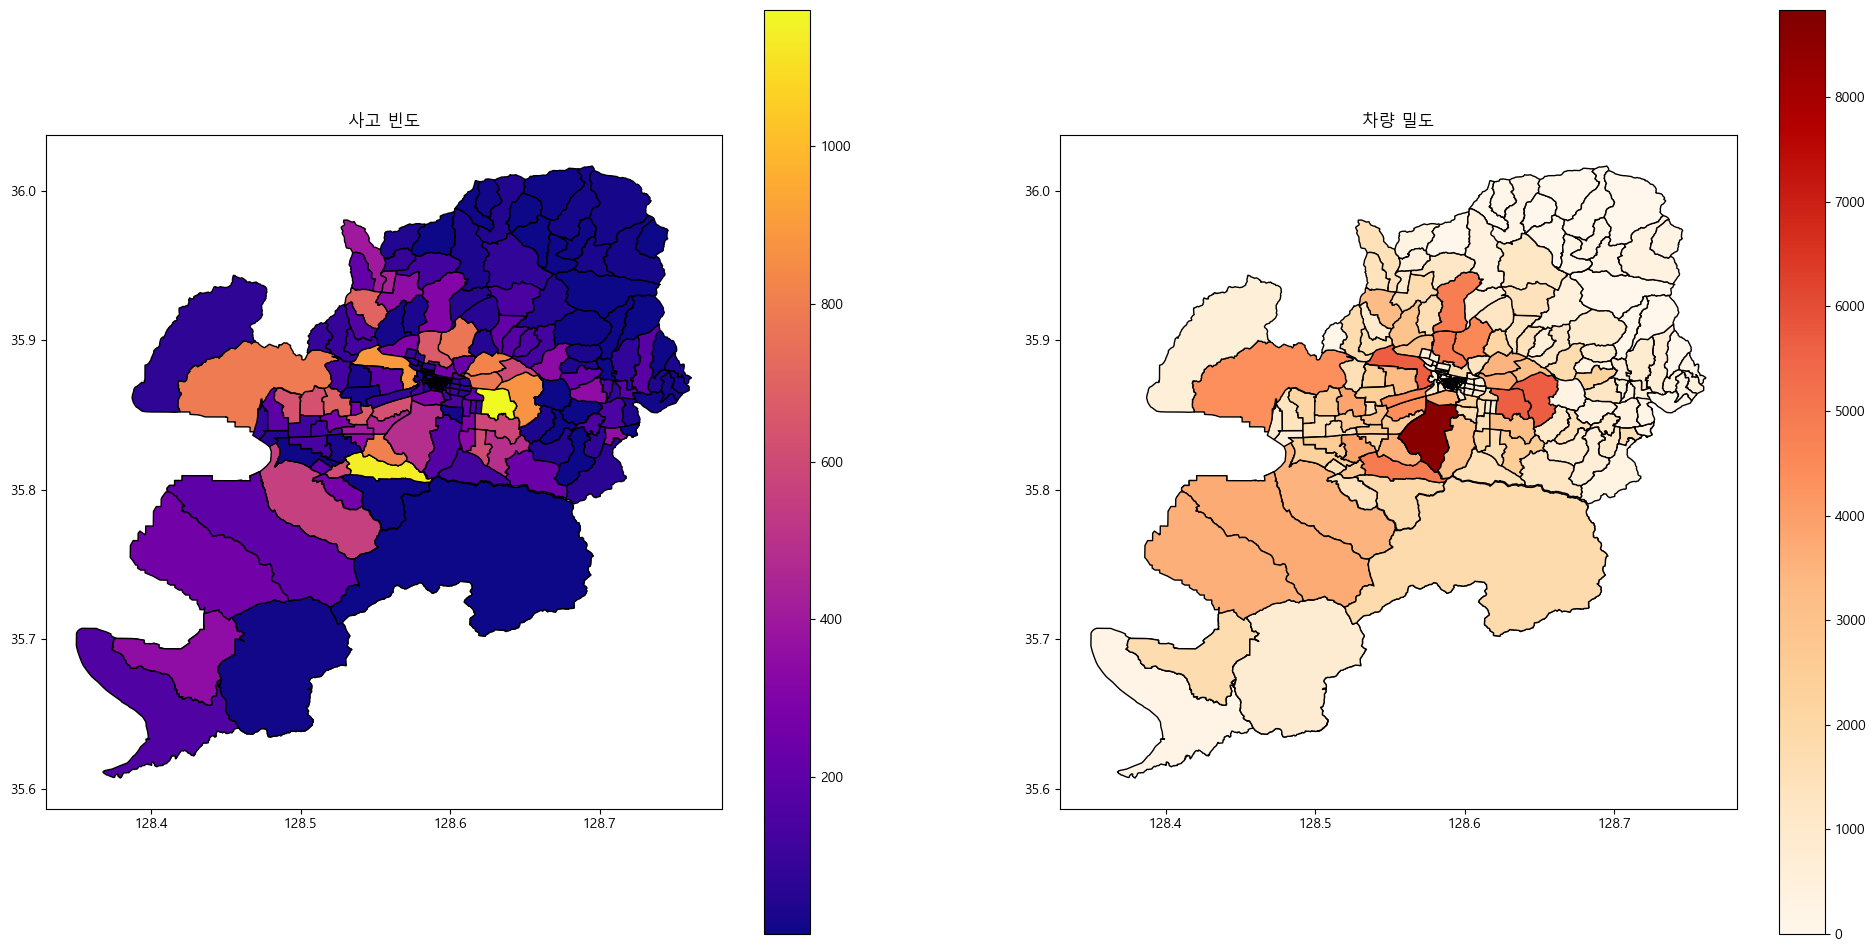

In [231]:
# 사고 당시 읍면동의 차량 밀도가 ECLO와 연관이 있는지 시각화

fig, axes = plt.subplots(figsize=(24,12), nrows=1, ncols=2)

plt.rcParams["font.family"] = "Malgun Gothic"

count_accident.plot(column="ECLO", legend = True, cmap="plasma", ax=axes[0],edgecolor="black")

axes[0].set_title("사고 빈도")

dense_accident.plot(column="사고시간대 밀도 합", legend=True, cmap="OrRd", ax=axes[1], edgecolor="black")
# axes[0].scatter(x=df_train_gpd["x"], y=df_train_gpd["y"], s=df_train_gpd["ECLO"], color="white", alpha=0.2)

axes[1].set_title("차량 밀도")

plt.show()

In [232]:
eclo_dense_corr = df_train_gpd[["ECLO", "사고시간대 밀도 합"]].corr("spearman")

print("ECLO와 차량 밀도의 상관 계수")
print(eclo_dense_corr)

ECLO와 차량 밀도의 상관 계수
               ECLO  사고시간대 밀도 합
ECLO        1.00000    -0.04783
사고시간대 밀도 합 -0.04783     1.00000


차량의 밀도가 높으면 어느 정도 사고가 빈번하게 일어납니다.
  
하지만 차량의 밀도와 ECLO는 상관성이 없다고 할 수 있습니다.

### 교통량과 ECLO의 관계

In [233]:
# 교통량 합계 데이터 불러오기

traffic_vol_100 = gpd.read_file("./data/external_open/대구 빅데이터 마트 데이터/5. 통행/3. 도로정보 및 교통량(합계, 시간대별)/교통데이터_합계/교통데이터_100.gpkg", engine="pyogrio", encoding="cp949")
traffic_vol_100 = traffic_vol_100.to_crs(crs=4326)
traffic_vol_100.drop("id", axis=1, inplace=True)

traffic_vol_100.info()
traffic_vol_100.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 89316 entries, 0 to 89315
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   평균속도_max        9442 non-null   float64 
 1   평균속도_mean       9442 non-null   float64 
 2   평균속도_min        9442 non-null   float64 
 3   추정교통량_max       9314 non-null   float64 
 4   추정교통량_mean      9314 non-null   float64 
 5   추정교통량_min       9314 non-null   float64 
 6   추정교통량_승용차_max   9314 non-null   float64 
 7   추정교통량_승용차_mean  9314 non-null   float64 
 8   추정교통량_승용차_min   9314 non-null   float64 
 9   추정교통량_버스_max    9314 non-null   float64 
 10  추정교통량_버스_mean   9314 non-null   float64 
 11  추정교통량_버스_min    9314 non-null   float64 
 12  추정교통량_트럭_max    9314 non-null   float64 
 13  추정교통량_트럭_mean   9314 non-null   float64 
 14  추정교통량_트럭_min    9314 non-null   float64 
 15  geometry        89316 non-null  geometry
dtypes: float64(15), geometry(1)
memory usage: 10.9 MB


평균속도_max  평균속도_mean  평균속도_min  추정교통량_max  추정교통량_mean  추정교통량_min  \
0       NaN        NaN       NaN        NaN         NaN        NaN   
1       NaN        NaN       NaN        NaN         NaN        NaN   
2       NaN        NaN       NaN        NaN         NaN        NaN   
3       NaN        NaN       NaN        NaN         NaN        NaN   
4       NaN        NaN       NaN        NaN         NaN        NaN   

   추정교통량_승용차_max  추정교통량_승용차_mean  추정교통량_승용차_min  추정교통량_버스_max  추정교통량_버스_mean  \
0            NaN             NaN            NaN           NaN            NaN   
1            NaN             NaN            NaN           NaN            NaN   
2            NaN             NaN            NaN           NaN            NaN   
3            NaN             NaN            NaN           NaN            NaN   
4            NaN             NaN            NaN           NaN            NaN   

   추정교통량_버스_min  추정교통량_트럭_max  추정교통량_트럭_mean  추정교통량_트럭_min  \
0           NaN           NaN            NaN           NaN   
1           NaN           NaN            NaN           NaN   
2           NaN           NaN            NaN           NaN   
3           NaN           NaN            NaN           NaN   
4           NaN           NaN            NaN           NaN   

                                            geometry  
0  MULTIPOLYGON (((128.35230 35.70449, 128.35264 ...  
1  MULTIPOLYGON (((128.35180 35.70402, 128.35225 ...  
2  MULTIPOLYGON (((128.35173 35.70310, 128.35176 ...  
3  MULTIPOLYGON (((128.35170 35.70264, 128.35262 ...  
4  MULTIPOLYGON (((128.35163 35.70157, 128.35164 ...

In [234]:
traffic_vol_100.isnull().sum()

평균속도_max          79874
평균속도_mean         79874
평균속도_min          79874
추정교통량_max         80002
추정교통량_mean        80002
추정교통량_min         80002
추정교통량_승용차_max     80002
추정교통량_승용차_mean    80002
추정교통량_승용차_min     80002
추정교통량_버스_max      80002
추정교통량_버스_mean     80002
추정교통량_버스_min      80002
추정교통량_트럭_max      80002
추정교통량_트럭_mean     80002
추정교통량_트럭_min      80002
geometry              0
dtype: int64

In [235]:
traffic_vol_100["평균속도_max"].max()

107.72

In [236]:
traffic_vol_100[traffic_vol_100["평균속도_max"].notnull()]

평균속도_max  평균속도_mean  평균속도_min   추정교통량_max  추정교통량_mean   추정교통량_min  \
1141   52.96000   51.11000  49.27000  1550.00000  1160.00000   770.00000   
1142   52.96000   51.11000  49.27000  1550.00000  1160.00000   770.00000   
1163   97.05000   97.05000  97.05000 16032.00000 16032.00000 16032.00000   
1164  102.63000  102.63000 102.63000 15546.00000 15546.00000 15546.00000   
1222   52.96000   51.11000  49.27000  1550.00000  1160.00000   770.00000   
...         ...        ...       ...         ...         ...         ...   
89249  90.23000   89.55000  88.87000 40407.00000 39849.00000 39291.00000   
89281  90.23000   89.55000  88.87000 40407.00000 39849.00000 39291.00000   
89282  90.23000   90.23000  90.23000 40407.00000 40407.00000 40407.00000   
89303  90.23000   89.55000  88.87000 40407.00000 39849.00000 39291.00000   
89314  90.23000   90.23000  90.23000 40407.00000 40407.00000 40407.00000   

       추정교통량_승용차_max  추정교통량_승용차_mean  추정교통량_승용차_min  추정교통량_버스_max  \
1141      1336.00000       963.00000      590.00000      19.00000   
1142      1336.00000       963.00000      590.00000      19.00000   
1163     10973.00000     10973.00000    10973.00000     366.00000   
1164     10531.00000     10531.00000    10531.00000     294.00000   
1222      1336.00000       963.00000      590.00000      19.00000   
...              ...             ...            ...           ...   
89249    25331.00000     25022.00000    24713.00000    1094.00000   
89281    25331.00000     25022.00000    24713.00000    1094.00000   
89282    25331.00000     25331.00000    25331.00000     643.00000   
89303    25331.00000     25022.00000    24713.00000    1094.00000   
89314    25331.00000     25331.00000    25331.00000     643.00000   

       추정교통량_버스_mean  추정교통량_버스_min  추정교통량_트럭_max  추정교통량_트럭_mean  추정교통량_트럭_min  \
1141        15.50000      12.00000     195.00000      181.50000     168.00000   
1142        15.50000      12.00000     195.00000      181.50000     168.00000   
1163       366.00000     366.00000    4693.00000     4693.00000    4693.00000   
1164       294.00000     294.00000    4721.00000     4721.00000    4721.00000   
1222        15.50000      12.00000     195.00000      181.50000     168.00000   
...              ...           ...           ...            ...           ...   
89249      868.50000     643.00000   14433.00000    13958.50000   13484.00000   
89281      868.50000     643.00000   14433.00000    13958.50000   13484.00000   
89282      643.00000     643.00000   14433.00000    14433.00000   14433.00000   
89303      868.50000     643.00000   14433.00000    13958.50000   13484.00000   
89314      643.00000     643.00000   14433.00000    14433.00000   14433.00000   

                                                geometry  
1141   MULTIPOLYGON (((128.38055 35.60782, 128.38040 ...  
1142   MULTIPOLYGON (((128.38119 35.60720, 128.38088 ...  
1163   MULTIPOLYGON (((128.38337 35.75957, 128.38347 ...  
1164   MULTIPOLYGON (((128.38329 35.75859, 128.38327 ...  
1222   MULTIPOLYGON (((128.38145 35.61047, 128.38255 ...  
...                                                  ...  
89249  MULTIPOLYGON (((128.75766 35.87399, 128.75876 ...  
89281  MULTIPOLYGON (((128.75878 35.87488, 128.75989 ...  
89282  MULTIPOLYGON (((128.75986 35.87343, 128.75980 ...  
89303  MULTIPOLYGON (((128.76087 35.87485, 128.76092 ...  
89314  MULTIPOLYGON (((128.76110 35.87474, 128.76116 ...  

[9442 rows x 16 columns]

In [237]:
# 결측치를 0으로 처리

traffic_vol_100.fillna(0,inplace=True)

평균 속도가 클수록 사고가 났을 때 부상을 당할 확률이 높다고 판단 >> 평균속도_max  
  
교통량의 최대치와 최소치 중, 중요한 요소를 판단할 수 없음 >> 추정교통량_mean(차종들의 평균도 포함)

In [260]:
list_traffic = ["평균속도_max", '추정교통량_mean', '추정교통량_승용차_mean', '추정교통량_버스_mean', '추정교통량_트럭_mean']

traffic_vol_select = traffic_vol_100[list_traffic+["geometry"]]

vol_emd = combine_address_other(emd=emd_all, daegu_data=traffic_vol_select, list_group=list_traffic)

vol_emd


  0%|          | 0/1262 [00:00<?, ?it/s]

100%|██████████| 1262/1262 [01:27<00:00, 14.41it/s]


주소   평균속도_max    추정교통량_mean 추정교통량_승용차_mean 추정교통량_버스_mean  \
0     대구광역시 수성구 삼덕동 4774.36000 1009482.91000   858306.38000   48527.60000   
1     대구광역시 수성구 가천동 4905.57000 1014380.42000   780794.92000   39610.61000   
2     대구광역시 수성구 신매동 2157.40000 1028585.24000   891171.75000   54127.34000   
3     대구광역시 수성구 고모동 1353.31000   72113.00000    65175.50000    2904.50000   
4     대구광역시 수성구 만촌동 8385.51000 4144561.52000  3542483.13000  260065.53000   
...             ...        ...           ...            ...           ...   
1215   대구광역시 서구 평리동 3349.53000 1860271.34000  1485072.84000  145247.98000   
1216   대구광역시 서구 이현동 4122.57000 1588181.60000  1126034.05000   82421.55000   
1217   대구광역시 서구 비산동 8912.82000 4018710.77000  2980973.18000  306252.81000   
1218   대구광역시 서구 중리동 3344.17000 1215555.73000   942471.77000   64432.60000   
1219   대구광역시 서구 상리동 5354.48000 1496518.94000  1035209.34000   48897.68000   

     추정교통량_트럭_mean         일시  
0     102648.95000 1899-12-30  
1     193974.87000 1899-12-30  
2      83286.16000 1899-12-30  
3       4033.00000 1899-12-30  
4     342012.84000 1899-12-30  
...            ...        ...  
1215  229950.50000 2021-09-14  
1216  379725.97000 2021-09-14  
1217  731484.77000 2021-09-14  
1218  208651.35000 2021-09-14  
1219  412411.88000 2021-09-14  

[1220 rows x 7 columns]

In [262]:
# coor_emd = vol_emd.groupby("주소")[["평균속도_max", '추정교통량_mean', '추정교통량_승용차_mean', '추정교통량_버스_mean', '추정교통량_트럭_mean']].max().reset_index()

# coor_emd.rename({"주소" : "시군구"}, axis=1, inplace=True)

# # coor_emd

In [272]:
def combine_traffic(left, right, colList : list) : 

    from tqdm import tqdm

    left_copy = copy.deepcopy(left)

    left_copy[colList] = 0   # 밀도 컬럼 생성

    for i in tqdm(range(left_copy.shape[0])) : 
        tm = int(left_copy.loc[i,"사고 시각"])   # 사고 시각을 정수 형태로 저장

        date = left_copy.loc[i, "사고일시"]   # 사고가 난 날짜를 저장

        adr = left_copy.loc[i,"시군구"]    # 사고가 난 주소를 저장
        value = right[(right["주소"]==adr) & (right["일시"]<=date)].iloc[:,1:]   # 사고가 난 지역과 일시가 일치하는 데이터프레임 추출

        value.sort_values("일시", ascending=False, inplace=True)   # 내림차순 정렬

        value_latest = value.iloc[0]   # 그 중 가장 최근 데이터 저장

        left_copy.loc[i, colList] = value_latest    # 데이터 대체

    return left_copy

In [270]:
df_train_merge = combine_traffic(left=df_train_gpd, right=vol_emd, colList=list_traffic)

df_train_merge.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 38 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   사고일시            39609 non-null  datetime64[ns]
 1   요일              39609 non-null  object        
 2   기상상태            39609 non-null  object        
 3   시군구             39609 non-null  object        
 4   도로형태            39609 non-null  object        
 5   노면상태            39609 non-null  object        
 6   사고유형            39609 non-null  object        
 7   사고유형 - 세부분류     39609 non-null  object        
 8   법규위반            39609 non-null  object        
 9   가해운전자 차종        39609 non-null  object        
 10  가해운전자 성별        39609 non-null  object        
 11  가해운전자 연령        39609 non-null  object        
 12  가해운전자 상해정도      39609 non-null  object        
 13  피해운전자 차종        39609 non-null  object        
 14  피해운전자 성별        39609 non-null  object        

In [273]:
df_model_merge = combine_traffic(left=df_model_gpd, right=vol_emd, colList=list_traffic)

df_model_merge.info()

  0%|          | 22/50572 [00:00<03:52, 217.62it/s]

100%|██████████| 50572/50572 [02:25<00:00, 346.84it/s]


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 50572 entries, 0 to 50571
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   사고일시            50572 non-null  datetime64[ns]
 1   요일              50572 non-null  object        
 2   기상상태            50572 non-null  object        
 3   시군구             50572 non-null  object        
 4   도로형태            50572 non-null  object        
 5   노면상태            50572 non-null  object        
 6   사고유형            50572 non-null  object        
 7   주소별 cctv 수      50572 non-null  object        
 8   사고 연도           50572 non-null  int32         
 9   사고 월            50572 non-null  object        
 10  사고 시각           50572 non-null  object        
 11  사고 시간대          50572 non-null  object        
 12  기상상태_label      50572 non-null  int64         
 13  노면상태_label      50572 non-null  int64         
 14  geometry        50572 non-null  geometry      

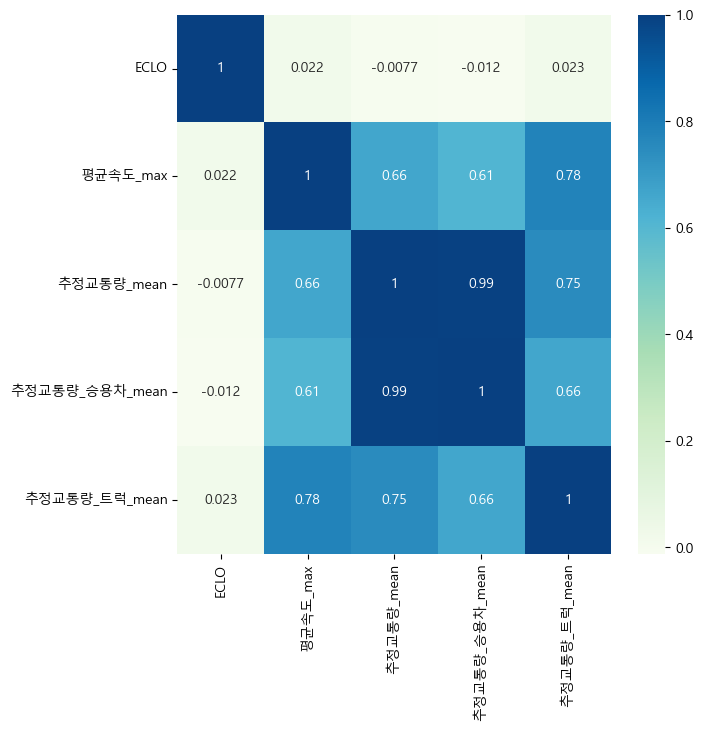

In [274]:
# ECLO와 교통량, 평균 속도와의 상관 계수

eclo_vol_corr = df_train_merge[["ECLO", '평균속도_max', '추정교통량_mean', '추정교통량_승용차_mean', '추정교통량_트럭_mean']].corr("pearson")

plt.figure(figsize=(7,7))

sns.heatmap(eclo_vol_corr, annot=True, cmap="GnBu")
plt.show()

전에 비교했던 것과 같이, 변수들이 ECLO와 직접적인 관련성은 적으나  
  
변수 간의 상관성을 확인할 수 있음  
  
교통량의 대부분을 승용차가 차지하고 있고,  
  
그에 따른 사고의 절반이 승용차로 발생하고 있기에,  
  
승용차의 추정 교통량이 추정 교통량 총합과 강한 상관성을 띠는 것은 자명

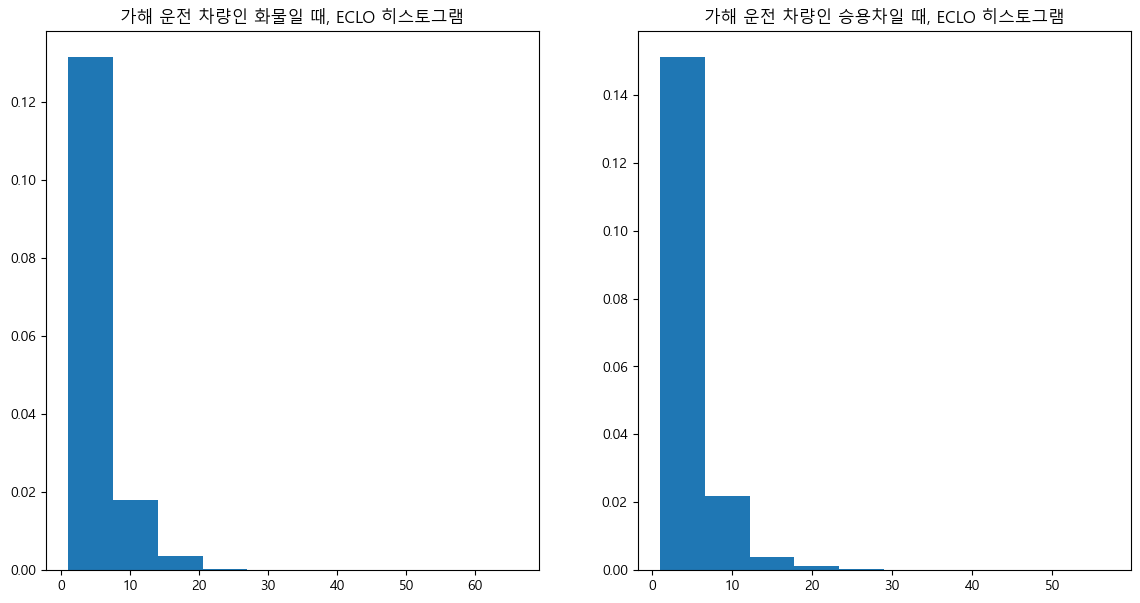

In [275]:
car_type_eclo = df_train_merge[(df_train_merge["가해운전자 차종"]=="화물") | (df_train_merge["가해운전자 차종"]=="승용")][["가해운전자 차종","ECLO"]]

fig, axes = plt.subplots(figsize=(14,7), nrows=1, ncols=2)

plt.rcParams["font.family"] = "Malgun Gothic"

axes[0].hist(car_type_eclo[car_type_eclo["가해운전자 차종"]=="화물"]["ECLO"], bins=10, density=1)
axes[0].set_title("가해 운전 차량인 화물일 때, ECLO 히스토그램")

axes[1].hist(car_type_eclo[car_type_eclo["가해운전자 차종"]=="승용"]["ECLO"], bins=10, density=1)
axes[1].set_title("가해 운전 차량인 승용차일 때, ECLO 히스토그램")
plt.show()

In [278]:
chi_obj(df_train_merge, col="가해운전자 차종")

[[13989  8612  2502  1602]
 [  735   463    94    84]
 [  820   141    11     6]
 [ 2080  1354   360   246]
 [ 2248  1263   448   132]
 [   62    36     5    10]
 [  878   317    36     3]
 [  273   133    45    11]
 [  200   145    50    30]
 [    7     2     1     0]
 [  109    61     2     0]
 [    2     1     0     0]]
p-value : 3.4709647621303313e-131
유의수준 5%에서 p-value가 0.05보다 작으므로 귀무가설 기각, 대립가설 채택, 가해운전자 차종은 ECLO와 독립적이라고 말할 수 없습니다.


히스토그램상, 가해 운전자의 차종에 따른 ECLO의 비율은 크게 달라 보이지 않으나  
  
카이제곱 검정을 했을 때, ECLO를 기준으로 6이상의 사고를 내는 것이 차종과 관련이 있을 수 있으므로,  

교통량을 차종에 따라 분리하는 것이 필요해 보임

### 지역과 ECLO와의 관계

In [284]:
# eclo19 = df_train_merge[df_train_merge["사고 연도"]==2019].groupby("시군구")[["ECLO"]].agg(["max", "median"]).reset_index()
# eclo20 = df_train_merge[df_train_merge["사고 연도"]==2020].groupby("시군구")[["ECLO"]].agg(["max", "median"]).reset_index()
# eclo21 = df_train_merge[df_train_merge["사고 연도"]==2021].groupby("시군구")[["ECLO"]].agg(["max", "median"]).reset_index()

In [285]:
# eclo19.columns = ["시군구", "max", "median"]
# eclo20.columns = ["시군구", "max", "median"]
# eclo21.columns = ["시군구", "max", "median"]

In [286]:
# emd_all_year = copy.deepcopy(emd_all)

# emd_all_year["연도"]

In [287]:
# eclo19 = eclo19.merge(emd_drop, left_on="시군구", right_on="주소")
# eclo20 = eclo20.merge(emd_drop, left_on="시군구", right_on="주소")
# eclo21 = eclo21.merge(emd_drop, left_on="시군구", right_on="주소")

In [288]:
# eclo19 = gpd.GeoDataFrame(eclo19)
# eclo20 = gpd.GeoDataFrame(eclo20)
# eclo21 = gpd.GeoDataFrame(eclo21)

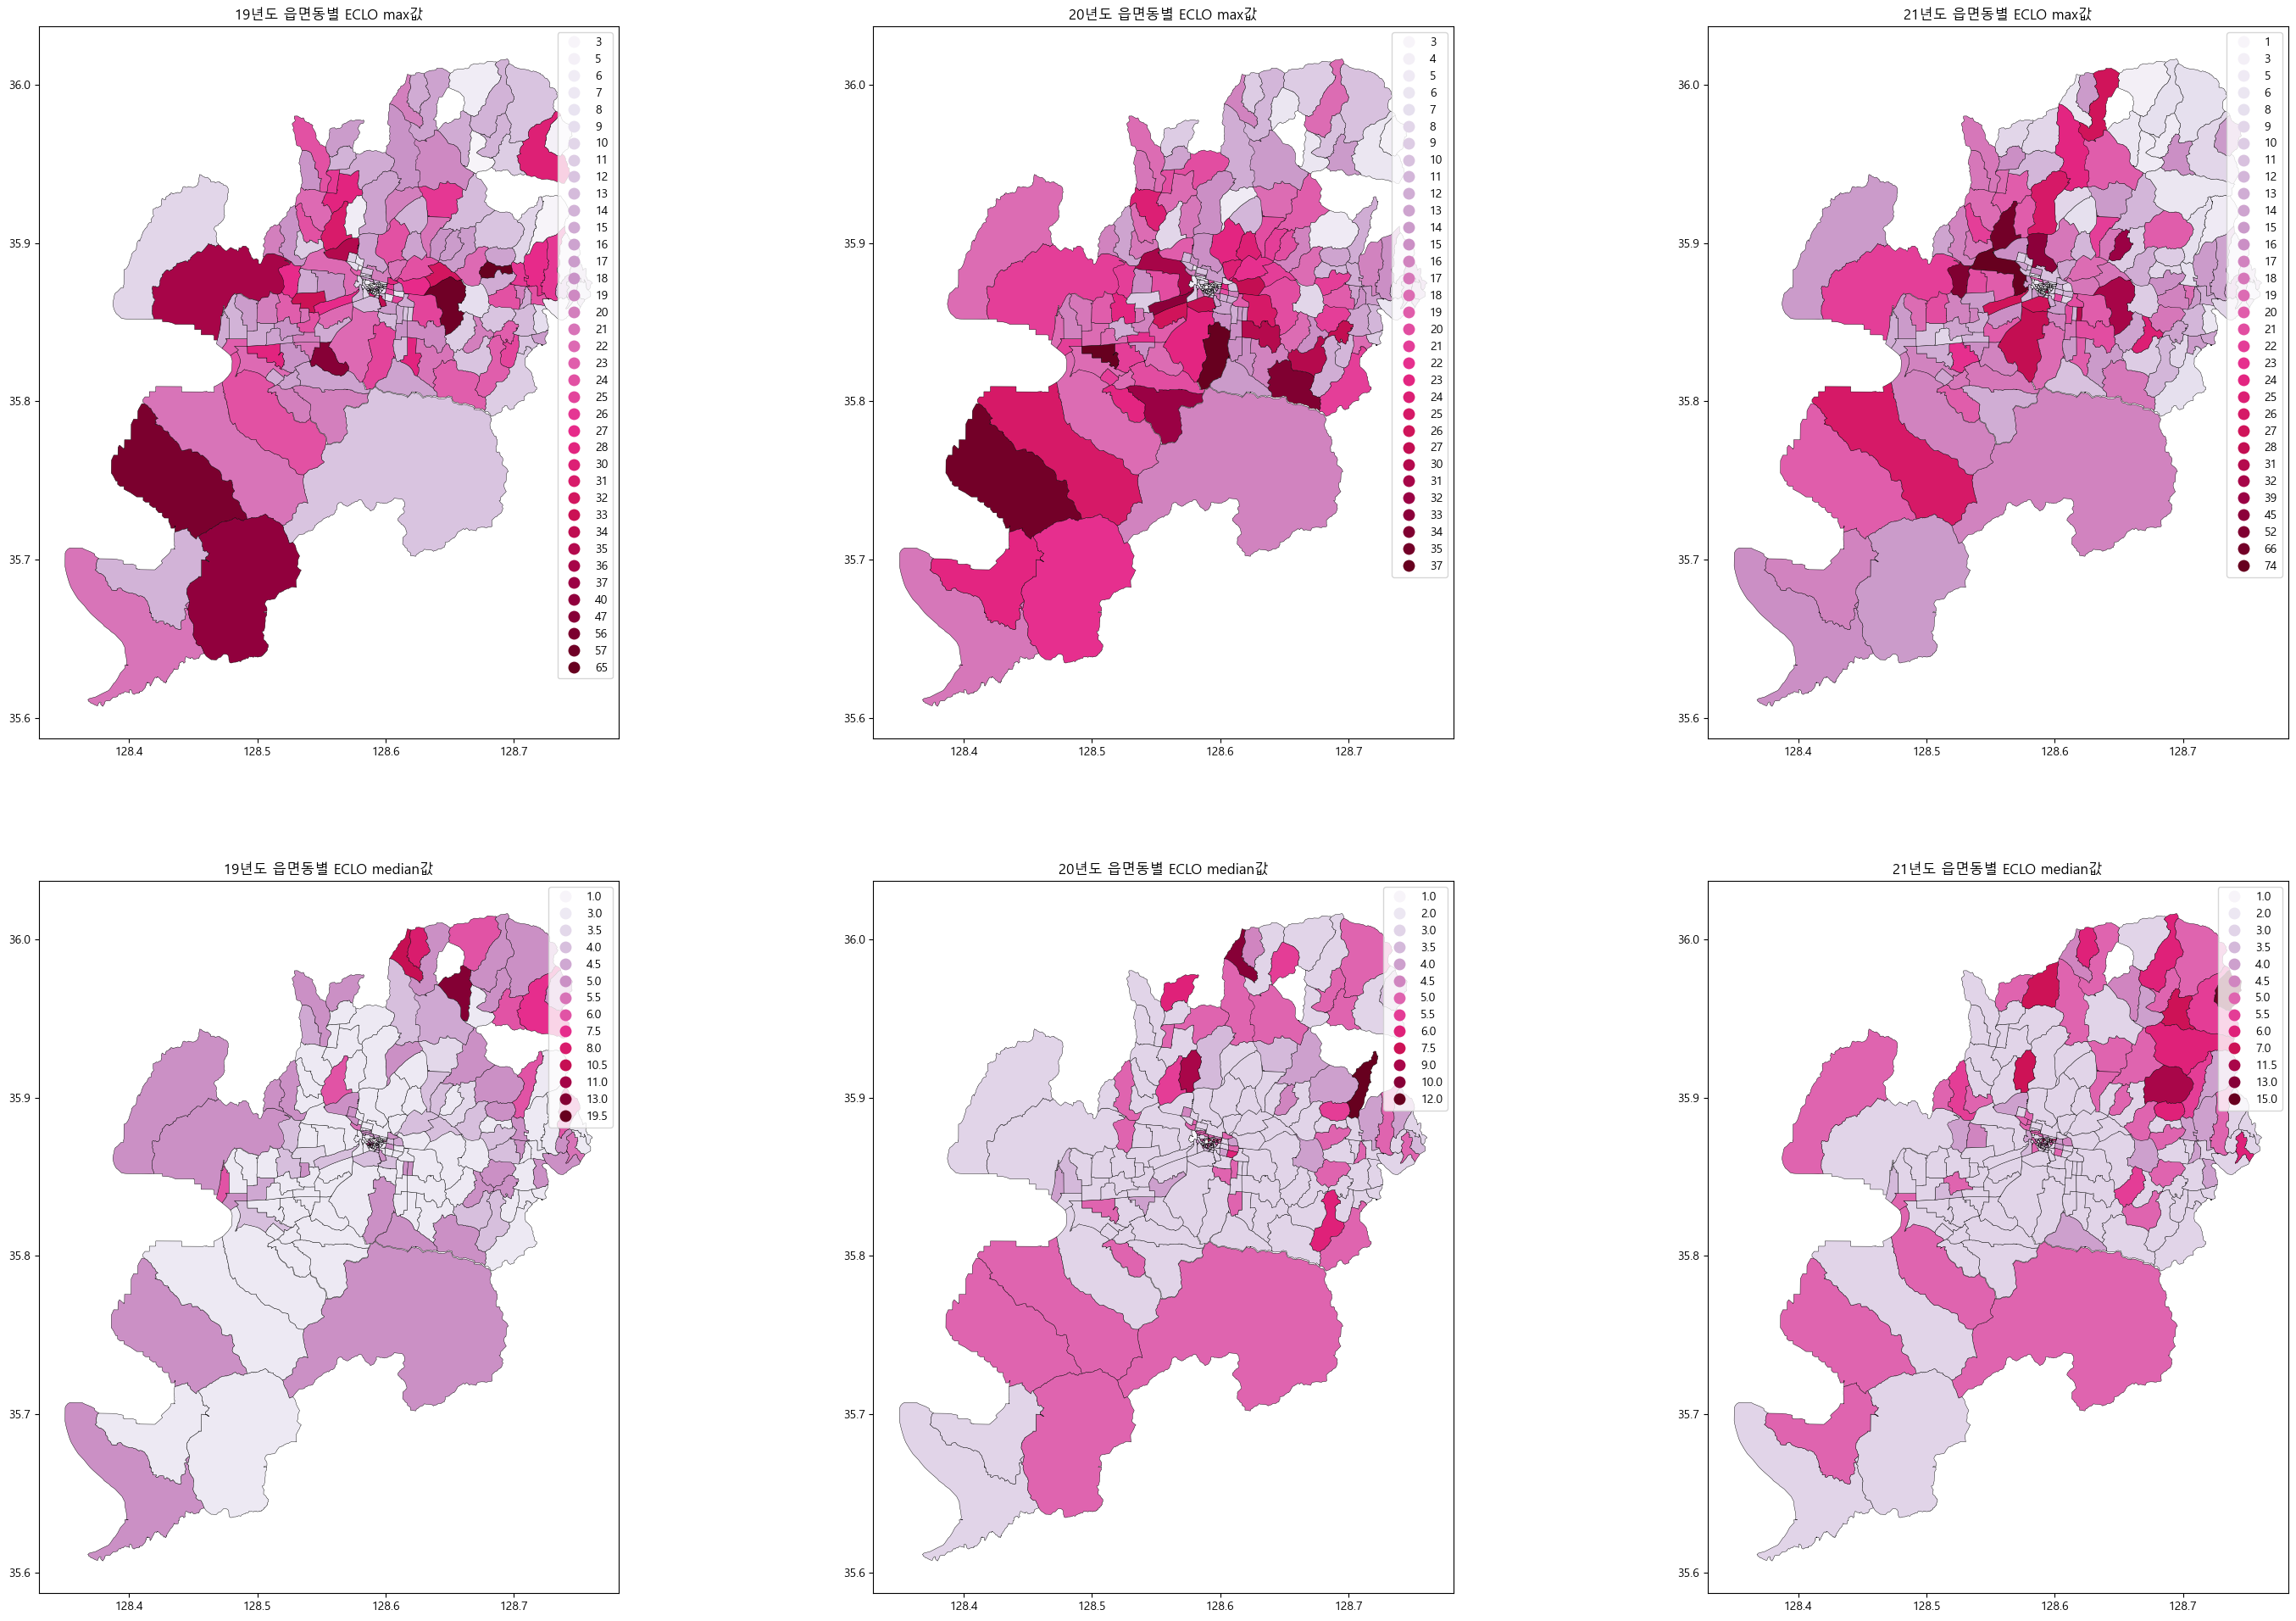

In [202]:
fig, axes = plt.subplots(figsize=(36,24), nrows=2, ncols=3)

plt.rcParams["font.family"] = "Malgun Gothic"

year = [19, 20, 21]

for ag in range(2) : 

    for y in range(3) :
        col = globals()["eclo"+str(year[y])].columns
        globals()["eclo"+str(year[y])].plot(column=col[ag+1], legend = True, cmap="PuRd", ax=axes[ag][y], edgecolor="black", linewidth=0.3, categorical=True)
        axes[ag][y].set_title(str(year[y])+"년도 읍면동별 ECLO "+col[ag+1]+"값")
# eclo19.plot(column="ECLO", legend = True, cmap="PuRd", ax=axes[0],edgecolor="black", linewidth=0.3, categorical=True)

# axes[0].set_title("19년도 읍면동별 ECLO 중앙값")

# eclo20.plot(column="ECLO", legend = True, cmap="PuRd", ax=axes[1],edgecolor="black", linewidth=0.3, categorical=True)

# axes[1].set_title("20년도 읍면동별 ECLO 중앙값")

# eclo21.plot(column="ECLO", legend = True, cmap="PuRd", ax=axes[2],edgecolor="black", linewidth=0.3, categorical=True)

# axes[2].set_title("21년도 읍면동별 ECLO 중앙값")

plt.show()

연도별로 ECLO의 최대값(지역에서 가장 큰 사고)은 지역별로 뚜렷한 추세를 보이지는 않습니다.  
  
그러나 ECLO의 중앙값을 살펴보면, 연도별로 낮은 값을 유지하는 지역들이 보입니다.  
  
즉 지역적인 특색은 사고의 높은 심각도보다는 낮은 심각도를 판별하는데 도움을 줄 것으로 판단됩니다.

### 도로형태와 사고유형에 따른 순위

ECLO가 10이상일 때, 도로 형태와 사고 유형 빈도에 따라 라벨링을 실시

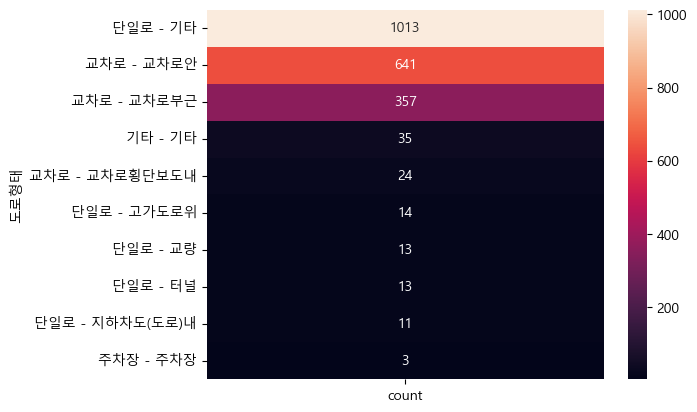

In [289]:
# ECLO가 10 초과인 도로 형태 개수 확인
plt.rcParams["font.family"] = "Malgun Gothic"

doro_val = df_train_merge[df_train_merge["ECLO"] > 10]["도로형태"].value_counts().to_frame()

sns.heatmap(doro_val, annot=True, fmt = ".0f")

plt.show()

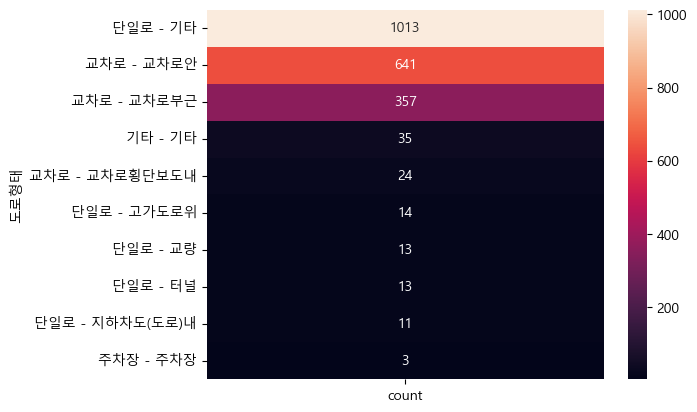

In [290]:
plt.rcParams["font.family"] = "Malgun Gothic"

sago_val = df_train_merge[df_train_merge["ECLO"] > 10]["사고유형"].value_counts().to_frame()

sns.heatmap(doro_val, annot=True, fmt = ".0f")

plt.show()

In [291]:
# ECLO 10 이상에 속하지 않는 도로 형태 확인

df_train_merge[~df_train_merge["도로형태"].isin(doro_val.index)]

# 미분류 - 미분류는 ECLO 10 이상이 존재하지 않음

사고일시   요일 기상상태             시군구       도로형태   노면상태  사고유형  \
983   2019-01-30 17:00:00  수요일   맑음    대구광역시 서구 내당동  미분류 - 미분류     건조   차대차   
1084  2019-02-01 19:00:00  금요일   맑음    대구광역시 북구 관음동  미분류 - 미분류     건조  차량단독   
12779 2019-11-20 17:00:00  수요일   맑음    대구광역시 동구 율하동  미분류 - 미분류     건조  차대사람   
15137 2020-01-17 19:00:00  금요일   맑음   대구광역시 수성구 만촌동  미분류 - 미분류     건조   차대차   
15742 2020-02-03 23:00:00  월요일   맑음   대구광역시 수성구 신매동  미분류 - 미분류     건조   차대차   
16924 2020-03-16 16:00:00  월요일   맑음  대구광역시 북구 노원동3가  미분류 - 미분류     건조   차대차   
21393 2020-07-22 19:00:00  수요일    비    대구광역시 수성구 파동  미분류 - 미분류  젖음/습기   차대차   
26090 2020-11-20 17:00:00  금요일   기타   대구광역시 달성군 다사읍  미분류 - 미분류     건조   차대차   

      사고유형 - 세부분류     법규위반 가해운전자 차종  ... 사고 시간대 기상상태_label 노면상태_label  \
983         후진중충돌  안전운전불이행       승용  ...     점심          1          1   
1084   도로외이탈 - 추락  안전운전불이행       이륜  ...     저녁          1          1   
12779          기타  안전운전불이행      자전거  ...     점심          1          1   
15137          추돌  안전운전불이행       승용  ...     저녁          1          1   
15742          추돌  안전운전불이행       승용  ...     저녁          1          1   
16924        측면충돌  안전운전불이행       승용  ...     점심          1          1   
21393          기타  안전운전불이행     기타불명  ...     저녁          3          2   
26090          기타  안전운전불이행       화물  ...     점심          2          1   

                                                geometry 사고시간대 밀도 합  \
983    POLYGON ((128.55349 35.86303, 128.55350 35.863... 6258.27994   
1084   POLYGON ((128.53342 35.94773, 128.53363 35.947... 1554.49104   
12779  POLYGON ((128.70141 35.87425, 128.70132 35.874... 1643.51852   
15137  POLYGON ((128.66157 35.85577, 128.66126 35.855... 6242.85614   
15742  MULTIPOLYGON (((128.70284 35.83075, 128.70284 ...  606.76523   
16924  POLYGON ((128.57382 35.90312, 128.57383 35.903... 3469.39072   
21393  POLYGON ((128.60784 35.82714, 128.60795 35.826... 1661.31399   
26090  POLYGON ((128.49339 35.86495, 128.49258 35.865... 5996.38020   

         평균속도_max    추정교통량_mean  추정교통량_승용차_mean  추정교통량_버스_mean  추정교통량_트럭_mean  
983    2830.43000 2290483.79000   1952907.83000   143692.38000   193883.55000  
1084   3028.89000  940832.61000    789547.38000    17563.74000   133721.50000  
12779  5872.77000 1077798.37000    862640.75000    25851.71000   189305.86000  
15137  8848.41000 4351645.08000   3710649.75000   272229.70000   368765.62000  
15742  2189.10000 1055970.07000    914752.75000    58646.00000    82571.32000  
16924  4561.33000 2411684.40000   1754455.90000   184747.31000   472481.20000  
21393  7761.53000 1391227.27000   1193871.25000    59616.32000   137739.66000  
26090 10285.01000 3390011.75000   2628780.57000    46276.53000   714954.67000  

[8 rows x 38 columns]

In [292]:
sum_doro_eclo = doro_val["count"].sum()

sum_sago_eclo = sago_val["count"].sum()

# doro_val["ratio"] = math.floor(doro_val["count"] / sum_doro_eclo * 1000)
# sago_val["ratio"] = math.floor(sago_val["count"] / sum_sago_eclo * 1000)

doro_val["ratio"] = doro_val["count"].map(lambda x : math.floor(x / sum_doro_eclo * 1000))
sago_val["ratio"] = sago_val["count"].map(lambda x : math.floor(x / sum_sago_eclo * 1000))

sago_val

count  ratio
사고유형              
차대차    2071    975
차대사람     27     12
차량단독     26     12

In [293]:
def label_doro(dataframe, col : str) : 

    doro = {'단일로 - 기타' : 10, #476, 
            '교차로 - 교차로안' : 9, #301,
            '교차로 - 교차로부근' : 8, #168,
            '기타 - 기타' : 7, #16,
            '교차로 - 교차로횡단보도내' : 6, #11,
            '단일로 - 고가도로위' : 5, #6,
            '단일로 - 교량' : 4, #6,
            '단일로 - 터널' : 3, #6,
            '단일로 - 지하차도(도로)내' : 2, #5,
            '주차장 - 주차장' : 1,
            '미분류 - 미분류' : 0}
    
    dataframe[col].replace(doro, inplace=True)

    return dataframe


def label_sago(dataframe, col : str) : 

    sago = {'차대차' : 3, #975,
        '차대사람' : 2, #12,
        '차량단독' : 1 #12
        }
    
    dataframe[col].replace(sago, inplace=True)

    return dataframe

In [294]:
df_train_merge = label_doro(dataframe=df_train_merge, col="도로형태")
df_train_merge = label_sago(dataframe=df_train_merge, col="사고유형")

df_train_merge

사고일시   요일 기상상태              시군구  도로형태 노면상태  사고유형  \
0     2019-01-01 00:00:00  화요일   맑음     대구광역시 중구 대신동    10   건조     2   
1     2019-01-01 00:00:00  화요일   흐림    대구광역시 달서구 감삼동    10   건조     2   
2     2019-01-01 01:00:00  화요일   맑음    대구광역시 수성구 두산동    10   건조     2   
3     2019-01-01 02:00:00  화요일   맑음     대구광역시 북구 복현동    10   건조     3   
4     2019-01-01 04:00:00  화요일   맑음     대구광역시 동구 신암동    10   건조     3   
...                   ...  ...  ...              ...   ...  ...   ...   
39604 2021-12-31 19:00:00  금요일   맑음  대구광역시 수성구 수성동3가     9   건조     3   
39605 2021-12-31 19:00:00  금요일   맑음    대구광역시 달서구 상인동    10   건조     3   
39606 2021-12-31 21:00:00  금요일   맑음    대구광역시 달서구 월성동     9   건조     3   
39607 2021-12-31 22:00:00  금요일   맑음     대구광역시 달서구 장동     7   건조     3   
39608 2021-12-31 23:00:00  금요일   맑음     대구광역시 서구 비산동     2   건조     3   

      사고유형 - 세부분류       법규위반 가해운전자 차종  ... 사고 시간대 기상상태_label 노면상태_label  \
0      길가장자리구역통행중    안전운전불이행       승용  ...     새벽          1          1   
1           보도통행중         기타       승용  ...     새벽          2          1   
2           차도통행중    안전운전불이행       승용  ...     새벽          1          1   
3              추돌    안전운전불이행       승용  ...     새벽          1          1   
4              추돌    안전운전불이행       승용  ...     새벽          1          1   
...           ...        ...      ...  ...    ...        ...        ...   
39604        측면충돌       신호위반       승용  ...     저녁          1          1   
39605        측면충돌    안전거리미확보       승용  ...     저녁          1          1   
39606        측면충돌  교차로운행방법위반       승용  ...     저녁          1          1   
39607          추돌    안전운전불이행       승용  ...     저녁          1          1   
39608        측면충돌    안전운전불이행       승용  ...     저녁          1          1   

                                                geometry 사고시간대 밀도 합  \
0      POLYGON ((128.57417 35.86253, 128.57412 35.862...  312.06683   
1      POLYGON ((128.53075 35.84932, 128.53324 35.849... 1022.36378   
2      POLYGON ((128.61686 35.84049, 128.61872 35.840...  561.03238   
3      POLYGON ((128.61551 35.88971, 128.61433 35.890...  254.98900   
4      POLYGON ((128.60663 35.87685, 128.60690 35.877...  434.11503   
...                                                  ...        ...   
39604  POLYGON ((128.62146 35.85954, 128.62146 35.859...  780.51197   
39605  POLYGON ((128.58682 35.80515, 128.58614 35.804... 5877.32287   
39606  POLYGON ((128.52907 35.83712, 128.52904 35.837... 2701.32393   
39607  POLYGON ((128.51542 35.84629, 128.51570 35.846...  741.04485   
39608  POLYGON ((128.55219 35.89424, 128.55207 35.894... 1929.34371   

        평균속도_max    추정교통량_mean  추정교통량_승용차_mean  추정교통량_버스_mean  추정교통량_트럭_mean  
0      723.99000  549258.22000    474724.12000    32891.89000    41642.21000  
1     2142.80000 1812718.27000   1544309.56000   105449.71000   162959.00000  
2     1932.21000 1073433.20000    950354.81000    52940.10000    70138.25000  
3     1775.36000 1184141.76000    928212.11000    91811.50000   164118.15000  
4     3768.83000 2040952.08000   1684317.26000   152959.33000   203675.47000  
...          ...           ...             ...            ...            ...  
39604  680.37000  436175.30000    383791.68000    24983.72000    27399.90000  
39605 9360.58000 3159631.73000   2662470.25000   186748.06000   310413.44000  
39606 6689.23000 1933555.53000   1536641.47000    76921.42000   319992.66000  
39607 3008.63000 1029605.14000    834960.56000    48123.13000   146521.47000  
39608 8912.82000 4018710.77000   2980973.18000   306252.81000   731484.77000  

[39609 rows x 38 columns]

In [295]:
df_model_merge = label_doro(dataframe=df_model_merge, col="도로형태")
df_model_merge = label_sago(dataframe=df_model_merge, col="사고유형")

df_model_merge

사고일시   요일 기상상태            시군구  도로형태 노면상태  사고유형  \
0     2019-01-01 00:00:00  화요일   맑음   대구광역시 중구 대신동    10   건조     2   
1     2019-01-01 00:00:00  화요일   흐림  대구광역시 달서구 감삼동    10   건조     2   
2     2019-01-01 01:00:00  화요일   맑음  대구광역시 수성구 두산동    10   건조     2   
3     2019-01-01 02:00:00  화요일   맑음   대구광역시 북구 복현동    10   건조     3   
4     2019-01-01 04:00:00  화요일   맑음   대구광역시 동구 신암동    10   건조     3   
...                   ...  ...  ...            ...   ...  ...   ...   
50567 2022-12-31 18:00:00  토요일   맑음   대구광역시 남구 대명동     3   건조     3   
50568 2022-12-31 18:00:00  토요일   맑음  대구광역시 수성구 시지동    10   건조     3   
50569 2022-12-31 20:00:00  토요일   맑음  대구광역시 수성구 연호동    10   건조     3   
50570 2022-12-31 20:00:00  토요일   맑음  대구광역시 수성구 범물동     8   건조     3   
50571 2022-12-31 21:00:00  토요일   맑음   대구광역시 동구 효목동     8   건조     3   

      주소별 cctv 수  사고 연도 사고 월  ... 사고 시간대 기상상태_label  노면상태_label  \
0        3.00000   2019    1  ...     새벽          1           1   
1       10.00000   2019    1  ...     새벽          2           1   
2        2.00000   2019    1  ...     새벽          1           1   
3        6.00000   2019    1  ...     새벽          1           1   
4        9.00000   2019    1  ...     새벽          1           1   
...          ...    ...  ...  ...    ...        ...         ...   
50567   62.00000   2022   12  ...     저녁          1           1   
50568    4.00000   2022   12  ...     저녁          1           1   
50569          0   2022   12  ...     저녁          1           1   
50570    7.00000   2022   12  ...     저녁          1           1   
50571    4.00000   2022   12  ...     저녁          1           1   

                                                geometry  사고시간대 밀도 합  \
0      POLYGON ((128.57417 35.86253, 128.57412 35.862...   312.06683   
1      POLYGON ((128.53075 35.84932, 128.53324 35.849...  1022.36378   
2      POLYGON ((128.61686 35.84049, 128.61872 35.840...   561.03238   
3      POLYGON ((128.61551 35.88971, 128.61433 35.890...   254.98900   
4      POLYGON ((128.60663 35.87685, 128.60690 35.877...   434.11503   
...                                                  ...         ...   
50567  POLYGON ((128.58212 35.85666, 128.58287 35.856... 12796.16513   
50568  POLYGON ((128.68378 35.84094, 128.68398 35.841...  1454.12332   
50569  POLYGON ((128.65992 35.83279, 128.66022 35.833...  1210.45180   
50570  POLYGON ((128.65394 35.82584, 128.65424 35.825...  1059.15508   
50571  POLYGON ((128.65940 35.87688, 128.65938 35.876...  2148.03907   

        평균속도_max    추정교통량_mean  추정교통량_승용차_mean  추정교통량_버스_mean  추정교통량_트럭_mean  
0      723.99000  549258.22000    474724.12000    32891.89000    41642.21000  
1     2142.80000 1812718.27000   1544309.56000   105449.71000   162959.00000  
2     1932.21000 1073433.20000    950354.81000    52940.10000    70138.25000  
3     1775.36000 1184141.76000    928212.11000    91811.50000   164118.15000  
4     3768.83000 2040952.08000   1684317.26000   152959.33000   203675.47000  
...          ...           ...             ...            ...            ...  
50567 9109.76000 5221511.66000   4450520.19000   349022.58000   421968.86000  
50568 2680.48000  924959.63000    751723.22000    49883.43000   123352.99000  
50569 3987.53000 1368455.94000   1169709.80000    83844.59000   114901.56000  
50570 2301.39000  849965.25000    726249.02000    38753.57000    84962.67000  
50571 3983.71000 2130820.89000   1788610.42000   141767.68000   200442.77000  

[50572 rows x 21 columns]

### 요일에 따른 순위

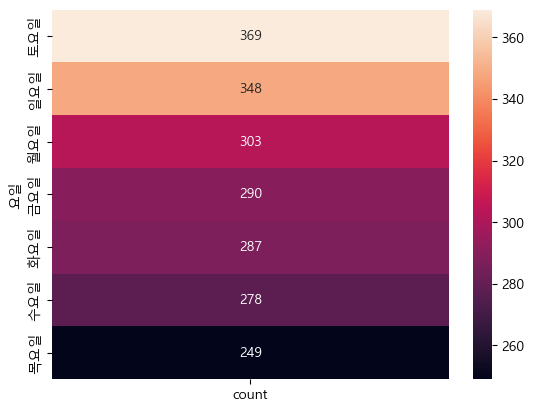

In [296]:
# ECLO가 10 초과인 요일별 개수 확인
plt.rcParams["font.family"] = "Malgun Gothic"

day_val = df_train_merge[df_train_merge["ECLO"] > 10]["요일"].value_counts().to_frame()

sns.heatmap(day_val, annot=True, fmt = ".0f")

plt.show()

In [297]:
def label_day(dataframe, col : str) : 

    sago = {'토요일' : 7, 
            '일요일' : 6, 
            '월요일' : 5, 
            '금요일' : 4, 
            '화요일' : 3, 
            '수요일' : 2, 
            '목요일' : 1
        }
    
    dataframe[col].replace(sago, inplace=True)

    return dataframe

In [298]:
df_train_merge = label_day(dataframe=df_train_merge, col="요일")
df_model_merge = label_day(dataframe=df_model_merge, col="요일")

df_model_merge

사고일시  요일 기상상태            시군구  도로형태 노면상태  사고유형 주소별 cctv 수  \
0     2019-01-01 00:00:00   3   맑음   대구광역시 중구 대신동    10   건조     2    3.00000   
1     2019-01-01 00:00:00   3   흐림  대구광역시 달서구 감삼동    10   건조     2   10.00000   
2     2019-01-01 01:00:00   3   맑음  대구광역시 수성구 두산동    10   건조     2    2.00000   
3     2019-01-01 02:00:00   3   맑음   대구광역시 북구 복현동    10   건조     3    6.00000   
4     2019-01-01 04:00:00   3   맑음   대구광역시 동구 신암동    10   건조     3    9.00000   
...                   ...  ..  ...            ...   ...  ...   ...        ...   
50567 2022-12-31 18:00:00   7   맑음   대구광역시 남구 대명동     3   건조     3   62.00000   
50568 2022-12-31 18:00:00   7   맑음  대구광역시 수성구 시지동    10   건조     3    4.00000   
50569 2022-12-31 20:00:00   7   맑음  대구광역시 수성구 연호동    10   건조     3          0   
50570 2022-12-31 20:00:00   7   맑음  대구광역시 수성구 범물동     8   건조     3    7.00000   
50571 2022-12-31 21:00:00   7   맑음   대구광역시 동구 효목동     8   건조     3    4.00000   

       사고 연도 사고 월  ... 사고 시간대 기상상태_label  노면상태_label  \
0       2019    1  ...     새벽          1           1   
1       2019    1  ...     새벽          2           1   
2       2019    1  ...     새벽          1           1   
3       2019    1  ...     새벽          1           1   
4       2019    1  ...     새벽          1           1   
...      ...  ...  ...    ...        ...         ...   
50567   2022   12  ...     저녁          1           1   
50568   2022   12  ...     저녁          1           1   
50569   2022   12  ...     저녁          1           1   
50570   2022   12  ...     저녁          1           1   
50571   2022   12  ...     저녁          1           1   

                                                geometry  사고시간대 밀도 합  \
0      POLYGON ((128.57417 35.86253, 128.57412 35.862...   312.06683   
1      POLYGON ((128.53075 35.84932, 128.53324 35.849...  1022.36378   
2      POLYGON ((128.61686 35.84049, 128.61872 35.840...   561.03238   
3      POLYGON ((128.61551 35.88971, 128.61433 35.890...   254.98900   
4      POLYGON ((128.60663 35.87685, 128.60690 35.877...   434.11503   
...                                                  ...         ...   
50567  POLYGON ((128.58212 35.85666, 128.58287 35.856... 12796.16513   
50568  POLYGON ((128.68378 35.84094, 128.68398 35.841...  1454.12332   
50569  POLYGON ((128.65992 35.83279, 128.66022 35.833...  1210.45180   
50570  POLYGON ((128.65394 35.82584, 128.65424 35.825...  1059.15508   
50571  POLYGON ((128.65940 35.87688, 128.65938 35.876...  2148.03907   

        평균속도_max    추정교통량_mean  추정교통량_승용차_mean  추정교통량_버스_mean  추정교통량_트럭_mean  
0      723.99000  549258.22000    474724.12000    32891.89000    41642.21000  
1     2142.80000 1812718.27000   1544309.56000   105449.71000   162959.00000  
2     1932.21000 1073433.20000    950354.81000    52940.10000    70138.25000  
3     1775.36000 1184141.76000    928212.11000    91811.50000   164118.15000  
4     3768.83000 2040952.08000   1684317.26000   152959.33000   203675.47000  
...          ...           ...             ...            ...            ...  
50567 9109.76000 5221511.66000   4450520.19000   349022.58000   421968.86000  
50568 2680.48000  924959.63000    751723.22000    49883.43000   123352.99000  
50569 3987.53000 1368455.94000   1169709.80000    83844.59000   114901.56000  
50570 2301.39000  849965.25000    726249.02000    38753.57000    84962.67000  
50571 3983.71000 2130820.89000   1788610.42000   141767.68000   200442.77000  

[50572 rows x 21 columns]

## 모델링

### 데이터 분리

In [300]:
df_model_merge[['주소별 cctv 수', '사고 월', '사고 시각']] = df_model_merge[['주소별 cctv 수', '사고 월', '사고 시각']].astype(int)

In [301]:
train = df_model_merge.iloc[:len_train].drop(["기상상태", "노면상태", "시군구", "geometry", "사고 연도"], axis=1)

test = df_model_merge.iloc[len_train:].drop(["기상상태", "노면상태", "시군구", "geometry", "사고 연도"], axis=1)

train.set_index(keys='사고일시', drop=True, inplace=True)
test.set_index(keys='사고일시', drop=True, inplace=True)

train.head()

요일  도로형태  사고유형  주소별 cctv 수  사고 월  사고 시각 사고 시간대  \
사고일시                                                                  
2019-01-01 00:00:00   3    10     2           3     1      0     새벽   
2019-01-01 00:00:00   3    10     2          10     1      0     새벽   
2019-01-01 01:00:00   3    10     2           2     1      1     새벽   
2019-01-01 02:00:00   3    10     3           6     1      2     새벽   
2019-01-01 04:00:00   3    10     3           9     1      4     새벽   

                     기상상태_label  노면상태_label  사고시간대 밀도 합   평균속도_max  \
사고일시                                                                 
2019-01-01 00:00:00           1           1   312.06683  723.99000   
2019-01-01 00:00:00           2           1  1022.36378 2142.80000   
2019-01-01 01:00:00           1           1   561.03238 1932.21000   
2019-01-01 02:00:00           1           1   254.98900 1775.36000   
2019-01-01 04:00:00           1           1   434.11503 3768.83000   

                       추정교통량_mean  추정교통량_승용차_mean  추정교통량_버스_mean  \
사고일시                                                               
2019-01-01 00:00:00  549258.22000    474724.12000    32891.89000   
2019-01-01 00:00:00 1812718.27000   1544309.56000   105449.71000   
2019-01-01 01:00:00 1073433.20000    950354.81000    52940.10000   
2019-01-01 02:00:00 1184141.76000    928212.11000    91811.50000   
2019-01-01 04:00:00 2040952.08000   1684317.26000   152959.33000   

                     추정교통량_트럭_mean  
사고일시                                
2019-01-01 00:00:00    41642.21000  
2019-01-01 00:00:00   162959.00000  
2019-01-01 01:00:00    70138.25000  
2019-01-01 02:00:00   164118.15000  
2019-01-01 04:00:00   203675.47000

### labelbinary

In [97]:
# lb_bi_day = LabelBinarizer()   # 요일을 labelbinary
# lb_bi_hours = LabelBinarizer()   # 사고 시간대를 labelbinary

# lb_bi_day.fit(train["요일"].to_list())    # train datad의 요일을 fit
# lb_bi_hours.fit(train["사고 시간대"].to_list())  # train datad의 사고 시간대를 fit

# bi_day = lb_bi_day.transform(train["요일"].to_list())   # train data로 fit된 객체에 train["요일"]을 transform
# bi_hours = lb_bi_hours.transform(train["사고 시간대"].to_list())    # train data로 fit된 객체에 train["사고 시간대"]을 transform

# test_bi_day = lb_bi_day.transform(test["요일"].to_list())    # train data로 fit된 객체에 test["요일"]을 transform
# test_bi_hours = lb_bi_hours.transform(test["사고 시간대"].to_list())    # train data로 fit된 객체에 test["사고 시간대"]을 transform
 
# bi_hours

### 독립, 종속 분리

In [303]:
X = train.select_dtypes("number")
y = df_train_merge["ECLO"]

test = test.select_dtypes("number")

print(X.shape)
print(y.shape)

X

(39609, 14)
(39609,)


요일  도로형태  사고유형  주소별 cctv 수  사고 월  사고 시각  기상상태_label  \
사고일시                                                                       
2019-01-01 00:00:00   3    10     2           3     1      0           1   
2019-01-01 00:00:00   3    10     2          10     1      0           2   
2019-01-01 01:00:00   3    10     2           2     1      1           1   
2019-01-01 02:00:00   3    10     3           6     1      2           1   
2019-01-01 04:00:00   3    10     3           9     1      4           1   
...                  ..   ...   ...         ...   ...    ...         ...   
2021-12-31 19:00:00   4     9     3           1    12     19           1   
2021-12-31 19:00:00   4    10     3          30    12     19           1   
2021-12-31 21:00:00   4     9     3          22    12     21           1   
2021-12-31 22:00:00   4     7     3           1    12     22           1   
2021-12-31 23:00:00   4     2     3          15    12     23           1   

                     노면상태_label  사고시간대 밀도 합   평균속도_max    추정교통량_mean  \
사고일시                                                                   
2019-01-01 00:00:00           1   312.06683  723.99000  549258.22000   
2019-01-01 00:00:00           1  1022.36378 2142.80000 1812718.27000   
2019-01-01 01:00:00           1   561.03238 1932.21000 1073433.20000   
2019-01-01 02:00:00           1   254.98900 1775.36000 1184141.76000   
2019-01-01 04:00:00           1   434.11503 3768.83000 2040952.08000   
...                         ...         ...        ...           ...   
2021-12-31 19:00:00           1   780.51197  680.37000  436175.30000   
2021-12-31 19:00:00           1  5877.32287 9360.58000 3159631.73000   
2021-12-31 21:00:00           1  2701.32393 6689.23000 1933555.53000   
2021-12-31 22:00:00           1   741.04485 3008.63000 1029605.14000   
2021-12-31 23:00:00           1  1929.34371 8912.82000 4018710.77000   

                     추정교통량_승용차_mean  추정교통량_버스_mean  추정교통량_트럭_mean  
사고일시                                                               
2019-01-01 00:00:00    474724.12000    32891.89000    41642.21000  
2019-01-01 00:00:00   1544309.56000   105449.71000   162959.00000  
2019-01-01 01:00:00    950354.81000    52940.10000    70138.25000  
2019-01-01 02:00:00    928212.11000    91811.50000   164118.15000  
2019-01-01 04:00:00   1684317.26000   152959.33000   203675.47000  
...                             ...            ...            ...  
2021-12-31 19:00:00    383791.68000    24983.72000    27399.90000  
2021-12-31 19:00:00   2662470.25000   186748.06000   310413.44000  
2021-12-31 21:00:00   1536641.47000    76921.42000   319992.66000  
2021-12-31 22:00:00    834960.56000    48123.13000   146521.47000  
2021-12-31 23:00:00   2980973.18000   306252.81000   731484.77000  

[39609 rows x 14 columns]

In [4]:
X = pd.read_csv("./train_X_nyeoki.csv", index_col="사고일시")

X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39609 entries, 2019-01-01 00:00:00 to 2021-12-31 23:00:00
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   요일              39609 non-null  int64  
 1   도로형태            39609 non-null  int64  
 2   사고유형            39609 non-null  int64  
 3   주소별 cctv 수      39609 non-null  int64  
 4   사고 월            39609 non-null  int64  
 5   사고 시각           39609 non-null  int64  
 6   기상상태_label      39609 non-null  int64  
 7   노면상태_label      39609 non-null  int64  
 8   사고시간대 밀도 합      39609 non-null  float64
 9   평균속도_max        39609 non-null  float64
 10  추정교통량_mean      39609 non-null  float64
 11  추정교통량_승용차_mean  39609 non-null  float64
 12  추정교통량_버스_mean   39609 non-null  float64
 13  추정교통량_트럭_mean   39609 non-null  float64
dtypes: float64(6), int64(8)
memory usage: 4.5+ MB


In [5]:
y = pd.read_csv("./train_y_nyeoki.csv", index_col='Unnamed: 0')

y

ECLO
0         5
1         3
2         3
3         5
4         3
...     ...
39604     3
39605     3
39606    10
39607     3
39608     6

[39609 rows x 1 columns]

In [6]:
test = pd.read_csv("./test_nyeoki.csv", index_col="사고일시")

test.head()

요일  도로형태  사고유형  주소별 cctv 수  사고 월  사고 시각  기상상태_label  \
사고일시                                                                       
2022-01-01 01:00:00   7     9     2           4     1      1           1   
2022-01-01 01:00:00   7    10     2           7     1      1           1   
2022-01-01 04:00:00   7     9     3           1     1      4           1   
2022-01-01 04:00:00   7    10     3          11     1      4           1   
2022-01-01 06:00:00   7     9     3          12     1      6           1   

                     노면상태_label  사고시간대 밀도 합   평균속도_max    추정교통량_mean  \
사고일시                                                                   
2022-01-01 01:00:00           1   565.24101 3303.59000 1272057.78000   
2022-01-01 01:00:00           1   614.44552 4211.52000 1645208.44000   
2022-01-01 04:00:00           1   137.57122  928.90000  478302.84000   
2022-01-01 04:00:00           1   266.01972 2189.10000 1055970.07000   
2022-01-01 06:00:00           1  1580.58195 2142.80000 1812718.27000   

                     추정교통량_승용차_mean  추정교통량_버스_mean  추정교통량_트럭_mean  
사고일시                                                               
2022-01-01 01:00:00   1120063.49000    60624.01000    91370.24000  
2022-01-01 01:00:00   1444992.31000    77218.98000   122997.14000  
2022-01-01 04:00:00    420728.98000    26282.07000    31291.80000  
2022-01-01 04:00:00    914752.75000    58646.00000    82571.32000  
2022-01-01 06:00:00   1544309.56000   105449.71000   162959.00000

### train - validation 분리

In [21]:
def train_test(x, y, random_state : int) : 
    X_t, X_v, y_t, y_v = train_test_split(x, y, test_size=0.2, random_state=random_state)

    print(X_t.shape)
    print(X_v.shape)
    print(y_t.shape)
    print(y_v.shape)

    return X_t, X_v, y_t, y_v

In [22]:
X_train, X_val, y_train, y_val = train_test(X, y, random_state=randomState)

(31687, 14)
(7922, 14)
(31687, 1)
(7922, 1)


In [14]:
X_train = X.iloc[:31687]
X_val = X.iloc[31687:]
y_train = y.iloc[:31687]
y_val = y.iloc[31687:]

# X_train_cat = X_cat.iloc[:31687].select_dtypes("object")
# X_val_cat = X_cat.iloc[31687:].select_dtypes("object")
# y_train_cat = y.iloc[:31687]
# y_val_cat = y.iloc[31687:]

# X_train = X.iloc[:31687]
# X_val = X.iloc[31687:]
# y_train = y_log.iloc[:31687]
# y_val = y_log.iloc[31687:]

### smogn

In [24]:
data_smogn = copy.deepcopy(X_train)
data_smogn["ECLO"] = y_train["ECLO"].values
data_smogn.reset_index(drop=True,inplace=True)

# data_smogn

smogn_ba = smoter(
    data = data_smogn, 
    y = "ECLO",
    k = 5,   # 참고할 이웃의 수
    samp_method = "balance",   # oversampling을 적당하게 하겠다는 의미
    rel_thres = 0.7,   # sampling threshold 기준
    rel_method="auto"
)


r_index: 100%|##########| 2347/2347 [00:03<00:00, 624.32it/s]


(31687, 14)
(27188, 14)
(31687, 1)
(27188,)


<Axes: xlabel='ECLO', ylabel='Density'>

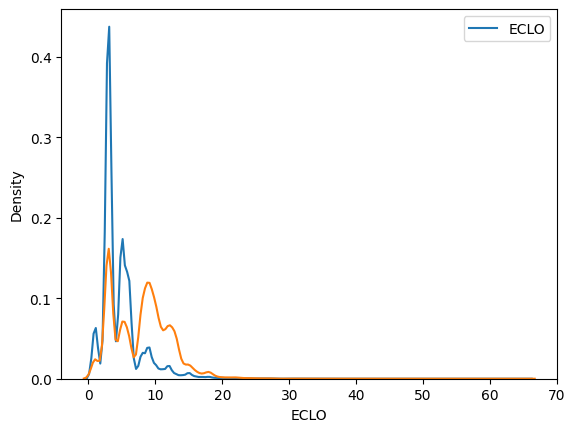

In [25]:
# smogn ('balance')을 적용한 train data 확인

y_train_smogn_ba = smogn_ba["ECLO"]

X_train_smogn_ba = smogn_ba.drop("ECLO", axis=1)

print(X_train.shape)
print(X_train_smogn_ba.shape)
print(y_train.shape)
print(y_train_smogn_ba.shape)

sns.kdeplot(y_train, label = "Original")
sns.kdeplot(y_train_smogn_ba, label = "Modified")

In [13]:
smogn_ex = smoter(
    data = data_smogn, 
    y = "ECLO",
    k = 5,   # 참고할 이웃의 수
    samp_method = "extreme",   # oversampling을 적당하게 하겠다는 의미
    rel_thres = 0.7,   # sampling threshold 기준
    rel_method="auto"
)

synth_matrix: 100%|##########| 4499/4499 [00:37<00:00, 121.08it/s]


(31687, 14)
(48745, 14)
(31687, 1)
(48745,)


<Axes: xlabel='ECLO', ylabel='Density'>

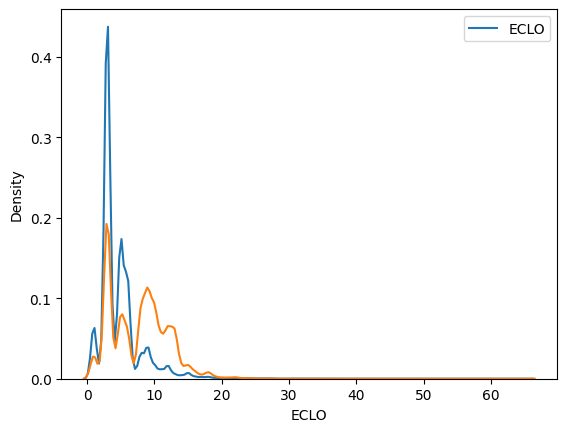

In [14]:
# smogn ('extreme')을 적용한 train data 확인

y_train_smogn = smogn_ex["ECLO"]

X_train_smogn = smogn_ex.drop("ECLO", axis=1)

print(X_train.shape)
print(X_train_smogn.shape)
print(y_train.shape)
print(y_train_smogn.shape)

sns.kdeplot(y_train, label = "Original")
sns.kdeplot(y_train_smogn, label = "Modified")

### 범주형 변수를 LabelBinary

In [7]:
df_train_obj = df_train[['요일', '기상상태', '도로형태', '노면상태', '사고유형']]

In [8]:
def label_bin(column) : 
    """
    범주형 변수를 전부 one-hot-encoding
    """
    lb = LabelBinarizer()
    
    array = lb.fit_transform(column)
    
    classes = lb.classes_.tolist()
        
    classes_col = [column.name+"_"+c for c in classes]
    
    df_lb = pd.DataFrame(data=array, columns=classes_col)
    
    return df_lb, lb, classes_col

In [9]:
obj_day, lb_day, class_day = label_bin(df_train_obj["요일"])
obj_weather, lb_weather, class_weather = label_bin(df_train_obj["기상상태"])
obj_surf, lb_surf, class_surf = label_bin(df_train_obj["노면상태"])
obj_doro, lb_doro, class_doro = label_bin(df_train_obj["도로형태"])
obj_sago, lb_sago, class_sago = label_bin(df_train_obj["사고유형"])

obj_day_test = pd.DataFrame(lb_day.transform(df_test["요일"]), columns=class_day)
obj_weather_test = pd.DataFrame(lb_weather.transform(df_test["기상상태"]), columns=class_weather)
obj_surf_test = pd.DataFrame(lb_surf.transform(df_test["노면상태"]), columns=class_surf)
obj_doro_test = pd.DataFrame(lb_doro.transform(df_test["도로형태"]), columns=class_doro)
obj_sago_test = pd.DataFrame(lb_sago.transform(df_test["사고유형"]), columns=class_sago)

obj_onehot_train = pd.concat([obj_day,obj_weather,obj_surf,obj_doro,obj_sago], axis=1)
obj_onehot_test = pd.concat([obj_day_test,obj_weather_test,obj_surf_test,obj_doro_test,obj_sago_test], axis=1)

print(obj_onehot_train.shape)
print(obj_onehot_test.shape)

obj_onehot_train.head()

(39609, 33)
(10963, 33)


요일_금요일  요일_목요일  요일_수요일  요일_월요일  요일_일요일  요일_토요일  요일_화요일  기상상태_기타  기상상태_눈  \
0       0       0       0       0       0       0       1        0       0   
1       0       0       0       0       0       0       1        0       0   
2       0       0       0       0       0       0       1        0       0   
3       0       0       0       0       0       0       1        0       0   
4       0       0       0       0       0       0       1        0       0   

   기상상태_맑음  ...  도로형태_단일로 - 고가도로위  도로형태_단일로 - 교량  도로형태_단일로 - 기타  \
0        1  ...                 0              0              1   
1        0  ...                 0              0              1   
2        1  ...                 0              0              1   
3        1  ...                 0              0              1   
4        1  ...                 0              0              1   

   도로형태_단일로 - 지하차도(도로)내  도로형태_단일로 - 터널  도로형태_미분류 - 미분류  도로형태_주차장 - 주차장  \
0                     0              0               0               0   
1                     0              0               0               0   
2                     0              0               0               0   
3                     0              0               0               0   
4                     0              0               0               0   

   사고유형_차대사람  사고유형_차대차  사고유형_차량단독  
0          1         0          0  
1          1         0          0  
2          1         0          0  
3          0         1          0  
4          0         1          0  

[5 rows x 33 columns]

In [10]:
X_one = pd.concat([X.drop(["요일", "기상상태_label", "노면상태_label", "사고유형", "도로형태"], axis=1).reset_index(), obj_onehot_train], axis=1)
test_one = pd.concat([test.drop(["요일", "기상상태_label", "노면상태_label", "사고유형", "도로형태"], axis=1).reset_index(), obj_onehot_test], axis=1)

X_one.set_index("사고일시", inplace=True)
test_one.set_index("사고일시", inplace=True)

X_train_one = X_one.iloc[:31687]
X_val_one = X_one.iloc[31687:]
y_train_one = y.iloc[:31687]
y_val_one = y.iloc[31687:]

print(X_train_one.shape)
print(X_val_one.shape)
print(y_train_one.shape)
print(y_val_one.shape)

X_train_one

(31687, 42)
(7922, 42)
(31687, 1)
(7922, 1)


주소별 cctv 수  사고 월  사고 시각  사고시간대 밀도 합    평균속도_max  \
사고일시                                                                   
2019-01-01 00:00:00           3     1      0   312.06683   723.99000   
2019-01-01 00:00:00          10     1      0  1022.36378  2142.80000   
2019-01-01 01:00:00           2     1      1   561.03238  1932.21000   
2019-01-01 02:00:00           6     1      2   254.98900  1775.36000   
2019-01-01 04:00:00           9     1      4   434.11503  3768.83000   
...                         ...   ...    ...         ...         ...   
2021-05-08 12:00:00          12     5     12  1870.10763  2664.83000   
2021-05-08 13:00:00          62     5     13  8141.27602  9109.76000   
2021-05-08 13:00:00           7     5     13  3214.51870  7905.84000   
2021-05-08 13:00:00          39     5     13  3570.62796 13281.46000   
2021-05-08 13:00:00           8     5     13  4190.34210  2830.43000   

                       추정교통량_mean  추정교통량_승용차_mean  추정교통량_버스_mean  \
사고일시                                                               
2019-01-01 00:00:00  549258.22000    474724.12000    32891.89000   
2019-01-01 00:00:00 1812718.27000   1544309.56000   105449.71000   
2019-01-01 01:00:00 1073433.20000    950354.81000    52940.10000   
2019-01-01 02:00:00 1184141.76000    928212.11000    91811.50000   
2019-01-01 04:00:00 2040952.08000   1684317.26000   152959.33000   
...                           ...             ...            ...   
2021-05-08 12:00:00 1287237.17000   1026239.88000    62975.93000   
2021-05-08 13:00:00 5221511.66000   4450520.19000   349022.58000   
2021-05-08 13:00:00 2610262.66000   1932724.52000    69334.25000   
2021-05-08 13:00:00 3327446.98000   2459362.41000    91977.59000   
2021-05-08 13:00:00 2290483.79000   1952907.83000   143692.38000   

                     추정교통량_트럭_mean  요일_금요일  ...  도로형태_단일로 - 고가도로위  \
사고일시                                        ...                     
2019-01-01 00:00:00    41642.21000       0  ...                 0   
2019-01-01 00:00:00   162959.00000       0  ...                 0   
2019-01-01 01:00:00    70138.25000       0  ...                 0   
2019-01-01 02:00:00   164118.15000       0  ...                 0   
2019-01-01 04:00:00   203675.47000       0  ...                 0   
...                            ...     ...  ...               ...   
2021-05-08 12:00:00   198021.37000       0  ...                 0   
2021-05-08 13:00:00   421968.86000       0  ...                 0   
2021-05-08 13:00:00   608203.89000       0  ...                 0   
2021-05-08 13:00:00   776106.93000       0  ...                 0   
2021-05-08 13:00:00   193883.55000       0  ...                 0   

                     도로형태_단일로 - 교량  도로형태_단일로 - 기타  도로형태_단일로 - 지하차도(도로)내  \
사고일시                                                                      
2019-01-01 00:00:00              0              1                     0   
2019-01-01 00:00:00              0              1                     0   
2019-01-01 01:00:00              0              1                     0   
2019-01-01 02:00:00              0              1                     0   
2019-01-01 04:00:00              0              1                     0   
...                            ...            ...                   ...   
2021-05-08 12:00:00              0              0                     0   
2021-05-08 13:00:00              0              1                     0   
2021-05-08 13:00:00              0              1                     0   
2021-05-08 13:00:00              0              0                     0   
2021-05-08 13:00:00              0              1                     0   

                     도로형태_단일로 - 터널  도로형태_미분류 - 미분류  도로형태_주차장 - 주차장  사고유형_차대사람  \
사고일시                                                                            
2019-01-01 00:00:00              0               0               0          1   
2019-01-01 00:00:00              0               0               0          1   
2

### minmaxscaling

In [15]:
def mmsc(X_t, X_v) : 
    mmsc = MinMaxScaler()

    mmsc.fit(X_t)

    train_mmsc = mmsc.transform(X_t)
    val_mmsc = mmsc.transform(X_v)

    print(train_mmsc.shape)
    print(val_mmsc.shape)

    return mmsc, train_mmsc, val_mmsc

In [16]:
mmsc_x, X_train_mmsc, X_val_mmsc = mmsc(X_t=X_train, X_v = X_val)

(31687, 14)
(7922, 14)


In [17]:
mmsc_x_smogn, X_train_smogn_mmsc, X_val_smogn_mmsc = mmsc(X_t=X_train_smogn, X_v = X_val)

(48745, 14)
(7922, 14)


### 모델 선정

In [11]:
def models(X_t, X_v, y_t, y_v, random_state) : 
    rf = RandomForestRegressor(random_state=random_state)
    en = ElasticNet(random_state=random_state)
    lg = LGBMRegressor(random_state=random_state)
    xgb = XGBRegressor()
    exb = ExplainableBoostingRegressor(random_state=random_state)
    cat = CatBoostRegressor(random_state=random_state)

    rf.fit(X_t, y_t)
    en.fit(X_t, y_t)
    lg.fit(X_t, y_t)
    xgb.fit(X_t, y_t)
    exb.fit(X_t, y_t)
    cat.fit(X_t, y_t)

    y_pred_rf= rf.predict(X_v)
    y_pred_en= en.predict(X_v)
    y_pred_lg= lg.predict(X_v)
    y_pred_xgb= xgb.predict(X_v)
    y_pred_exb= exb.predict(X_v)
    y_pred_cat= cat.predict(X_v)

    # y_pred_rf = MMscaler.inverse_transform(np.array(y_pred_rf).reshape(-1,1))
    # y_pred_en = MMscaler.inverse_transform(np.array(y_pred_en).reshape(-1,1))
    # y_pred_lg = MMscaler.inverse_transform(np.array(y_pred_lg).reshape(-1,1))
    # y_pred_xgb = MMscaler.inverse_transform(np.array(y_pred_xgb).reshape(-1,1))

    print("randomforest - ","r2 score :", round(r2_score(y_v, y_pred_rf),4), " rmse :", mean_squared_error(y_v, y_pred_rf, squared=False))
    print("elasticnet - ","r2 score :", round(r2_score(y_v, y_pred_en),4), " rmse :", mean_squared_error(y_v, y_pred_en, squared=False))
    print("lightgbm - ","r2 score :", round(r2_score(y_v, y_pred_lg),4), " rmse :", mean_squared_error(y_v, y_pred_lg, squared=False))
    print("xgboost - ","r2 score :", round(r2_score(y_v, y_pred_xgb),4), " rmse :", mean_squared_error(y_v, y_pred_xgb, squared=False))
    print("explainableboost - ","r2 score :", round(r2_score(y_v, y_pred_exb),4), " rmse :", mean_squared_error(y_v, y_pred_exb, squared=False))
    print("catboost - ","r2 score :", round(r2_score(y_v, y_pred_cat),4), " rmse :", mean_squared_error(y_v, y_pred_cat, squared=False))

In [320]:
models(X_t=X_train, X_v=X_val, y_t=y_train, y_v=y_val, random_state=randomState)  # 원래 train data로 학습

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1257
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 14
[LightGBM] [Info] Start training from score 4.772746
Learning rate set to 0.070684
0:	learn: 3.2408896	total: 5.54ms	remaining: 5.53s
1:	learn: 3.2359615	total: 10.4ms	remaining: 5.19s
2:	learn: 3.2321465	total: 14.5ms	remaining: 4.82s
3:	learn: 3.2281277	total: 20ms	remaining: 4.98s
4:	learn: 3.2244557	total: 26.7ms	remaining: 5.31s
5:	learn: 3.2211739	total: 32.7ms	remaining: 5.41s
6:	learn: 3.2182286	total: 39ms	remaining: 5.54s
7:	learn: 3.2159693	total: 43.3ms	remaining: 5.37s
8:	learn: 3.2136737	total: 47.3ms	remaining: 5.2s
9:	learn: 3.2114491	total: 51m

In [19]:
models(X_t=X_train_smogn, X_v=X_val, y_t=y_train_smogn, y_v=y_val, random_state=randomState)   # oversampling 된 데이터로 학습

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1172
[LightGBM] [Info] Number of data points in the train set: 48745, number of used features: 14
[LightGBM] [Info] Start training from score 7.698656
Learning rate set to 0.075661
0:	learn: 4.2283192	total: 149ms	remaining: 2m 28s
1:	learn: 4.2010301	total: 155ms	remaining: 1m 17s
2:	learn: 4.1772123	total: 162ms	remaining: 53.8s
3:	learn: 4.1565503	total: 170ms	remaining: 42.4s
4:	learn: 4.1397853	total: 218ms	remaining: 43.3s
5:	learn: 4.1234355	total: 254ms	remaining: 42.1s
6:	learn: 4.1107996	total: 264ms	remaining: 37.5s
7:	learn: 4.0998946	total: 273ms	remaining: 33.8s
8:	learn: 4.0889338	total: 286ms	remaining: 31.5s
9:	learn: 4.0790956	total: 294ms

In [20]:
models(X_t=X_train_smogn_mmsc, X_v=X_val_smogn_mmsc, y_t=y_train_smogn, y_v=y_val, random_state=randomState)   # 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1167
[LightGBM] [Info] Number of data points in the train set: 48745, number of used features: 14
[LightGBM] [Info] Start training from score 7.698656
Learning rate set to 0.075661
0:	learn: 4.2283192	total: 5.2ms	remaining: 5.2s
1:	learn: 4.2010301	total: 10.5ms	remaining: 5.24s
2:	learn: 4.1772123	total: 18.3ms	remaining: 6.09s
3:	learn: 4.1565503	total: 23.9ms	remaining: 5.95s
4:	learn: 4.1397853	total: 31ms	remaining: 6.18s
5:	learn: 4.1234355	total: 36ms	remaining: 5.97s
6:	learn: 4.1107996	total: 41.3ms	remaining: 5.86s
7:	learn: 4.0998946	total: 48.2ms	remaining: 5.97s
8:	learn: 4.0889338	total: 53.8ms	remaining: 5.93s
9:	learn: 4.0790956	total: 58.8ms	remaining: 5.82s
10:	learn: 4.0707693	total: 65.3ms	remaining: 5.87s
11:	lear

In [26]:
models(X_t=X_train_smogn_ba, X_v=X_val, y_t=y_train_smogn_ba, y_v=y_val, random_state=randomState) 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1163
[LightGBM] [Info] Number of data points in the train set: 27188, number of used features: 14
[LightGBM] [Info] Start training from score 7.904885
Learning rate set to 0.068994
0:	learn: 4.2963004	total: 4.51ms	remaining: 4.5s
1:	learn: 4.2779270	total: 9.25ms	remaining: 4.62s
2:	learn: 4.2602082	total: 12.8ms	remaining: 4.27s
3:	learn: 4.2465223	total: 16.5ms	remaining: 4.11s
4:	learn: 4.2339497	total: 21.2ms	remaining: 4.22s
5:	learn: 4.2220520	total: 26.2ms	remaining: 4.34s
6:	learn: 4.2124045	total: 29.9ms	remaining: 4.24s
7:	learn: 4.2045441	total: 34ms	remaining: 4.22s
8:	learn: 4.1958020	total: 39.2ms	remaining: 4.31s
9:	learn: 4.1879061	total: 42.7ms	remaining: 4.23s
10:	learn: 4.1808191	total: 46.3ms	remain

In [13]:
models(X_t=X_train_one, X_v=X_val_one, y_t=y_train_one, y_v=y_val_one, random_state=randomState) 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1282
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 37
[LightGBM] [Info] Start training from score 4.772746
Learning rate set to 0.070684
0:	learn: 3.2408269	total: 148ms	remaining: 2m 27s
1:	learn: 3.2351730	total: 154ms	remaining: 1m 16s
2:	learn: 3.2303697	total: 160ms	remaining: 53.3s
3:	learn: 3.2267688	total: 168ms	remaining: 41.8s
4:	learn: 3.2232404	total: 179ms	remaining: 35.7s
5:	learn: 3.2203615	total: 188ms	remaining: 31.2s
6:	learn: 3.2171242	total: 198ms	remaining: 28.2s
7:	learn: 3.2146844	total: 202ms	remaining: 25.1s
8:	learn: 3.2124696	total: 209ms	remaining: 23s
9:	learn: 3.2100649	total: 220ms	r

In [16]:
def submission(name_sub : str, predict) :
    sub = pd.read_csv("./data/sample_submission.csv")

    copy_sub = copy.deepcopy(sub)

    copy_sub["ECLO"] = predict

    copy_sub.to_csv(name_sub, index=False)

### vif와 pca

변수의 다중공선성을 파악하고, pca를 통해 변수의 중요도를 분산으로 파악하려함

In [321]:
def vif(dataframe) : 

    number_select_dr = copy.deepcopy(dataframe)

    vif = pd.DataFrame()
    vif["VIF"] = [variance_inflation_factor(number_select_dr.values, i) for i in range(len(number_select_dr.columns))]   # i에 따라 vif 값을 리스트에 저장
    vif["features"] = number_select_dr.columns

    vif.sort_values("VIF", axis=0, ascending=True, inplace=True)

    print(vif)

In [322]:
# vif
vif(X)

                      VIF        features
3                 3.60158      주소별 cctv 수
4                 4.68583            사고 월
0                 4.74250              요일
9                 7.18475        평균속도_max
5                 7.22799           사고 시각
8                 8.77013      사고시간대 밀도 합
2                25.60964            사고유형
1                26.16781            도로형태
6                33.10389      기상상태_label
7                79.62466      노면상태_label
12   52673679852286.50000   추정교통량_버스_mean
13  360287970189639.68750   추정교통량_트럭_mean
10 9007199254740992.00000      추정교통량_mean
11 9007199254740992.00000  추정교통량_승용차_mean


In [323]:
# pca

mmsc = MinMaxScaler()

number_select_sc = mmsc.fit_transform(X)

df_pca = pd.DataFrame()

# df_pca["columns"] = number_select_dr.columns

pca = PCA()

pca.fit(number_select_sc)

df_pca["기여도"] = pca.explained_variance_ratio_

df_pca

기여도
0  0.30866
1  0.15232
2  0.13475
3  0.11563
4  0.08559
5  0.07732
6  0.04406
7  0.03099
8  0.02510
9  0.01215
10 0.00604
11 0.00386
12 0.00352
13 0.00000

vif가 10이상일 때 다중공선성이 의심됩니다.  
  
추정 교통량은 승용차, 버스, 트럭을 합친 값이므로  
  
추정 교통량만 남기고 나머지 변수를 제거한 뒤 vif를 다시 살펴봐야 합니다.

In [324]:
# 추정교통량_트럭_mean, 추정교통량_버스_mean, 추정교통량_승용차_mean 제거

vif(X.drop(["추정교통량_트럭_mean", "추정교통량_버스_mean", "추정교통량_승용차_mean"], axis=1))

        VIF    features
3   3.30398  주소별 cctv 수
9   4.53682    평균속도_max
4   4.68483        사고 월
0   4.74103          요일
5   7.18971       사고 시각
8   8.12275  사고시간대 밀도 합
10 16.33259  추정교통량_mean
2  25.55456        사고유형
1  26.12217        도로형태
6  33.09050  기상상태_label
7  79.58289  노면상태_label


In [325]:
# 노면상태 제거
vif(X.drop(["추정교통량_트럭_mean", "추정교통량_버스_mean", "추정교통량_승용차_mean", "노면상태_label"], axis=1))

       VIF    features
3  3.30391  주소별 cctv 수
8  4.53628    평균속도_max
4  4.64881        사고 월
0  4.70855          요일
6  5.71084  기상상태_label
5  7.09864       사고 시각
7  8.11279  사고시간대 밀도 합
9 16.28008  추정교통량_mean
2 23.33711        사고유형
1 23.48543        도로형태


### vif 이후 모델링

In [326]:
X2 = X.drop(["추정교통량_트럭_mean", "추정교통량_버스_mean", "추정교통량_승용차_mean", "노면상태_label"], axis=1)

print(X2.shape)

(39609, 10)


In [327]:
# X_train2, X_val2, y_train2, y_val2 = train_test(X2, y, random_state=randomState)

In [328]:
X_train2 = X2.iloc[:31687]
X_val2 = X2.iloc[31687:]
y_train2 = y.iloc[:31687]
y_val2 = y.iloc[31687:]

# X_train2 = X2.iloc[:31687]
# X_val2 = X2.iloc[31687:]
# y_train2 = y_log.iloc[:31687]
# y_val2 = y_log.iloc[31687:]

In [72]:
mmsc_x2 = MinMaxScaler()

mmsc_x2.fit(X_train2)

X_train2_mmsc = mmsc_x2.transform(X_train2)

X_val2_mmsc = mmsc_x2.transform(X_val2)

X_train2_mmsc

array([[0.33333333, 1.        , 0.5       , ..., 0.        , 0.28787597,
        0.23331701],
       [0.33333333, 1.        , 0.5       , ..., 0.        , 0.30681396,
        0.69770766],
       [0.33333333, 1.        , 0.5       , ..., 0.        , 0.42749722,
        0.39638811],
       ...,
       [1.        , 1.        , 1.        , ..., 0.        , 0.90930189,
        0.63272275],
       [1.        , 0.7       , 1.        , ..., 0.        , 0.90930189,
        0.63272275],
       [1.        , 1.        , 1.        , ..., 0.        , 0.33280728,
        0.64472047]])

In [329]:
models(X_t=X_train2, X_v=X_val2, y_t=y_train2, y_v=y_val2, random_state=randomState)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 711
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 10
[LightGBM] [Info] Start training from score 4.772746
Learning rate set to 0.070684
0:	learn: 3.2405167	total: 15ms	remaining: 15s
1:	learn: 3.2352546	total: 26.5ms	remaining: 13.2s
2:	learn: 3.2303366	total: 34ms	remaining: 11.3s
3:	learn: 3.2262875	total: 47.5ms	remaining: 11.8s
4:	learn: 3.2228790	total: 60.7ms	remaining: 12.1s
5:	learn: 3.2197929	total: 68.2ms	remaining: 11.3s
6:	learn: 3.2167954	total: 72.3ms	remaining: 10.3s
7:	learn: 3.2143298	total: 80.2ms	remaining: 9.94s
8:	learn: 3.2115943	total: 86ms	remaining: 9.47s
9:	learn: 3.2097163	total: 94.9ms	

vif 이후 rmse가 증가한 것을 확인할 수 있음

### pca 이후 모델링

In [331]:
pca_model = PCA(n_components=6)

pca_model.fit(X_train_mmsc)

X_train2_pca = pca_model.transform(X_train_mmsc)

X_val2_pca = pca_model.transform(X_val_mmsc)

X_val2_pca

array([[-0.31955991,  0.49941176, -0.14264776, -0.11585123, -0.02052465,
        -0.0999262 ],
       [-0.62077076,  0.49124339, -0.13826278, -0.11341132, -0.11231165,
        -0.07882842],
       [-0.24117897,  0.49792138, -0.14102417, -0.1131683 , -0.1071485 ,
        -0.08180709],
       ...,
       [ 0.00634859,  0.03638063,  0.51387221, -0.04726642, -0.33570454,
        -0.01849515],
       [-0.37964369,  0.02736982,  0.52099833, -0.04417788, -0.37499382,
         0.00153463],
       [ 0.73439807,  0.04918721,  0.50926757, -0.03279687, -0.35436016,
         0.01945435]])

In [332]:
models(X_t=X_train2_pca, X_v=X_val2_pca, y_t=y_train2, y_v=y_val2, random_state=randomState)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 6
[LightGBM] [Info] Start training from score 4.772746
Learning rate set to 0.070684
0:	learn: 3.2410758	total: 5.32ms	remaining: 5.31s
1:	learn: 3.2364382	total: 9.53ms	remaining: 4.75s
2:	learn: 3.2319142	total: 13.2ms	remaining: 4.39s
3:	learn: 3.2279623	total: 17.1ms	remaining: 4.25s
4:	learn: 3.2249359	total: 23.1ms	remaining: 4.59s
5:	learn: 3.2218682	total: 27.7ms	remaining: 4.59s
6:	learn: 3.2184569	total: 31.4ms	remaining: 4.45s
7:	learn: 3.2161507	total: 35.7ms	remaining: 4.42s
8:	learn: 3.2140043	total: 40.9ms	remaining: 4.5s
9:	learn: 3.2125068	total: 44.7ms	remaining: 4.43s
10:	learn: 3.2108708	total: 48.9ms	remaining: 4.4s
11:	learn: 3.2093039	total: 53.5ms	remaining: 4.4s
12:	learn: 3.20794

pca 이후 rmse가 증가

### catboost를 사용한 모델링

In [45]:
# cat = CatBoostRegressor(random_seed=randomState)

# cat.fit(X_train_cat, y_train_cat, cat_features=X_train_cat.columns.to_list())

# predict_cat = cat.predict(X_val_cat)

# print("catboost - ","r2 score :", round(r2_score(y_val_cat, predict_cat),4), " rmse :", mean_squared_error(y_val_cat, predict_cat, squared=False))

### explainableboost를 사용한 모델링

In [333]:
from interpret import show

show_expb = ExplainableBoostingRegressor(random_state=randomState)

show_expb.fit(X_train, y_train)

global_explanation = show_expb.explain_global(name="EBM")
show(global_explanation)

<!-- http://127.0.0.1:7001/2095389013520/ -->

In [11]:
model_col = ["사고유형", "요일", "사고 시각", "도로형태", "사고시간대 밀도 합", "주소별 cctv 수", "추정교통량_트럭_mean", "추정교통량_버스_mean", "평균속도_max"]

In [13]:
def most_columns(X_t, X_v, y_t, y_v, model, columns : list) : 

    for i in range(6) : 

        model.fit(X_t[columns[:i+4]], y_t)   

        y_pred = model.predict(X_v)

        print("학습 변수가 ", model_col[:i+5], "일 때")
        print("r2 score =", round(r2_score(y_v, y_pred), 5))
        print("rmse =", round(mean_squared_error(y_v, y_pred, squared=False), 5))

In [14]:
exp1 = ExplainableBoostingRegressor(random_state=randomState)

most_columns(X_train, X_val, y_train, y_val, model=exp1, columns=model_col)

학습 변수가  ['사고유형', '요일', '사고 시각', '도로형태', '사고시간대 밀도 합'] 일 때
r2 score = 0.01789
rmse = 3.00915
학습 변수가  ['사고유형', '요일', '사고 시각', '도로형태', '사고시간대 밀도 합', '주소별 cctv 수'] 일 때
r2 score = 0.0177
rmse = 3.00945
학습 변수가  ['사고유형', '요일', '사고 시각', '도로형태', '사고시간대 밀도 합', '주소별 cctv 수', '추정교통량_트럭_mean'] 일 때
r2 score = 0.01993
rmse = 3.00602
학습 변수가  ['사고유형', '요일', '사고 시각', '도로형태', '사고시간대 밀도 합', '주소별 cctv 수', '추정교통량_트럭_mean', '추정교통량_버스_mean'] 일 때
r2 score = 0.0263
rmse = 2.99624
학습 변수가  ['사고유형', '요일', '사고 시각', '도로형태', '사고시간대 밀도 합', '주소별 cctv 수', '추정교통량_트럭_mean', '추정교통량_버스_mean', '평균속도_max'] 일 때
r2 score = 0.02717
rmse = 2.9949
학습 변수가  ['사고유형', '요일', '사고 시각', '도로형태', '사고시간대 밀도 합', '주소별 cctv 수', '추정교통량_트럭_mean', '추정교통량_버스_mean', '평균속도_max'] 일 때
r2 score = 0.02678
rmse = 2.99551


In [338]:
selected_col = ['사고유형', '요일', '사고 시각', '도로형태', '사고시간대 밀도 합', '주소별 cctv 수', '추정교통량_트럭_mean', '추정교통량_버스_mean']  # 선택된 변수

In [19]:
exp_sub1 = ExplainableBoostingRegressor(random_state=randomState)

exp_sub1.fit(X_train, y_train)

y_pred_exp_sub1 = exp_sub1.predict(test)

In [20]:
submission("./submission1_231129.csv", predict=y_pred_exp_sub1)

In [57]:
# 전체 데이터 학습

expb_all = ExplainableBoostingRegressor(random_state=randomState)

expb_all.fit(X_exp, y)

predict_all_1 = expb_all.predict(test[["사고유형", "요일", "사고 시각", "도로형태", "주소별 cctv 수", "추정교통량_mean", "평균속도_max"]])

print(predict_all_1)

copy_sub2 = copy.deepcopy(sub)

copy_sub2["ECLO"] = predict_all_1

copy_sub2.to_csv("./submission3_231127.csv", index=False)

copy_sub2

[4.60405525 4.12029256 6.21178685 ... 5.65559508 5.33360851 5.31305521]


ID    ECLO
0      ACCIDENT_39609 4.60406
1      ACCIDENT_39610 4.12029
2      ACCIDENT_39611 6.21179
3      ACCIDENT_39612 5.25033
4      ACCIDENT_39613 5.13153
...               ...     ...
10958  ACCIDENT_50567 6.01047
10959  ACCIDENT_50568 5.13866
10960  ACCIDENT_50569 5.65560
10961  ACCIDENT_50570 5.33361
10962  ACCIDENT_50571 5.31306

[10963 rows x 2 columns]

### y의 분포를 변환

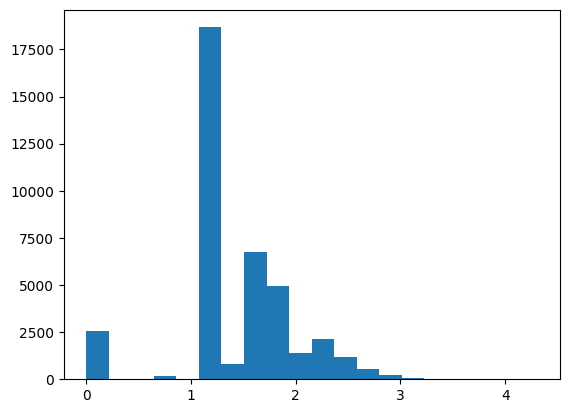

In [30]:
plt.hist(np.log(y), bins=20)

plt.show()

In [41]:
y_train_exp = np.log10(y_train)

y_train_exp

ECLO
0     0.69897
1     0.47712
2     0.47712
3     0.69897
4     0.47712
...       ...
31682 1.07918
31683 0.47712
31684 0.47712
31685 0.84510
31686 0.77815

[31687 rows x 1 columns]

In [44]:
exp_sub2 = ExplainableBoostingRegressor(random_state=randomState)

exp_sub2.fit(X_train, y_train_exp)

y_pred_exp_sub_exp = exp_sub2.predict(X_val)

y_pred_exp_sub2 = 10 ** y_pred_exp_sub_exp

# y_pred_exp_sub2 = np.exp(y_pred_exp_sub_exp)

y_pred_exp_sub2 = y_pred_exp_sub2.reshape(-1,1)

y_pred_exp_sub2.shape

(7922, 1)

In [45]:
print("r2 score =", round(r2_score(y_val, y_pred_exp_sub2), 5))
print("rmse =", round(mean_squared_error(y_val, y_pred_exp_sub2, squared=False), 5))

r2 score = -0.00696
rmse = 3.04698


### GridSearchCV

In [16]:
default_params = {
                "max_bins" : [256], 
                "max_interaction_bins" : [32],
                "interactions" : [10],
                'learning_rate' : [0.01],
                'max_rounds' : [5000],
                "early_stopping_rounds" : [50],
                "min_samples_leaf" : [2], 
                "max_leaves" : [3],
                "n_jobs" : [-2]
                  }

In [342]:
params = {"interactions" : [5, 10],
              "validation_size" : [0],
              "learning_rate" : [0.05, 0.01], 
              "max_rounds" : [1000], 
              "early_stopping_rounds" : [100],
              "min_samples_leaf" : [1, 2], 
              "max_leaves" : [3, 4, 5, 6],
              "n_jobs" : [-1], 
              "random_state" : [randomState]}

In [19]:
def grid_search_cv(X, y, params : dict) : 

    import time

    # dictionary of hyper parameter
    
    
    # model of explainableboost
    explain_boost = ExplainableBoostingRegressor()

    grid = GridSearchCV(estimator=explain_boost, param_grid=params, cv=5, n_jobs=-1, scoring='neg_root_mean_squared_error')
    
    start_time = time.time()  # 함수 시작
    
    grid.fit(X, y)

    end_time = time.time()   # 함수 끝

    bestParam = grid.best_params_

    print("함수 동작 시간 :", str(round((end_time - start_time)/60, 2))+"분")
    print("최적의 하이퍼 파라미터 :",bestParam)
    print("최적의 score :",grid.best_score_)

    return bestParam

In [360]:
# train data를 train-validation으로 분리한 데이터로 gridsearchcv

bestParams_tv = grid_search_cv(X=X_train, y=y_train, params=params)

함수 동작 시간 : 12.86분
최적의 하이퍼 파라미터 : {'early_stopping_rounds': 100, 'interactions': 5, 'learning_rate': 0.01, 'max_leaves': 3, 'max_rounds': 1000, 'min_samples_leaf': 1, 'n_jobs': -1, 'random_state': 100, 'validation_size': 0}
최적의 score : -3.1977717443880236


In [354]:
# train data 전부로 gridsearchcv

bestParams_tt = grid_search_cv(X=X, y=y, params=params)

함수 동작 시간 : 10.83분
최적의 하이퍼 파라미터 : {'early_stopping_rounds': 100, 'interactions': 5, 'learning_rate': 0.01, 'max_leaves': 3, 'max_rounds': 1000, 'min_samples_leaf': 1, 'n_jobs': -1, 'random_state': 100, 'validation_size': 0}
최적의 score : -3.156704621814605


In [15]:
expb_grid = ExplainableBoostingRegressor(early_stopping_rounds=100, interactions=5, learning_rate=0.05, max_leaves=4, \
                                         max_rounds=1000, min_samples_leaf=1, n_jobs=-1, random_state=randomState, validation_size=0.2)

most_columns(X_train, X_val, y_train, y_val, model=expb_grid, columns=model_col)


학습 변수가  ['사고유형', '요일', '사고 시각', '도로형태', '사고시간대 밀도 합'] 일 때
r2 score = 0.01853
rmse = 3.00817
학습 변수가  ['사고유형', '요일', '사고 시각', '도로형태', '사고시간대 밀도 합', '주소별 cctv 수'] 일 때
r2 score = 0.01727
rmse = 3.01009
학습 변수가  ['사고유형', '요일', '사고 시각', '도로형태', '사고시간대 밀도 합', '주소별 cctv 수', '추정교통량_트럭_mean'] 일 때
r2 score = 0.01896
rmse = 3.00751
학습 변수가  ['사고유형', '요일', '사고 시각', '도로형태', '사고시간대 밀도 합', '주소별 cctv 수', '추정교통량_트럭_mean', '추정교통량_버스_mean'] 일 때
r2 score = 0.02546
rmse = 2.99753
학습 변수가  ['사고유형', '요일', '사고 시각', '도로형태', '사고시간대 밀도 합', '주소별 cctv 수', '추정교통량_트럭_mean', '추정교통량_버스_mean', '평균속도_max'] 일 때
r2 score = 0.02504
rmse = 2.99817
학습 변수가  ['사고유형', '요일', '사고 시각', '도로형태', '사고시간대 밀도 합', '주소별 cctv 수', '추정교통량_트럭_mean', '추정교통량_버스_mean', '평균속도_max'] 일 때
r2 score = 0.02545
rmse = 2.99754


하이퍼 파라미터의 종류가 default 값보다 예측력이 좋지 않기 때문에  
  
default 값을 기준으로 gridsearchcv

explainboost의 default로 학습했을 때 rmse = 2.9959641771463916

In [36]:
def explain_boost(model, X_t, X_v, y_t, y_v) : 
    model.fit(X_t, y_t)

    predict = model.predict(X_v)

    print("r2 score =", round(r2_score(y_v, predict), 4))
    print("rmse =", mean_squared_error(y_v, predict, squared=False))

    return model

In [25]:
# maxbins 수정

params_max_bins = copy.deepcopy(default_params)

params_max_bins["max_bins"] = [32, 64, 128, 256]

# params_max_bins

bestParams_mb = grid_search_cv(X=X_train, y=y_train, params=params_max_bins)

best_max_bins = bestParams_mb["max_bins"]

expb_max_bins = ExplainableBoostingRegressor(max_bins=best_max_bins, random_state=randomState)

explain_boost(expb_max_bins, X_train, X_val, y_train, y_val)

함수 동작 시간 : 0.67분
최적의 하이퍼 파라미터 : {'early_stopping_rounds': 50, 'interactions': 10, 'learning_rate': 0.01, 'max_bins': 64, 'max_interaction_bins': 32, 'max_leaves': 3, 'max_rounds': 5000, 'min_samples_leaf': 2, 'n_jobs': -2}
최적의 score : -3.1916266371128588
r2 score = 0.0276
rmse = 2.994305150424233


In [29]:
# max interaction bins 수정

params_max_it_bins = copy.deepcopy(default_params)

params_max_it_bins["max_interaction_bins"] = [16, 32, 64, 128]

# params_max_it_bins

bestParams_mib = grid_search_cv(X=X_train, y=y_train, params=params_max_it_bins)

best_max_it_bins = bestParams_mib["max_interaction_bins"]

expb_max_it_bins = ExplainableBoostingRegressor(max_interaction_bins=best_max_it_bins, random_state=randomState)

explain_boost(expb_max_it_bins, X_train, X_val, y_train, y_val)

함수 동작 시간 : 0.92분
최적의 하이퍼 파라미터 : {'early_stopping_rounds': 50, 'interactions': 10, 'learning_rate': 0.01, 'max_bins': 256, 'max_interaction_bins': 32, 'max_leaves': 3, 'max_rounds': 5000, 'min_samples_leaf': 2, 'n_jobs': -2}
최적의 score : -3.1921190764611014
r2 score = 0.0265
rmse = 2.9959641771463916


In [30]:
# interactions 수정

params_inter = copy.deepcopy(default_params)

params_inter["interactions"] = [3, 5, 10, 15, 20]

# params_inter

bestParams_inter= grid_search_cv(X=X_train, y=y_train, params=params_inter)

best_inter = bestParams_inter["interactions"]

expb_inter = ExplainableBoostingRegressor(interactions=best_inter, random_state=randomState)

explain_boost(expb_inter, X_train, X_val, y_train, y_val)

함수 동작 시간 : 0.7분
최적의 하이퍼 파라미터 : {'early_stopping_rounds': 50, 'interactions': 3, 'learning_rate': 0.01, 'max_bins': 256, 'max_interaction_bins': 32, 'max_leaves': 3, 'max_rounds': 5000, 'min_samples_leaf': 2, 'n_jobs': -2}
최적의 score : -3.1918306111571724
r2 score = 0.0257
rmse = 2.997091647817701


In [31]:
# learning_rate 수정

params_lr = copy.deepcopy(default_params)

params_lr["learning_rate"] = [0.5, 0.1, 0.05, 0.01, 0.005, 0.003]

# params_lr

bestParams_lr= grid_search_cv(X=X_train, y=y_train, params=params_lr)

best_lr = bestParams_lr["learning_rate"]

expb_lr = ExplainableBoostingRegressor(learning_rate=best_lr, random_state=randomState)

explain_boost(expb_lr, X_train, X_val, y_train, y_val)

함수 동작 시간 : 0.87분
최적의 하이퍼 파라미터 : {'early_stopping_rounds': 50, 'interactions': 10, 'learning_rate': 0.5, 'max_bins': 256, 'max_interaction_bins': 32, 'max_leaves': 3, 'max_rounds': 5000, 'min_samples_leaf': 2, 'n_jobs': -2}
최적의 score : -3.191962956964338
r2 score = 0.0266
rmse = 2.9957209668112807


In [33]:
# max_rounds, early_stopping_rounds 수정

params_mr = copy.deepcopy(default_params)

params_mr["max_rounds"] = [100, 500, 1000, 1500, 2000, 3000, 4000]
params_mr["early_stopping_rounds"] = [5, 10, 15, 20, 30, 50, 70]

# params_mr

bestParams_mr= grid_search_cv(X=X_train, y=y_train, params=params_mr)

best_mr = bestParams_mr["max_rounds"]
best_esr = bestParams_mr["early_stopping_rounds"]

expb_mr = ExplainableBoostingRegressor(max_rounds=best_mr, early_stopping_rounds=best_esr, 
                                       random_state=randomState)

explain_boost(expb_mr, X_train, X_val, y_train, y_val)

함수 동작 시간 : 4.67분
최적의 하이퍼 파라미터 : {'early_stopping_rounds': 30, 'interactions': 10, 'learning_rate': 0.01, 'max_bins': 256, 'max_interaction_bins': 32, 'max_leaves': 3, 'max_rounds': 100, 'min_samples_leaf': 2, 'n_jobs': -2}
최적의 score : -3.1909961041492623
r2 score = 0.0237
rmse = 3.0001578983407424


In [34]:
# min_samples_leaf 수정

params_msl = copy.deepcopy(default_params)

params_msl["min_samples_leaf"] = [1,2,3,4,5,6]

# params_msl

bestParams_msl= grid_search_cv(X=X_train, y=y_train, params=params_msl)

best_msl = bestParams_msl["min_samples_leaf"]

expb_msl = ExplainableBoostingRegressor(min_samples_leaf=best_msl, random_state=randomState)

explain_boost(expb_msl, X_train, X_val, y_train, y_val)

함수 동작 시간 : 0.88분
최적의 하이퍼 파라미터 : {'early_stopping_rounds': 50, 'interactions': 10, 'learning_rate': 0.01, 'max_bins': 256, 'max_interaction_bins': 32, 'max_leaves': 3, 'max_rounds': 5000, 'min_samples_leaf': 6, 'n_jobs': -2}
최적의 score : -3.1920830032182246
r2 score = 0.0265
rmse = 2.9958667678489364


In [35]:
# max_leaves 수정

params_ml = copy.deepcopy(default_params)

params_ml["max_leaves"] = [1,2,3,4,5,6]

# params_ml

bestParams_ml= grid_search_cv(X=X_train, y=y_train, params=params_ml)

best_ml = bestParams_ml["max_leaves"]

expb_ml = ExplainableBoostingRegressor(max_leaves=best_ml, random_state=randomState)

explain_boost(expb_ml, X_train, X_val, y_train, y_val)

함수 동작 시간 : 0.91분
최적의 하이퍼 파라미터 : {'early_stopping_rounds': 50, 'interactions': 10, 'learning_rate': 0.01, 'max_bins': 256, 'max_interaction_bins': 32, 'max_leaves': 6, 'max_rounds': 5000, 'min_samples_leaf': 2, 'n_jobs': -2}
최적의 score : -3.1920066080548386
r2 score = 0.0249
rmse = 2.99837121630617


In [47]:
best_esr

30

In [51]:
# gridsearcv로 찾은 하이퍼 파라미터들로 학습 검증
# max_bins 검증 시 사용했던 하이퍼 파라미터가 지표가 가장 좋음
# 'early_stopping_rounds': 50, 'interactions': 10, 'learning_rate': 0.01, 'max_bins': 64, 'max_interaction_bins': 32, 'max_leaves': 3, 'max_rounds': 5000, 'min_samples_leaf': 2, 'n_jobs': -2

expb_best = ExplainableBoostingRegressor(max_bins=64, max_interaction_bins=32,
                                         interactions=10, validation_size=0.2, learning_rate=0.01,  # best_inter
                                         max_rounds=5000, early_stopping_rounds=50, 
                                         min_samples_leaf=2, max_leaves=3, n_jobs=-2, random_state=randomState)  # best_msl

expb_best = explain_boost(expb_best, X_train, X_val, y_train, y_val)

r2 score = 0.0278
rmse = 2.993867043409363


## 저장

In [127]:
X.to_csv("./train_X_nyeoki.csv")
y.to_csv("./train_y_nyeoki.csv")
test.to_csv("./test_nyeoki.csv")

In [59]:
X_exp.to_csv("./train_X_exp_nyeoki.csv")